In [2]:
import networkx as nx
import sympy as sp
from collections import defaultdict

# Formal basis symbols:
#   B(n) := bouquet with n loops on one vertex
#   T(s) := theta graph with s parallel edges between two vertices
B = sp.Function("B")
T = sp.Function("T")

# ----------------------------
# Basic recognizers
# ----------------------------
def is_bouquet(G: nx.MultiGraph) -> bool:
    if G.number_of_nodes() != 1:
        return False
    for u, v, k in G.edges(keys=True):
        if u != v:
            return False
    return True

def bouquet_nloops(G: nx.MultiGraph) -> int:
    # assumes bouquet
    n = 0
    for u, v, k in G.edges(keys=True):
        if u == v:
            n += 1
    return n

def is_theta(G: nx.MultiGraph) -> bool:
    if G.number_of_nodes() != 2:
        return False
    # no loops, all edges between the two nodes
    nodes = list(G.nodes)
    a, b = nodes[0], nodes[1]
    for u, v, k in G.edges(keys=True):
        if u == v:
            return False
        if set((u, v)) != set((a, b)):
            return False
    return True

def theta_s(G: nx.MultiGraph) -> int:
    # assumes theta
    return G.number_of_edges()

# ----------------------------
# Graph ops: delete / contract
# ----------------------------
def pick_nonloop_edge(G: nx.MultiGraph):
    for u, v, k in G.edges(keys=True):
        if u != v:
            return (u, v, k)
    return None

def delete_edge(G: nx.MultiGraph, e):
    u, v, k = e
    H = G.copy()
    H.remove_edge(u, v, k)
    return H

def contract_edge(G: nx.MultiGraph, e):
    """
    Contract a non-loop edge (u,v,k) by merging v into u.
    Multi-edges and loops are preserved correctly.
    """
    u, v, k = e
    if u == v:
        raise ValueError("Loop contraction not allowed under rule (II).")

    H = G.copy()
    H.remove_edge(u, v, k)

    # capture edges incident to v (after removing the contracted edge)
    incident = list(H.edges(v, keys=True, data=True))

    # remove v (also removes its incident edges)
    H.remove_node(v)

    # reattach incident edges onto u
    for a, b, kk, data in incident:
        other = b if a == v else a
        new_a = u
        new_b = u if other == v else other
        H.add_edge(new_a, new_b, **data)

    return H

# ----------------------------
# Disjoint union / one-vertex join detection
# ----------------------------
def connected_components_as_subgraphs(G: nx.MultiGraph):
    # includes isolated vertices
    comps = []
    for nodes in nx.connected_components(G.to_undirected()):
        comps.append(G.subgraph(nodes).copy())
    return comps

def articulation_vertices(G: nx.MultiGraph):
    # articulation points in the underlying simple graph (ignore multiplicity/loops)
    SG = nx.Graph()
    SG.add_nodes_from(G.nodes)
    for u, v, k in G.edges(keys=True):
        if u != v:
            SG.add_edge(u, v)
    return list(nx.articulation_points(SG))

def wedge_decompose(G: nx.MultiGraph):
    """
    If G is connected and has a cut-vertex v, decompose into factors G_i
    such that G = wedge_{i=1..k} G_i (1-sum along v).
    Return (v, [G1,...,Gk]) or None.
    """
    if not nx.is_connected(G.to_undirected()):
        return None

    cvs = articulation_vertices(G)
    if not cvs:
        return None

    # pick a cut vertex that maximizes number of components after removal (usually best)
    best_v = None
    best_parts = None
    best_k = 0

    # build underlying simple graph once
    SG = nx.Graph()
    SG.add_nodes_from(G.nodes)
    for u, v, k in G.edges(keys=True):
        if u != v:
            SG.add_edge(u, v)

    for v in cvs:
        H = SG.copy()
        H.remove_node(v)
        parts = list(nx.connected_components(H))
        if len(parts) >= 2 and len(parts) > best_k:
            best_k = len(parts)
            best_v = v
            best_parts = parts

    if best_v is None:
        return None

    factors = []
    for part in best_parts:
        nodes = set(part) | {best_v}
        factors.append(G.subgraph(nodes).copy())

    return best_v, factors

# ----------------------------
# Isomorphism-safe memoization bucket
# ----------------------------
def invariants(G: nx.MultiGraph):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    deg = tuple(sorted(G.degree(u) for u in G.nodes))
    loops = tuple(sorted(G.number_of_edges(u, u) for u in G.nodes))
    return (n, m, deg, loops)

class IsoCache:
    def __init__(self):
        self.buckets = defaultdict(list)

    def get(self, G):
        sig = invariants(G)
        for H, expr in self.buckets[sig]:
            if nx.is_isomorphic(G, H):
                return expr
        return None

    def set(self, G, expr):
        sig = invariants(G)
        H = nx.convert_node_labels_to_integers(G, ordering="sorted")
        self.buckets[sig].append((H, expr))

# ----------------------------
# Main reducer: expansion in theta/bouquet basis
# ----------------------------
def yamada_expand_to_theta_bouquet(G: nx.MultiGraph):
    """
    Returns a sympy expression in the formal basis B(n), T(s),
    using rules (II)-(IV) and stopping on bouquets and thetas.
    """
    cache = IsoCache()

    def rec(H: nx.MultiGraph):
        hit = cache.get(H)
        if hit is not None:
            return hit

        # (VI) empty graph
        if H.number_of_nodes() == 0:
            expr = sp.Integer(1)
            cache.set(H, expr)
            return expr

        # (III) disjoint union
        comps = connected_components_as_subgraphs(H)
        if len(comps) > 1:
            expr = sp.Integer(1)
            for c in comps:
                expr *= rec(c)
            cache.set(H, expr)
            return expr

        # stop conditions
        if is_bouquet(H):
            expr = B(bouquet_nloops(H))
            cache.set(H, expr)
            return expr

        if is_theta(H):
            expr = T(theta_s(H))
            cache.set(H, expr)
            return expr

        # (IV) one-vertex join (generalized to k factors)
        wd = wedge_decompose(H)
        if wd is not None:
            v, factors = wd
            k = len(factors)
            expr = (-1) ** (k - 1)
            for f in factors:
                expr *= rec(f)
            cache.set(H, expr)
            return expr

        # (II) deletion–contraction on a non-loop edge
        e = pick_nonloop_edge(H)
        if e is None:
            # should not happen for a connected non-bouquet graph, but keep safe
            expr = sp.Integer(0)
            cache.set(H, expr)
            return expr

        expr = rec(delete_edge(H, e)) + rec(contract_edge(H, e))
        cache.set(H, expr)
        return expr

    return sp.simplify(rec(G))
 
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import sympy as sp
from knotted_graph.yamada import Yamada   # wherever your class lives
from knotted_graph import Vertex, Arc
import sympy as sp
from types import SimpleNamespace

# import your Yamada class
# from yourpkg.yamada import Yamada

def theta_s_yamada_abstract(s: int):
    # vertices are only used via len(vertices) in _state_graph_base :contentReference[oaicite:1]{index=1}
    vertices = [SimpleNamespace(), SimpleNamespace()]
    crossings = []  # abstract graph: no crossings => num_x=0 => one state :contentReference[oaicite:2]{index=2}

    arcs = [
        SimpleNamespace(
            id=i,
            start_id=0, start_type='v',
            end_id=1,   end_type='v',
        )
        for i in range(s)
    ]

    return Yamada(vertices=vertices, crossings=crossings, arcs=arcs)

A = sp.Symbol("Y")
s=3
yam = theta_s_yamada_abstract(s)
print(yam.compute(A, normalize=True, n_jobs=-1))
 
sigma = A + 1 + A**(-1)

Y_theta3= yam.compute(A, normalize=False)  # important
r = (sigma + (-sigma)**s)/(sigma + 1)

sp.simplify(Y_theta3 - r)  # should be 0


def theta_s_with_mid_connections_pbc(s: int):
    """
    Abstract Theta_s: two endpoints (0,1) connected by s parallel strands.
    Subdivide each strand with a midpoint vertex m_i, and connect midpoints with PBC:
        m_i -- m_{i+1}  (mod s)
    For s=2, this adds only one midpoint edge (avoids a duplicate parallel edge).
    Returns: (yam, G, pos)
    """
    if s < 1:
        raise ValueError("s must be >= 1")

    v0, v1 = 0, 1
    mids = list(range(2, 2 + s))  # 2..(s+1)

    # Dummy vertices: Yamada uses len(vertices) for vertex-node offsets
    vertices = [SimpleNamespace() for _ in range(2 + s)]
    crossings = []

    arcs = []
    arc_id = 0

    def add_arc(u, v):
        nonlocal arc_id
        arcs.append(SimpleNamespace(
            id=arc_id,
            start_id=u, start_type='v',
            end_id=v,   end_type='v',
        ))
        arc_id += 1

    # Subdivide each strand: v0 -- m_i -- v1
    for m in mids:
        add_arc(v0, m)
        add_arc(m, v1)

    # PBC midpoint connections: m_i -- m_{i+1 mod s}
    # Use a set to avoid duplicates (important for s=2).
    midpoint_pairs = set()
    if s >= 2:
        for i in range(s):
            u = mids[i]
            v = mids[(i + 1) % s]
            pair = (min(u, v), max(u, v))
            if pair not in midpoint_pairs:
                midpoint_pairs.add(pair)
                add_arc(u, v)

    yam = Yamada(vertices=vertices, crossings=crossings, arcs=arcs)

    # Build MultiGraph for plotting
    G = nx.MultiGraph()
    G.add_nodes_from([v0, v1] + mids)
    for a in arcs:
        G.add_edge(a.start_id, a.end_id)

    # Layout: endpoints left/right; midpoints vertically between them
    pos = {v0: (0.0, 0.0), v1: (4.0, 0.0)}
    if s == 1:
        pos[mids[0]] = (2.0, 0.0)
    else:
        y_vals = [-(s - 1) / 2 + i for i in range(s)]
        for m, y in zip(mids, y_vals):
            pos[m] = (2.0, float(y))

    return yam, G, pos


def plot_multigraph_pbc_curved(G, pos, pbc_pairs=None, pbc_rad=0.35, title=None):
    """
    Draw a MultiGraph where ONLY edges in `pbc_pairs` are curved.
    Everything else is drawn straight.

    pbc_pairs: set of unordered node pairs, e.g. {(2, s+1)} for your midpoint wrap edge.
    pbc_rad  : curvature for the PBC edge.
    """
    if pbc_pairs is None:
        pbc_pairs = set()

    plt.figure(figsize=(7.5, 5))

    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_labels(G, pos, font_size=10)

    # Draw edges one-by-one so we can selectively curve only the PBC connection
    for u, v, k in G.edges(keys=True):
        pair = (u, v) if u <= v else (v, u)
        rad = pbc_rad if pair in pbc_pairs else 0.0

        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            width=1.8,
            connectionstyle=f"arc3,rad={rad}",
        )

    if title:
        plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
 

-Y**4 - Y**3 - 2*Y**2 - Y - 1


In [4]:

A = sp.Symbol("Y")
s=3
yam = theta_s_yamada_abstract(s)
print(yam.compute(A, normalize=True, n_jobs=-1))
 
sigma = A + 1 + A**(-1)

Y_thetas= yam.compute(A, normalize=False)  # important
r = (sigma + (-sigma)**s)/(sigma + 1)

sp.simplify(Y_theta3 - r)  # should be 0


-Y**4 - Y**3 - 2*Y**2 - Y - 1


0

In [5]:

# -------- Example usage -------- 
s = 5

yam, G, pos = theta_s_with_mid_connections_pbc(s)
Y_theta_pbc=yam.compute(A, normalize=False, n_jobs=-1)
print("Yamada (normalized):", yam.compute(A, normalize=True, n_jobs=-1))
print("Yamada (unnormalized):",Y_theta_pbc)
pbc_pairs = set()
pbc_pairs.add((2, s + 1))   # (m0, m_{s-1})

plot_multigraph_pbc_curved(G, pos, pbc_pairs=pbc_pairs, pbc_rad=0.45,
                           title=f"Theta_{s} with midpoint PBC (only wrap edge curved)")
print(sp.simplify(Y_theta3-Y_theta_pbc))

KeyboardInterrupt: 

In [4]:
import sympy as sp

A = sp.Symbol("Y")
a=-A-2-1/A
def binomial_strip(A, s):
    # Sum_{k=0}^{2s} binom(2s,k) A^{s-k}  ==  A^{-s} (1+A)^{2s}
    return sp.simplify(a**(-s) * (1 + a)**(2*s))

def check_formula(s_max=4):
    for s in range(1, s_max + 1):

        # Base theta (whatever your theta_s_yamada_abstract(s) returns)
        yam_theta = theta_s_yamada_abstract(s)
        Y_theta = yam_theta.compute(A, normalize=False, n_jobs=-1)

        # Your PBC-midpoint graph
        yam_pbc, G, pos = theta_s_with_mid_connections_pbc(s)
        Y_pbc = yam_pbc.compute(A, normalize=False, n_jobs=-1)

        pred = sp.simplify(sp.together(Y_theta * binomial_strip(A, s)))
        diff = sp.simplify(sp.together(Y_pbc - pred))

        print(f"s={s}  diff == 0 ?  {diff == 0}")
        if diff != 0:
            print("  diff =", sp.factor(diff))

check_formula(8)


s=1  diff == 0 ?  True
s=2  diff == 0 ?  False
  diff = -(Y**2 + Y + 1)*(Y**8 + 5*Y**7 + 14*Y**6 + 23*Y**5 + 27*Y**4 + 23*Y**3 + 14*Y**2 + 5*Y + 1)/(Y**3*(Y + 1)**4)
s=3  diff == 0 ?  False
  diff = -(Y**2 + 1)*(Y**2 + Y + 1)*(Y**8 + Y**7 + Y**6 + 5*Y**5 + 9*Y**4 + 5*Y**3 + Y**2 + Y + 1)/(Y**3*(Y + 1)**6)
s=4  diff == 0 ?  False
  diff = (Y**2 + Y + 1)*(5*Y**14 + 30*Y**13 + 119*Y**12 + 347*Y**11 + 761*Y**10 + 1297*Y**9 + 1778*Y**8 + 1975*Y**7 + 1778*Y**6 + 1297*Y**5 + 761*Y**4 + 347*Y**3 + 119*Y**2 + 30*Y + 5)/(Y**4*(Y + 1)**8)
s=5  diff == 0 ?  False
  diff = (Y**2 + 1)*(Y**2 + Y + 1)*(5*Y**18 + 44*Y**17 + 222*Y**16 + 778*Y**15 + 2057*Y**14 + 4343*Y**13 + 7595*Y**12 + 11187*Y**11 + 14019*Y**10 + 15090*Y**9 + 14019*Y**8 + 11187*Y**7 + 7595*Y**6 + 4343*Y**5 + 2057*Y**4 + 778*Y**3 + 222*Y**2 + 44*Y + 5)/(Y**6*(Y + 1)**10)


KeyboardInterrupt: 

# TiB_2 panel A

In [27]:
import copy
import sympy as sp
import networkx as nx

# -----------------------------
# Input PD string
# -----------------------------
pd_str = 'V[3,5,2,0];V[6,8,2,7];V[10,11,1,6];V[12,4,13,10];V[12,7,5,14];V[13,15,9,11];X[4,14,3,15];X[0,8,1,9]'

A = sp.Symbol("A")  # Yamada variable (matches Mellor's axioms)
sigma = A + 1 + A**(-1)

# -----------------------------
# Utilities: PD parsing/canonicalization
# -----------------------------
def parse_pd(pd: str):
    """
    Parse a PD-like string with tokens 'V[a,b,c,d]' and 'X[a,b,c,d]'.
    Returns list of nodes: each is dict {'type': 'V' or 'X', 'ports': [int,int,int,int]}
    """
    tokens = [t.strip() for t in pd.strip().split(";") if t.strip()]
    nodes = []
    for t in tokens:
        kind = t[0].upper()
        if kind not in ("V", "X"):
            raise ValueError(f"Unknown token kind in: {t}")
        inside = t[t.find("[")+1 : t.rfind("]")]
        nums = [int(x.strip()) for x in inside.split(",")]
        if len(nums) != 4:
            raise ValueError(f"Expected 4 labels in {t}, got {len(nums)}")
        nodes.append({"type": kind, "ports": nums})
    return canonicalize_pd(nodes)

def canonicalize_pd(nodes):
    """
    Renumber labels canonically in order of first appearance (stable memoization).
    Keeps node order; keeps None entries if present.
    """
    label_map = {}
    nxt = 0
    out = []
    for n in nodes:
        if n is None:
            out.append(None)
            continue
        new_ports = []
        for lbl in n["ports"]:
            if lbl not in label_map:
                label_map[lbl] = nxt
                nxt += 1
            new_ports.append(label_map[lbl])
        out.append({"type": n["type"], "ports": new_ports})
    return out

def pd_key(nodes):
    c = canonicalize_pd(nodes)
    return tuple(None if n is None else (n["type"], tuple(n["ports"])) for n in c)

def build_label_positions(nodes):
    """
    label -> list of (node_idx, port_idx)
    """
    pos = {}
    for i, n in enumerate(nodes):
        if n is None:
            continue
        for p, lbl in enumerate(n["ports"]):
            pos.setdefault(lbl, []).append((i, p))
    return pos

def first_crossing_idx(nodes):
    for i, n in enumerate(nodes):
        if n is not None and n["type"] == "X":
            return i
    return None

# -----------------------------
# Crossing skein expansion
# -----------------------------
# Standard PD smoothing pairings for X[a,b,c,d] where ports=[a,b,c,d]
PAIR_0 = [(0, 1), (2, 3)]  # "0-smoothing"
PAIR_1 = [(0, 3), (1, 2)]  # "∞-smoothing"

def smooth_crossing(nodes, x_idx, pairing):
    """
    Perform smoothing at crossing node x_idx using given port-pairing,
    remove that crossing (set to None), and splice labels accordingly.
    """
    nodes2 = copy.deepcopy(nodes)
    X = nodes2[x_idx]
    assert X is not None and X["type"] == "X"
    labels = X["ports"][:]  # [a,b,c,d] (after canonicalization)
    pos = build_label_positions(nodes2)

    # new labels must be unique; using max+1 etc is fine (we canonicalize afterward)
    max_lbl = max(pos.keys()) if pos else -1
    new_lbl = max_lbl + 1

    for (i, j) in pairing:
        li, lj = labels[i], labels[j]

        occ_i = pos[li]
        occ_j = pos[lj]

        # each label appears exactly twice; one endpoint is at x_idx, the other is elsewhere
        other_i = occ_i[0] if occ_i[0][0] != x_idx else occ_i[1]
        other_j = occ_j[0] if occ_j[0][0] != x_idx else occ_j[1]
        (ni, pi) = other_i
        (nj, pj) = other_j

        # splice: replace li endpoint at ni with new_lbl; replace lj endpoint at nj with new_lbl
        nodes2[ni]["ports"][pi] = new_lbl
        nodes2[nj]["ports"][pj] = new_lbl
        new_lbl += 1

    # remove crossing node
    nodes2[x_idx] = None
    return canonicalize_pd(nodes2)

def vertexize_crossing(nodes, x_idx):
    """
    Replace crossing X by a rigid 4-valent vertex V with same 4 ports.
    """
    nodes2 = copy.deepcopy(nodes)
    assert nodes2[x_idx] is not None and nodes2[x_idx]["type"] == "X"
    nodes2[x_idx]["type"] = "V"
    return canonicalize_pd(nodes2)

# -----------------------------
# Convert crossing-free PD to MultiGraph and compute R via deletion–contraction
# -----------------------------
def pd_to_multigraph(nodes):
    """
    Assumes no 'X' remain. Converts to an abstract multigraph (loops allowed):
    each PD label becomes one edge between the two nodes containing it.
    """
    for n in nodes:
        if n is not None and n["type"] == "X":
            raise ValueError("pd_to_multigraph called but crossings remain")

    alive = [i for i, n in enumerate(nodes) if n is not None]
    idx_map = {old: new for new, old in enumerate(alive)}

    G = nx.MultiGraph()
    G.add_nodes_from(range(len(alive)))

    pos = build_label_positions(nodes)
    for lbl, occ in pos.items():
        if len(occ) != 2:
            raise ValueError(f"Label {lbl} appears {len(occ)} times (expected 2).")
        (i, _), (j, _) = occ
        u = idx_map[i]
        v = idx_map[j]
        G.add_edge(u, v)  # multiplicity preserved by repeated add_edge
    return normalize_multigraph(G)

def normalize_multigraph(G):
    """
    Relabel nodes to 0..n-1 in sorted order; drop edge attributes; preserve multiplicity.
    """
    nodes = sorted(G.nodes())
    mapping = {n: i for i, n in enumerate(nodes)}
    H = nx.MultiGraph()
    H.add_nodes_from(range(len(nodes)))
    for u, v, k in G.edges(keys=True):
        H.add_edge(mapping[u], mapping[v])
    return H

def graph_key(G):
    G = normalize_multigraph(G)
    edges = []
    for u, v, k in G.edges(keys=True):
        a, b = (u, v) if u <= v else (v, u)
        edges.append((a, b))
    edges.sort()
    return (G.number_of_nodes(), tuple(edges))

def components_ignoring_loops(G):
    """
    Connected components in the underlying simple graph ignoring loops.
    """
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    for u, v in G.edges():
        if u != v:
            H.add_edge(u, v)
    return list(nx.connected_components(H))

_graph_memo = {}

def R_graph_dc(G):
    """
    Yamada polynomial R(G)(A) for a crossing-free graph using:
    - R(G)=R(G-e)+R(G/e) for nonloop edge e
    - Disjoint union multiplicativity
    - Bouquet base case
    - Empty graph base case
    """
    G = normalize_multigraph(G)
    k = graph_key(G)
    if k in _graph_memo:
        return _graph_memo[k]

    nV = G.number_of_nodes()
    nE = G.number_of_edges()

    # empty graph (no vertices, no edges)
    if nV == 0 and nE == 0:
        _graph_memo[k] = sp.Integer(1)
        return _graph_memo[k]

    # disconnected: product over components (disjoint union axiom)
    comps = components_ignoring_loops(G)
    if len(comps) > 1:
        prod = sp.Integer(1)
        for comp in comps:
            H = G.subgraph(comp).copy()
            prod *= R_graph_dc(H)
        _graph_memo[k] = sp.simplify(prod)
        return _graph_memo[k]

    # connected:
    # if there is no nonloop edge, connectivity forces a single vertex with loops (bouquet)
    nonloop_edges = [(u, v, kk) for u, v, kk in G.edges(keys=True) if u != v]
    if not nonloop_edges:
        if nV == 0:
            val = sp.Integer(1)  # already handled above, but keep safe
        elif nV == 1:
            loops = sum(1 for u, v, kk in G.edges(keys=True) if u == v == 0)
            val = -((-sigma) ** loops)  # R(B_n) = -(-sigma)^n
        else:
            # should not happen if we computed connectivity ignoring loops,
            # but keep a consistent fallback:
            val = (-1) ** nV
        _graph_memo[k] = sp.simplify(val)
        return _graph_memo[k]

    # pick one nonloop edge occurrence and apply deletion–contraction
    u, v, kk = nonloop_edges[0]

    # deletion
    G_del = G.copy()
    G_del.remove_edge(u, v, kk)
    G_del = normalize_multigraph(G_del)

    # contraction: remove that edge occurrence, then merge v into u
    G_con = nx.MultiGraph()
    # nodes: merge v into u
    for node in G.nodes():
        if node != v:
            G_con.add_node(node)
    if u not in G_con:
        G_con.add_node(u)

    removed_once = False
    for a, b, key in G.edges(keys=True):
        if not removed_once and ((a, b, key) == (u, v, kk) or (a, b, key) == (v, u, kk)):
            removed_once = True
            continue
        aa = u if a == v else a
        bb = u if b == v else b
        G_con.add_edge(aa, bb)

    G_con = normalize_multigraph(G_con)

    val = sp.simplify(R_graph_dc(G_del) + R_graph_dc(G_con))
    _graph_memo[k] = val
    return val

# -----------------------------
# Full PD recursion using crossing skein + graph DC
# -----------------------------
_pd_memo = {}

def R_pd_dc(nodes):
    nodes = canonicalize_pd(nodes)
    k = pd_key(nodes)
    if k in _pd_memo:
        return _pd_memo[k]

    x = first_crossing_idx(nodes)
    if x is None:
        G = pd_to_multigraph(nodes)
        val = R_graph_dc(G)
        _pd_memo[k] = sp.simplify(val)
        return _pd_memo[k]

    # Crossing skein:
    # R(X) = A R(smooth0) + A^{-1} R(smooth1) + R(vertexized)
    # (Mellor axioms) :contentReference[oaicite:1]{index=1}
    D0 = smooth_crossing(nodes, x, PAIR_0)
    D1 = smooth_crossing(nodes, x, PAIR_1)
    DV = vertexize_crossing(nodes, x)

    val = sp.simplify(A * R_pd_dc(D0) + A**(-1) * R_pd_dc(D1) + R_pd_dc(DV))
    _pd_memo[k] = val
    return val

# -----------------------------
# 1) Compute via your Yamada module (preferred)
# -----------------------------
def compute_with_knotted_graph(pd_str):
    try:
        from knotted_graph.yamada.polynomial import compute_yamada_from_pd_string
        return compute_yamada_from_pd_string(pd_str, A, normalize=False, n_jobs=-1)
    except Exception as e:
        raise RuntimeError(
            "Could not call knotted_graph.yamada.polynomial.compute_yamada_from_pd_string.\n"
            "If your install uses a different entrypoint, replace this function accordingly.\n"
            f"Original error: {repr(e)}"
        )

# -----------------------------
# Run both and compare
# -----------------------------
nodes0 = parse_pd(pd_str)

R_dc = sp.simplify(R_pd_dc(nodes0))
print("=== Deletion–contraction + crossing skein result ===")
print(R_dc)
  

=== Deletion–contraction + crossing skein result ===
3*A**5 - 4*A**4 + 16*A**3 - 6*A**2 + 36*A - 3 + 36/A - 6/A**2 + 16/A**3 - 4/A**4 + 3/A**5


In [18]:
sp.simplify(R_dc)

3*A**5 - 4*A**4 + 16*A**3 - 6*A**2 + 36*A - 3 + 36/A - 6/A**2 + 16/A**3 - 4/A**4 + 3/A**5

In [19]:
import sympy as sp

Y = sp.Symbol("Y")
sigma = sp.Symbol("sigma")

# your polynomial
P = (-3*Y**10 + 4*Y**9 - 16*Y**8 + 6*Y**7 - 36*Y**6 + 3*Y**5
     - 36*Y**4 + 6*Y**3 - 16*Y**2 + 4*Y - 3)

sigma_expr = Y + 1 + 1/Y

Q = -sigma*(3*sigma**4 - 19*sigma**3 + 47*sigma**2 - 47*sigma + 17)

# Check: P(Y) ?= Y^5 * Q(sigma(Y))
print(sp.simplify(P - Y**5 * Q.subs(sigma, sigma_expr)))  # should print 0


0


In [20]:
import sympy as sp
Y = sp.Symbol("Y")
sigma = Y + 1 + Y**(-1)

U = (sigma + (-sigma)**6)/(sigma + 1)

print(sp.factor(sp.simplify(U)))          # sigma*(sigma**4 - sigma**3 + sigma**2 - sigma + 1)
print(sp.factor(sp.simplify(Y**5 * U)))   # ordinary polynomial in Y


(Y**2 + Y + 1)*(Y**8 + 3*Y**7 + 8*Y**6 + 11*Y**5 + 15*Y**4 + 11*Y**3 + 8*Y**2 + 3*Y + 1)/Y**5
(Y**2 + Y + 1)*(Y**8 + 3*Y**7 + 8*Y**6 + 11*Y**5 + 15*Y**4 + 11*Y**3 + 8*Y**2 + 3*Y + 1)


In [24]:
sp.factor(sp.simplify(U))

(Y**2 + Y + 1)*(Y**8 + 3*Y**7 + 8*Y**6 + 11*Y**5 + 15*Y**4 + 11*Y**3 + 8*Y**2 + 3*Y + 1)/Y**5

In [25]:
U = (sigma + (-sigma)**6) / (sigma + 1)
sp.factor(U)


(Y**2 + Y + 1)*(Y**8 + 3*Y**7 + 8*Y**6 + 11*Y**5 + 15*Y**4 + 11*Y**3 + 8*Y**2 + 3*Y + 1)/Y**5

In [26]:
U_poly_sigma = sigma*(sigma**4 - sigma**3 + sigma**2 - sigma + 1)
sp.simplify(U - U_poly_sigma)


0

s = 4

[Yamada module]
Y**7 + 2*Y**6 + 13*Y**5 + 18*Y**4 + 60*Y**3 + 64*Y**2 + 125*Y + 97 + 125/Y + 64/Y**2 + 60/Y**3 + 18/Y**4 + 13/Y**5 + 2/Y**6 + Y**(-7)

[Deletion–contraction]
Y**7 + 2*Y**6 + 13*Y**5 + 18*Y**4 + 60*Y**3 + 64*Y**2 + 125*Y + 97 + 125/Y + 64/Y**2 + 60/Y**3 + 18/Y**4 + 13/Y**5 + 2/Y**6 + Y**(-7)

[Difference module - DC] (expect 0 if conventions match)
0


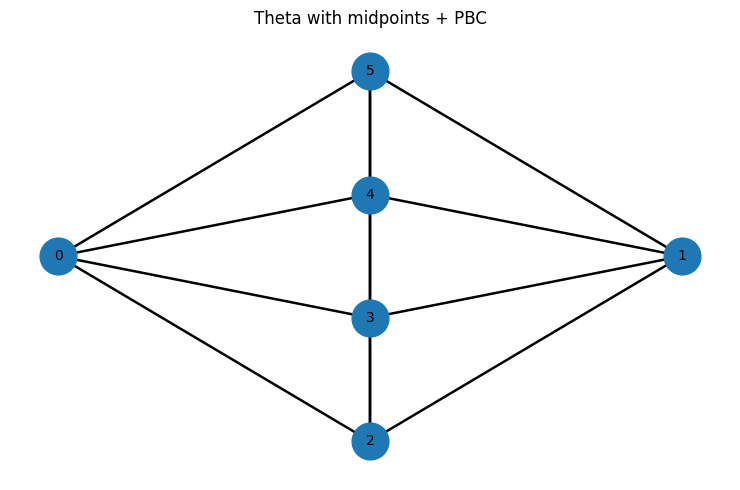

In [56]:
import sympy as sp
import networkx as nx

# -----------------------
# 1) Deletion–contraction Yamada for an abstract MultiGraph
# -----------------------
def normalize_multigraph(G: nx.MultiGraph) -> nx.MultiGraph:
    nodes = sorted(G.nodes())
    mapping = {n: i for i, n in enumerate(nodes)}
    H = nx.MultiGraph()
    H.add_nodes_from(range(len(nodes)))
    for u, v, k in G.edges(keys=True):
        H.add_edge(mapping[u], mapping[v])
    return H

def graph_key(G: nx.MultiGraph):
    G = normalize_multigraph(G)
    edges = []
    for u, v, k in G.edges(keys=True):
        a, b = (u, v) if u <= v else (v, u)
        edges.append((a, b))
    edges.sort()
    return (G.number_of_nodes(), tuple(edges))

def components_ignoring_loops(G: nx.MultiGraph):
    # connectivity comes only from non-loop edges
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    for u, v in G.edges():
        if u != v:
            H.add_edge(u, v)
    return list(nx.connected_components(H))

def contract_one_edge(G: nx.MultiGraph, u, v, k) -> nx.MultiGraph:
    """
    Contract ONE chosen edge occurrence (u,v,k) by merging v into u.
    Preserves multiplicity and turns parallel u-v edges into loops at u.
    """
    H = G.copy()
    H.remove_edge(u, v, k)

    incident = list(H.edges(v, keys=True, data=True))
    H.remove_node(v)

    # reattach all edges formerly incident to v onto u
    for a, b, kk, data in incident:
        other = b if a == v else a
        aa = u
        bb = u if other == v else other
        H.add_edge(aa, bb, **data)

    return H

def yamada_dc_multigraph(G: nx.MultiGraph, Y: sp.Symbol):
    """
    Computes a Yamada-style polynomial using:
      - R(G) = R(G - e) + R(G / e) for a non-loop edge e
      - disjoint union multiplicativity
      - bouquet base case: single vertex with n loops => R = -(-sigma)^n
      - empty graph => 1

    This is the same DC “shape” you used in your PD/DC script. :contentReference[oaicite:1]{index=1}
    """
    sigma = Y + 1 + Y**(-1)
    memo = {}

    def rec(H: nx.MultiGraph):
        H = normalize_multigraph(H)
        key = graph_key(H)
        if key in memo:
            return memo[key]

        nV, nE = H.number_of_nodes(), H.number_of_edges()

        # empty graph
        if nV == 0 and nE == 0:
            memo[key] = sp.Integer(1)
            return memo[key]

        # disjoint union => product of components
        comps = components_ignoring_loops(H)
        if len(comps) > 1:
            val = sp.Integer(1)
            for comp in comps:
                val *= rec(H.subgraph(comp).copy())
            memo[key] = sp.simplify(val)
            return memo[key]

        # connected case: if no non-loop edges, must be a bouquet (single vertex with loops)
        nonloop = [(u, v, kk) for u, v, kk in H.edges(keys=True) if u != v]
        if not nonloop:
            if nV == 1:
                loops = sum(1 for u, v, kk in H.edges(keys=True) if u == v == 0)
                val = -((-sigma) ** loops)
            else:
                # should not happen with the component logic, but keep safe
                val = sp.Integer(0)
            memo[key] = sp.simplify(val)
            return memo[key]

        # pick one non-loop edge occurrence
        u, v, kk = nonloop[0]

        # deletion
        H_del = H.copy()
        H_del.remove_edge(u, v, kk)

        # contraction
        H_con = contract_one_edge(H, u, v, kk)

        val = sp.simplify(rec(H_del) + rec(H_con))
        memo[key] = val
        return memo[key]

    return sp.simplify(rec(G))


# -----------------------
# 2) Compare: Yamada module vs deletion–contraction for your construction
# -----------------------
def compute_theta_mid_pbc_both(s: int, normalize_module: bool = False):
    # uses your function exactly as you wrote it
    yam, G, pos = theta_s_with_mid_connections_pbc(s)

    Y = sp.Symbol("Y")
    R_module = sp.simplify(yam.compute(Y, normalize=normalize_module, n_jobs=-1))
    R_dc     = sp.simplify(yamada_dc_multigraph(G, Y))

    print(f"s = {s}")
    print("\n[Yamada module]")
    print(R_module)
    print("\n[Deletion–contraction]")
    print(R_dc)

    diff = sp.simplify(R_module - R_dc)
    print("\n[Difference module - DC] (expect 0 if conventions match)")
    print(diff)

    return R_module, R_dc, diff, G, pos


# -----------------------
# 3) Example usage
# -----------------------
Rm, Rd, diff, G, pos = compute_theta_mid_pbc_both(4, normalize_module=False)
plot_multigraph_pbc_curved(G, pos, title="Theta with midpoints + PBC")


In [62]:

# -----------------------
# 2) Compare: Yamada module vs deletion–contraction for your construction
# -----------------------
def compute_theta_mid_pbc_module(s: int, normalize_module: bool = False):
    # uses your function exactly as you wrote it
    yam, G, pos = theta_s_with_mid_connections_pbc(s)

    Y = sp.Symbol("Y")
    R_module = sp.simplify(yam.compute(Y, normalize=normalize_module, n_jobs=-1)) 

    print(f"s = {s}")
    print("\n[Yamada module]")
    print(R_module) 
  
    return R_module,  G, pos

# -----------------------
def compute_theta_mid_pbc_both(s: int, normalize_module: bool = False):
    # uses your function exactly as you wrote it
    yam, G, pos = theta_s_with_mid_connections_pbc(s)

    Y = sp.Symbol("Y")
    R_module = sp.simplify(yam.compute(Y, normalize=normalize_module, n_jobs=-1))
    R_dc     = sp.simplify(yamada_dc_multigraph(G, Y))

    print(f"s = {s}")
    print("\n[Yamada module]")
    print(R_module)
    print("\n[Deletion–contraction]")
    print(R_dc)

    diff = sp.simplify(R_module - R_dc)
    print("\n[Difference module - DC] (expect 0 if conventions match)")
    print(diff)

    return R_module, R_dc, diff, G, pos

# -----------------------
# 3) Example usage
# -----------------------
Rm ,R_dc,  G, pos = compute_theta_mid_pbc_both(4, normalize_module=False)
plot_multigraph_pbc_curved(G, pos, title="Theta with midpoints + PBC")


s = 4

[Yamada module]
Y**7 + 2*Y**6 + 13*Y**5 + 18*Y**4 + 60*Y**3 + 64*Y**2 + 125*Y + 97 + 125/Y + 64/Y**2 + 60/Y**3 + 18/Y**4 + 13/Y**5 + 2/Y**6 + Y**(-7)

[Deletion–contraction]
Y**7 + 2*Y**6 + 13*Y**5 + 18*Y**4 + 60*Y**3 + 64*Y**2 + 125*Y + 97 + 125/Y + 64/Y**2 + 60/Y**3 + 18/Y**4 + 13/Y**5 + 2/Y**6 + Y**(-7)

[Difference module - DC] (expect 0 if conventions match)
0


ValueError: too many values to unpack (expected 4)

In [37]:
Rm

-Y**2 - Y - 2 - 1/Y - 1/Y**2

In [40]:
sp.simplify(Rd-Rm)

0

In [ ]:
Rd

In [66]:

sigma = Y + 1 + Y**(-1)
s=2
theta= (sigma + (-sigma)**s)/(sigma + 1)

Analytic=-theta**2+sigma
sp.simplify(Analytic)

-Y**2 - Y - 2 - 1/Y - 1/Y**2

In [67]:
sp.simplify(Analytic-Rm)

0

In [68]:
Rm

-Y**2 - Y - 2 - 1/Y - 1/Y**2

In [19]:
import sympy as sp
import networkx as nx
from collections import defaultdict

class YamadaDCSolverFast:
    """
    Yamada polynomial for crossing-free abstract MultiGraphs, matching the same
    DC + axioms you are using in your reference scripts:
      - empty graph -> 1
      - disjoint union -> product
      - bouquet B_n -> -(-sigma)^n
      - theta T_s -> (sigma + (-sigma)^s)/(sigma+1)
      - wedge (1-vertex join) -> (-1)^(k-1) * product
      - otherwise: deletion–contraction on a non-loop edge
    """
    def __init__(self, Y: sp.Symbol):
        self.Y = Y
        self.sigma = Y + 1 + Y**(-1)

        # bucketed iso-cache: sig -> [(canon_graph, value), ...]
        self.cache = defaultdict(list)
        self.cache_hits = 0
        self.cache_misses = 0

    # ---------- helpers: canon + invariants ----------
    @staticmethod
    def _canon(G: nx.MultiGraph) -> nx.MultiGraph:
        return nx.convert_node_labels_to_integers(G, ordering="sorted")

    @staticmethod
    def _invariants(G: nx.MultiGraph):
        n = G.number_of_nodes()
        m = G.number_of_edges()
        deg = tuple(sorted(d for _, d in G.degree()))
        loops = tuple(sorted(G.number_of_edges(u, u) for u in G.nodes()))
        # add a tiny bit more structure to bucket better:
        # multiset of edge endpoint degrees (helps reduce iso checks)
        edeg = []
        for u, v, k in G.edges(keys=True):
            du = G.degree(u)
            dv = G.degree(v)
            edeg.append(tuple(sorted((du, dv))))
        edeg = tuple(sorted(edeg))
        return (n, m, deg, loops, edeg)

    def _cache_get(self, G: nx.MultiGraph):
        sig = self._invariants(G)
        for H, val in self.cache[sig]:
            if nx.is_isomorphic(G, H):
                self.cache_hits += 1
                return val
        self.cache_misses += 1
        return None

    def _cache_set(self, G: nx.MultiGraph, val):
        sig = self._invariants(G)
        self.cache[sig].append((self._canon(G), val))

    # ---------- recognizers ----------
    @staticmethod
    def _is_bouquet(G: nx.MultiGraph) -> bool:
        if G.number_of_nodes() != 1:
            return False
        return all(u == v for u, v, k in G.edges(keys=True))

    @staticmethod
    def _bouquet_nloops(G: nx.MultiGraph) -> int:
        # assumes bouquet
        return sum(1 for u, v, k in G.edges(keys=True) if u == v)

    @staticmethod
    def _is_theta(G: nx.MultiGraph) -> bool:
        if G.number_of_nodes() != 2:
            return False
        nodes = list(G.nodes())
        a, b = nodes[0], nodes[1]
        for u, v, k in G.edges(keys=True):
            if u == v:
                return False
            if set((u, v)) != set((a, b)):
                return False
        return True

    @staticmethod
    def _theta_s(G: nx.MultiGraph) -> int:
        return G.number_of_edges()

    # ---------- graph decompositions ----------
    @staticmethod
    def _connected_components_as_subgraphs(G: nx.MultiGraph):
        comps = []
        for nodes in nx.connected_components(G.to_undirected()):
            comps.append(G.subgraph(nodes).copy())
        return comps

    @staticmethod
    def _articulation_vertices_simple(G: nx.MultiGraph):
        # articulation points in underlying simple graph (ignore multiplicity/loops)
        SG = nx.Graph()
        SG.add_nodes_from(G.nodes())
        for u, v, k in G.edges(keys=True):
            if u != v:
                SG.add_edge(u, v)
        return list(nx.articulation_points(SG))

    def _wedge_decompose(self, G: nx.MultiGraph):
        """
        If connected and has a cut-vertex v, decompose into factors (1-sum along v).
        Returns (v, [G1,...,Gk]) or None.
        """
        if not nx.is_connected(G.to_undirected()):
            return None

        cvs = self._articulation_vertices_simple(G)
        if not cvs:
            return None

        # underlying simple graph once
        SG = nx.Graph()
        SG.add_nodes_from(G.nodes())
        for u, v, k in G.edges(keys=True):
            if u != v:
                SG.add_edge(u, v)

        best_v, best_parts, best_k = None, None, 0
        for v in cvs:
            H = SG.copy()
            H.remove_node(v)
            parts = list(nx.connected_components(H))
            if len(parts) >= 2 and len(parts) > best_k:
                best_k = len(parts)
                best_v = v
                best_parts = parts

        if best_v is None:
            return None

        factors = []
        for part in best_parts:
            nodes = set(part) | {best_v}
            factors.append(G.subgraph(nodes).copy())

        return best_v, factors

    # ---------- DC ops ----------
    @staticmethod
    def _pick_nonloop_edge(G: nx.MultiGraph):
        for u, v, k in G.edges(keys=True):
            if u != v:
                return (u, v, k)
        return None

    @staticmethod
    def _delete_edge(G: nx.MultiGraph, e):
        u, v, k = e
        H = G.copy()
        H.remove_edge(u, v, k)
        return H

    @staticmethod
    def _contract_edge(G: nx.MultiGraph, e):
        """
        Contract a non-loop edge (u,v,k) by merging v into u.
        Multi-edges and loops are preserved.
        """
        u, v, k = e
        if u == v:
            raise ValueError("Loop contraction not allowed.")

        H = G.copy()
        H.remove_edge(u, v, k)

        incident = list(H.edges(v, keys=True, data=True))
        H.remove_node(v)

        for a, b, kk, data in incident:
            other = b if a == v else a
            new_a = u
            new_b = u if other == v else other
            H.add_edge(new_a, new_b, **data)

        return H

    # ---------- main compute ----------
    def compute(self, G: nx.MultiGraph):
        G = self._canon(G)

        hit = self._cache_get(G)
        if hit is not None:
            return hit

        # (VI) empty graph
        if G.number_of_nodes() == 0:
            val = sp.Integer(1)
            self._cache_set(G, val)
            return val

        # (III) disjoint union
        comps = self._connected_components_as_subgraphs(G)
        if len(comps) > 1:
            prod = sp.Integer(1)
            for c in comps:
                prod *= self.compute(c)
            val = sp.simplify(prod)
            self._cache_set(G, val)
            return val

        # bouquet shortcut: R(B_n) = -(-sigma)^n  (so B_0 = -1)
        if self._is_bouquet(G):
            n = self._bouquet_nloops(G)
            val = sp.simplify(-((-self.sigma) ** n))
            self._cache_set(G, val)
            return val

        # theta shortcut: R(T_s) = (sigma + (-sigma)^s)/(sigma+1)
        if self._is_theta(G):
            s = self._theta_s(G)
            val = sp.simplify((self.sigma + (-self.sigma) ** s) / (self.sigma + 1))
            self._cache_set(G, val)
            return val

        # (IV) wedge / 1-vertex join shortcut
        wd = self._wedge_decompose(G)
        if wd is not None:
            v, factors = wd
            k = len(factors)
            expr = (-1) ** (k - 1)
            for f in factors:
                expr *= self.compute(f)
            val = sp.simplify(expr)
            self._cache_set(G, val)
            return val

        # (II) deletion–contraction
        e = self._pick_nonloop_edge(G)
        if e is None:
            # should not happen for connected non-bouquet graphs; safe fallback
            val = sp.Integer(0)
            self._cache_set(G, val)
            return val

        val = sp.simplify(self.compute(self._delete_edge(G, e)) + self.compute(self._contract_edge(G, e)))
        self._cache_set(G, val)
        return val


# -----------------------
# Compare against your module, reusing cache from s=1..S_max
# (Assumes you already defined theta_s_with_mid_connections_pbc)
# -----------------------
def compute_family_dc_up_to(S_max: int, normalize_module: bool = False):
    Y = sp.Symbol("Y")
    solver = YamadaDCSolverFast(Y)

    results = {}
    for s in range(1, S_max + 1):
        yam, G, pos = theta_s_with_mid_connections_pbc(s)

        R_mod = sp.simplify(yam.compute(Y, normalize=normalize_module, n_jobs=-1))
        R_dc  = sp.simplify(solver.compute(G))
        diff  = sp.simplify(R_mod - R_dc)

        print(f"\n=== s={s} ===")
        print("module:", R_mod)
        print("DC    :", R_dc)
        print("diff  :", diff)
        print(f"cache hits/misses: {solver.cache_hits}/{solver.cache_misses}")

        results[s] = (R_mod, R_dc, diff)

    return results, solver


# Example:
results, solver = compute_family_dc_up_to(4, normalize_module=False)



=== s=1 ===
module: 0
DC    : 0
diff  : 0
cache hits/misses: 1/2

=== s=2 ===
module: -Y**2 - Y - 2 - 1/Y - 1/Y**2
DC    : Y + 1 + 1/Y - (Y**2 + Y + 1)**2/Y**2
diff  : 0
cache hits/misses: 5/13

=== s=3 ===
module: Y**5 + Y**4 + 7*Y**3 + 5*Y**2 + 15*Y + 8 + 15/Y + 5/Y**2 + 7/Y**3 + Y**(-4) + Y**(-5)
DC    : Y**5 + Y**4 + 7*Y**3 + 5*Y**2 + 15*Y + 8 + 15/Y + 5/Y**2 + 7/Y**3 + Y**(-4) + Y**(-5)
diff  : 0
cache hits/misses: 23/36

=== s=4 ===
module: Y**7 + 2*Y**6 + 13*Y**5 + 18*Y**4 + 60*Y**3 + 64*Y**2 + 125*Y + 97 + 125/Y + 64/Y**2 + 60/Y**3 + 18/Y**4 + 13/Y**5 + 2/Y**6 + Y**(-7)
DC    : Y**7 + 2*Y**6 + 13*Y**5 + 18*Y**4 + 60*Y**3 + 64*Y**2 + 125*Y + 97 + 125/Y + 64/Y**2 + 60/Y**3 + 18/Y**4 + 13/Y**5 + 2/Y**6 + Y**(-7)
diff  : 0
cache hits/misses: 56/72


In [20]:
def compute_family_dc_up_to(S_max: int, normalize_module: bool = False):
    Y = sp.Symbol("Y")
    solver = YamadaDCSolverFast(Y)

    results = {}
    for s in range(1, S_max + 1):
        yam, G, pos = theta_s_with_mid_connections_pbc(s)
 
        R_dc  = sp.simplify(solver.compute(G)) 
        print(f"\n=== s={s} ===") 
        print("DC    :", R_dc)  

        results[s] = R_dc

    return results, solver

results, solver = compute_family_dc_up_to(12, normalize_module=False)



=== s=1 ===
DC    : 0

=== s=2 ===
DC    : Y + 1 + 1/Y - (Y**2 + Y + 1)**2/Y**2

=== s=3 ===
DC    : Y**5 + Y**4 + 7*Y**3 + 5*Y**2 + 15*Y + 8 + 15/Y + 5/Y**2 + 7/Y**3 + Y**(-4) + Y**(-5)

=== s=4 ===
DC    : Y**7 + 2*Y**6 + 13*Y**5 + 18*Y**4 + 60*Y**3 + 64*Y**2 + 125*Y + 97 + 125/Y + 64/Y**2 + 60/Y**3 + 18/Y**4 + 13/Y**5 + 2/Y**6 + Y**(-7)

=== s=5 ===
DC    : 6*Y**9 + 43*Y**8 + 210*Y**7 + 678*Y**6 + 1777*Y**5 + 3626*Y**4 + 6364*Y**3 + 9177*Y**2 + 11635*Y + 12372 + 11635/Y + 9177/Y**2 + 6364/Y**3 + 3626/Y**4 + 1777/Y**5 + 678/Y**6 + 210/Y**7 + 43/Y**8 + 6/Y**9

=== s=6 ===
DC    : 9*Y**13 + 108*Y**12 + 730*Y**11 + 3446*Y**10 + 12629*Y**9 + 37682*Y**8 + 94742*Y**7 + 204542*Y**6 + 385397*Y**5 + 639291*Y**4 + 941968*Y**3 + 1237419*Y**2 + 1456431*Y + 1536653 + 1456431/Y + 1237419/Y**2 + 941968/Y**3 + 639291/Y**4 + 385397/Y**5 + 204542/Y**6 + 94742/Y**7 + 37682/Y**8 + 12629/Y**9 + 3446/Y**10 + 730/Y**11 + 108/Y**12 + 9/Y**13

=== s=7 ===
DC    : 14*Y**17 + 217*Y**16 + 1850*Y**15 + 11074*Y*

In [50]:
Results="""
=== s=1 ===
DC    : 0

=== s=2 ===
DC    : Y + 1 + 1/Y - (Y**2 + Y + 1)**2/Y**2

=== s=3 ===
DC    : Y**5 + Y**4 + 7*Y**3 + 5*Y**2 + 15*Y + 8 + 15/Y + 5/Y**2 + 7/Y**3 + Y**(-4) + Y**(-5)

=== s=4 ===
DC    : Y**7 + 2*Y**6 + 13*Y**5 + 18*Y**4 + 60*Y**3 + 64*Y**2 + 125*Y + 97 + 125/Y + 64/Y**2 + 60/Y**3 + 18/Y**4 + 13/Y**5 + 2/Y**6 + Y**(-7)

=== s=5 ===
DC    : 6*Y**9 + 43*Y**8 + 210*Y**7 + 678*Y**6 + 1777*Y**5 + 3626*Y**4 + 6364*Y**3 + 9177*Y**2 + 11635*Y + 12372 + 11635/Y + 9177/Y**2 + 6364/Y**3 + 3626/Y**4 + 1777/Y**5 + 678/Y**6 + 210/Y**7 + 43/Y**8 + 6/Y**9

=== s=6 ===
DC    : 9*Y**13 + 108*Y**12 + 730*Y**11 + 3446*Y**10 + 12629*Y**9 + 37682*Y**8 + 94742*Y**7 + 204542*Y**6 + 385397*Y**5 + 639291*Y**4 + 941968*Y**3 + 1237419*Y**2 + 1456431*Y + 1536653 + 1456431/Y + 1237419/Y**2 + 941968/Y**3 + 639291/Y**4 + 385397/Y**5 + 204542/Y**6 + 94742/Y**7 + 37682/Y**8 + 12629/Y**9 + 3446/Y**10 + 730/Y**11 + 108/Y**12 + 9/Y**13

=== s=7 ===
DC    : 14*Y**17 + 217*Y**16 + 1850*Y**15 + 11074*Y**14 + 51556*Y**13 + 196836*Y**12 + 637063*Y**11 + 1786475*Y**10 + 4408918*Y**9 + 9685113*Y**8 + 19101266*Y**7 + 34043358*Y**6 + 55110132*Y**5 + 81344882*Y**4 + 109807211*Y**3 + 135848461*Y**2 + 154264733*Y + 160924640 + 154264733/Y + 135848461/Y**2 + 109807211/Y**3 + 81344882/Y**4 + 55110132/Y**5 + 34043358/Y**6 + 19101266/Y**7 + 9685113/Y**8 + 4408918/Y**9 + 1786475/Y**10 + 637063/Y**11 + 196836/Y**12 + 51556/Y**13 + 11074/Y**14 + 1850/Y**15 + 217/Y**16 + 14/Y**17

=== s=8 ===
DC    : -16*Y**22 - 316*Y**21 - 3312*Y**20 - 24014*Y**19 - 134052*Y**18 - 609997*Y**17 - 2344602*Y**16 - 7797713*Y**15 - 22834279*Y**14 - 59654108*Y**13 - 140476212*Y**12 - 300669584*Y**11 - 588987443*Y**10 - 1062224641*Y**9 - 1772825817*Y**8 - 2750837803*Y**7 - 3985161319*Y**6 - 5411181046*Y**5 - 6911041501*Y**4 - 8328606492*Y**3 - 9496025044*Y**2 - 10264664417*Y - 10532901493 - 10264664417/Y - 9496025044/Y**2 - 8328606492/Y**3 - 6911041501/Y**4 - 5411181046/Y**5 - 3985161319/Y**6 - 2750837803/Y**7 - 1772825817/Y**8 - 1062224641/Y**9 - 588987443/Y**10 - 300669584/Y**11 - 140476212/Y**12 - 59654108/Y**13 - 22834279/Y**14 - 7797713/Y**15 - 2344602/Y**16 - 609997/Y**17 - 134052/Y**18 - 24014/Y**19 - 3312/Y**20 - 316/Y**21 - 16/Y**22

=== s=9 ===
DC    : -30*Y**28 - 810*Y**27 - 11370*Y**26 - 109495*Y**25 - 808620*Y**24 - 4862174*Y**23 - 24708515*Y**22 - 108843201*Y**21 - 423289757*Y**20 - 1473461155*Y**19 - 4640425134*Y**18 - 13335404315*Y**17 - 35212940349*Y**16 - 85928988478*Y**15 - 194717288487*Y**14 - 411395304132*Y**13 - 813214082873*Y**12 - 1508433415651*Y**11 - 2632250386958*Y**10 - 4330700234781*Y**9 - 6730319627229*Y**8 - 9895994950517*Y**7 - 13785557909437*Y**6 - 18215046384377*Y**5 - 22850187284763*Y**4 - 27235386856504*Y**3 - 30861349668216*Y**2 - 33259271931702*Y - 34098364729516 - 33259271931702/Y - 30861349668216/Y**2 - 27235386856504/Y**3 - 22850187284763/Y**4 - 18215046384377/Y**5 - 13785557909437/Y**6 - 9895994950517/Y**7 - 6730319627229/Y**8 - 4330700234781/Y**9 - 2632250386958/Y**10 - 1508433415651/Y**11 - 813214082873/Y**12 - 411395304132/Y**13 - 194717288487/Y**14 - 85928988478/Y**15 - 35212940349/Y**16 - 13335404315/Y**17 - 4640425134/Y**18 - 1473461155/Y**19 - 423289757/Y**20 - 108843201/Y**21 - 24708515/Y**22 - 4862174/Y**23 - 808620/Y**24 - 109495/Y**25 - 11370/Y**26 - 810/Y**27 - 30/Y**28

=== s=10 ===
DC    : -50*Y**34 - 1625*Y**33 - 27300*Y**32 - 313840*Y**31 - 2763700*Y**30 - 19811795*Y**29 - 120078166*Y**28 - 631408050*Y**27 - 2934615501*Y**26 - 12226108559*Y**25 - 46161006851*Y**24 - 159335426612*Y**23 - 506406656249*Y**22 - 1490758701728*Y**21 - 4085050935565*Y**20 - 10464228471215*Y**19 - 25148569779987*Y**18 - 56882564619792*Y**17 - 121420307034656*Y**16 - 245181361138989*Y**15 - 469330313973867*Y**14 - 853231454482977*Y**13 - 1475568659277058*Y**12 - 2430972778443929*Y**11 - 3820133439602414*Y**10 - 5732417577510269*Y**9 - 8222060021008979*Y**8 - 11281694717856719*Y**7 - 14819549914969789*Y**6 - 18647938290210190*Y**5 - 22489752933280629*Y**4 - 26006167721933858*Y**3 - 28843242735335014*Y**2 - 30689214968786863*Y - 31329962130097073 - 30689214968786863/Y - 28843242735335014/Y**2 - 26006167721933858/Y**3 - 22489752933280629/Y**4 - 18647938290210190/Y**5 - 14819549914969789/Y**6 - 11281694717856719/Y**7 - 8222060021008979/Y**8 - 5732417577510269/Y**9 - 3820133439602414/Y**10 - 2430972778443929/Y**11 - 1475568659277058/Y**12 - 853231454482977/Y**13 - 469330313973867/Y**14 - 245181361138989/Y**15 - 121420307034656/Y**16 - 56882564619792/Y**17 - 25148569779987/Y**18 - 10464228471215/Y**19 - 4085050935565/Y**20 - 1490758701728/Y**21 - 506406656249/Y**22 - 159335426612/Y**23 - 46161006851/Y**24 - 12226108559/Y**25 - 2934615501/Y**26 - 631408050/Y**27 - 120078166/Y**28 - 19811795/Y**29 - 2763700/Y**30 - 313840/Y**31 - 27300/Y**32 - 1625/Y**33 - 50/Y**34

=== s=11 ===
DC    : 55*Y**41 + 2123*Y**40 + 42152*Y**39 + 571263*Y**38 + 5924346*Y**37 + 50012652*Y**36 + 357213179*Y**35 + 2216254913*Y**34 + 12173876732*Y**33 + 60061831012*Y**32 + 269149938781*Y**31 + 1105358617631*Y**30 + 4190759768814*Y**29 + 14756576284072*Y**28 + 48504494181139*Y**27 + 149467951575212*Y**26 + 433392492142310*Y**25 + 1186205689040123*Y**24 + 3073128695717211*Y**23 + 7554207273589548*Y**22 + 17656387251724015*Y**21 + 39312269919303201*Y**20 + 83518527757430684*Y**19 + 169550988018389310*Y**18 + 329340142833542668*Y**17 + 612799420558296016*Y**16 + 1093375996059801933*Y**15 + 1872398285044789991*Y**14 + 3080075891704368836*Y**13 + 4870543140708389663*Y**12 + 7408486795349925531*Y**11 + 10845992085862475578*Y**10 + 15290407385804782102*Y**9 + 20767023851667668255*Y**8 + 27183496583341712516*Y**7 + 34305143539773102420*Y**6 + 41750431875329964747*Y**5 + 49013362160129825532*Y**4 + 55514153836830314398*Y**3 + 60672686029054933826*Y**2 + 63992448500716783986*Y + 65138467690387285666 + 63992448500716783986/Y + 60672686029054933826/Y**2 + 55514153836830314398/Y**3 + 49013362160129825532/Y**4 + 41750431875329964747/Y**5 + 34305143539773102420/Y**6 + 27183496583341712516/Y**7 + 20767023851667668255/Y**8 + 15290407385804782102/Y**9 + 10845992085862475578/Y**10 + 7408486795349925531/Y**11 + 4870543140708389663/Y**12 + 3080075891704368836/Y**13 + 1872398285044789991/Y**14 + 1093375996059801933/Y**15 + 612799420558296016/Y**16 + 329340142833542668/Y**17 + 169550988018389310/Y**18 + 83518527757430684/Y**19 + 39312269919303201/Y**20 + 17656387251724015/Y**21 + 7554207273589548/Y**22 + 3073128695717211/Y**23 + 1186205689040123/Y**24 + 433392492142310/Y**25 + 149467951575212/Y**26 + 48504494181139/Y**27 + 14756576284072/Y**28 + 4190759768814/Y**29 + 1105358617631/Y**30 + 269149938781/Y**31 + 60061831012/Y**32 + 12173876732/Y**33 + 2216254913/Y**34 + 357213179/Y**35 + 50012652/Y**36 + 5924346/Y**37 + 571263/Y**38 + 42152/Y**39 + 2123/Y**40 + 55/Y**41

=== s=12 ===
DC    : 105*Y**49 + 5040*Y**48 + 123585*Y**47 + 2057852*Y**46 + 26114814*Y**45 + 268881608*Y**44 + 2335878455*Y**43 + 17586369042*Y**42 + 116993112930*Y**41 + 697864528470*Y**40 + 3775575865742*Y**39 + 18697434849330*Y**38 + 85393836420775*Y**37 + 361931573238234*Y**36 + 1431089180337163*Y**35 + 5302694023297269*Y**34 + 18484002707869380*Y**33 + 60817056530750474*Y**32 + 189436497796243661*Y**31 + 560064756713746712*Y**30 + 1575247138287290923*Y**29 + 4223627182786432052*Y**28 + 10815479786449277509*Y**27 + 26493855988660449846*Y**26 + 62176868158845794505*Y**25 + 139984471395441256683*Y**24 + 302709793598158632705*Y**23 + 629431152331412054715*Y**22 + 1259740903360141995677*Y**21 + 2428972095564448889976*Y**20 + 4515792520822454761427*Y**19 + 8101129167659654920844*Y**18 + 14033247214014801898977*Y**17 + 23488008560442279514540*Y**16 + 38006648956578045550457*Y**15 + 59487508032904543819723*Y**14 + 90105516446357047446487*Y**13 + 132136734927636525517292*Y**12 + 187677142855323150227940*Y**11 + 258265746652127892083299*Y**10 + 344449671057965104876674*Y**9 + 445357702499690161844268*Y**8 + 558370652136871093051183*Y**7 + 678983068160723188575322*Y**6 + 800934567687202071714809*Y**5 + 916648789871718899808358*Y**4 + 1017959110989335739306714*Y**3 + 1097035074978921967360100*Y**2 + 1147368457176256317222219*Y + 1164649080307012597807457 + 1147368457176256317222219/Y + 1097035074978921967360100/Y**2 + 1017959110989335739306714/Y**3 + 916648789871718899808358/Y**4 + 800934567687202071714809/Y**5 + 678983068160723188575322/Y**6 + 558370652136871093051183/Y**7 + 445357702499690161844268/Y**8 + 344449671057965104876674/Y**9 + 258265746652127892083299/Y**10 + 187677142855323150227940/Y**11 + 132136734927636525517292/Y**12 + 90105516446357047446487/Y**13 + 59487508032904543819723/Y**14 + 38006648956578045550457/Y**15 + 23488008560442279514540/Y**16 + 14033247214014801898977/Y**17 + 8101129167659654920844/Y**18 + 4515792520822454761427/Y**19 + 2428972095564448889976/Y**20 + 1259740903360141995677/Y**21 + 629431152331412054715/Y**22 + 302709793598158632705/Y**23 + 139984471395441256683/Y**24 + 62176868158845794505/Y**25 + 26493855988660449846/Y**26 + 10815479786449277509/Y**27 + 4223627182786432052/Y**28 + 1575247138287290923/Y**29 + 560064756713746712/Y**30 + 189436497796243661/Y**31 + 60817056530750474/Y**32 + 18484002707869380/Y**33 + 5302694023297269/Y**34 + 1431089180337163/Y**35 + 361931573238234/Y**36 + 85393836420775/Y**37 + 18697434849330/Y**38 + 3775575865742/Y**39 + 697864528470/Y**40 + 116993112930/Y**41 + 17586369042/Y**42 + 2335878455/Y**43 + 268881608/Y**44 + 26114814/Y**45 + 2057852/Y**46 + 123585/Y**47 + 5040/Y**48 + 105/Y**49

=== s=13 ===
DC    : 182*Y**57 + 10101*Y**56 + 285649*Y**55 + 5475561*Y**54 + 79890853*Y**53 + 944905533*Y**52 + 9424324394*Y**51 + 81435010291*Y**50 + 621698585590*Y**49 + 4255963973006*Y**48 + 26430301519659*Y**47 + 150290628553742*Y**46 + 788485710938082*Y**45 + 3840964610032908*Y**44 + 17466057173897128*Y**43 + 74480489340631683*Y**42 + 299017334517599188*Y**41 + 1134091304794128066*Y**40 + 4075737893932769590*Y**39 + 13916407843036935471*Y**38 + 45252030370451679060*Y**37 + 140428989432007088660*Y**36 + 416684128322397220395*Y**35 + 1184216266510496480506*Y**34 + 3228498248699903084927*Y**33 + 8455224134747973782809*Y**32 + 21299020931942160051196*Y**31 + 51666683557903542530072*Y**30 + 120820692003264724609928*Y**29 + 272631865898784245567445*Y**28 + 594164330057362546498580*Y**27 + 1251670457336082631101825*Y**26 + 2550687989130544614201410*Y**25 + 5031682475432497591369574*Y**24 + 9614766971937494796109801*Y**23 + 17807110455039236845662816*Y**22 + 31982835076091380091679425*Y**21 + 55735337287356544314978406*Y**20 + 94284191488657116526921739*Y**19 + 154892490718731634911668362*Y**18 + 247217422995357736975667621*Y**17 + 383482279405549988516496661*Y**16 + 578330990038749740360719347*Y**15 + 848218805423932084541594582*Y**14 + 1210217710410486416326740309*Y**13 + 1680182197905254865264413973*Y**12 + 2270331813517947922726058719*Y**11 + 2986450942539256244419619838*Y**10 + 3825059237024649363128555493*Y**9 + 4771031742363009727751175709*Y**8 + 5796205306658054222287939297*Y**7 + 6859462514730099900763814474*Y**6 + 7908619794249847294304152486*Y**5 + 8884174087475561421769305227*Y**4 + 9724625268445312334376891100*Y**3 + 10372757195595926836752399266*Y**2 + 10782007185885711917170472230*Y + 10921950078484121207208490490 + 10782007185885711917170472230/Y + 10372757195595926836752399266/Y**2 + 9724625268445312334376891100/Y**3 + 8884174087475561421769305227/Y**4 + 7908619794249847294304152486/Y**5 + 6859462514730099900763814474/Y**6 + 5796205306658054222287939297/Y**7 + 4771031742363009727751175709/Y**8 + 3825059237024649363128555493/Y**9 + 2986450942539256244419619838/Y**10 + 2270331813517947922726058719/Y**11 + 1680182197905254865264413973/Y**12 + 1210217710410486416326740309/Y**13 + 848218805423932084541594582/Y**14 + 578330990038749740360719347/Y**15 + 383482279405549988516496661/Y**16 + 247217422995357736975667621/Y**17 + 154892490718731634911668362/Y**18 + 94284191488657116526921739/Y**19 + 55735337287356544314978406/Y**20 + 31982835076091380091679425/Y**21 + 17807110455039236845662816/Y**22 + 9614766971937494796109801/Y**23 + 5031682475432497591369574/Y**24 + 2550687989130544614201410/Y**25 + 1251670457336082631101825/Y**26 + 594164330057362546498580/Y**27 + 272631865898784245567445/Y**28 + 120820692003264724609928/Y**29 + 51666683557903542530072/Y**30 + 21299020931942160051196/Y**31 + 8455224134747973782809/Y**32 + 3228498248699903084927/Y**33 + 1184216266510496480506/Y**34 + 416684128322397220395/Y**35 + 140428989432007088660/Y**36 + 45252030370451679060/Y**37 + 13916407843036935471/Y**38 + 4075737893932769590/Y**39 + 1134091304794128066/Y**40 + 299017334517599188/Y**41 + 74480489340631683/Y**42 + 17466057173897128/Y**43 + 3840964610032908/Y**44 + 788485710938082/Y**45 + 150290628553742/Y**46 + 26430301519659/Y**47 + 4255963973006/Y**48 + 621698585590/Y**49 + 81435010291/Y**50 + 9424324394/Y**51 + 944905533/Y**52 + 79890853/Y**53 + 5475561/Y**54 + 285649/Y**55 + 10101/Y**56 + 182/Y**57

=== s=14 ===
DC    : -196*Y**66 - 12446*Y**65 - 401800*Y**64 - 8777566*Y**63 - 145758340*Y**62 - 1960042994*Y**61 - 22208482744*Y**60 - 217873006302*Y**59 - 1887536966266*Y**58 - 14658639179870*Y**57 - 103248543189254*Y**56 - 665807802183666*Y**55 - 3961260608030742*Y**54 - 21883898060112312*Y**53 - 112869898112745201*Y**52 - 546019890157992322*Y**51 - 2487464228891765484*Y**50 - 10708820983238466069*Y**49 - 43701616967774431444*Y**48 - 169514035989278814434*Y**47 - 626495875708037715450*Y**46 - 2210942285514437434038*Y**45 - 7465026142622554123256*Y**44 - 24157212311595037667279*Y**43 - 75044700365953026396674*Y**42 - 224122449789227658556024*Y**41 - 644351550408078661409361*Y**40 - 1785519561038519050304857*Y**39 - 4774192584159447535788542*Y**38 - 12330484456403877729476245*Y**37 - 30790902027286711054626507*Y**36 - 74406903850158047022210580*Y**35 - 174145142511129474052709216*Y**34 - 395048517471790453056543822*Y**33 - 869243032570300933931514283*Y**32 - 1856408804554081437826557515*Y**31 - 3850511690651617458263056619*Y**30 - 7761201487400404724918315583*Y**29 - 15210456444619334536399607254*Y**28 - 28998828897880802026114979592*Y**27 - 53808624259487331429476790473*Y**26 - 97219177023977853543559328574*Y**25 - 171105512432753038286788810982*Y**24 - 293467632094868862840602113622*Y**23 - 490684270830300066806343451096*Y**22 - 800094745279589990279291018968*Y**21 - 1272683124525549317779128590729*Y**20 - 1975477389212699059029907554643*Y**19 - 2993102586253632337707660263852*Y**18 - 4427776249869549589993458899126*Y**17 - 6396954709593126348960786509556*Y**16 - 9027884828180223353032443591445*Y**15 - 12448535859977357079541257839078*Y**14 - 16774807218864525497963407974433*Y**13 - 22094518145834745674084650835226*Y**12 - 28449421955263152577189178095436*Y**11 - 35817235108355685617300745374736*Y**10 - 44096273209207237581912275705557*Y**9 - 53095571873107071057433556356920*Y**8 - 62533195549966400880771210405908*Y**7 - 72044725509201419727154850081279*Y**6 - 81202696539118029603592130646014*Y**5 - 89546166650753542698591328727083*Y**4 - 96617907606141718742993133563991*Y**3 - 102005212615039916404831629198274*Y**2 - 105379345799725922180369632929576*Y - 106528445844261673884069161683847 - 105379345799725922180369632929576/Y - 102005212615039916404831629198274/Y**2 - 96617907606141718742993133563991/Y**3 - 89546166650753542698591328727083/Y**4 - 81202696539118029603592130646014/Y**5 - 72044725509201419727154850081279/Y**6 - 62533195549966400880771210405908/Y**7 - 53095571873107071057433556356920/Y**8 - 44096273209207237581912275705557/Y**9 - 35817235108355685617300745374736/Y**10 - 28449421955263152577189178095436/Y**11 - 22094518145834745674084650835226/Y**12 - 16774807218864525497963407974433/Y**13 - 12448535859977357079541257839078/Y**14 - 9027884828180223353032443591445/Y**15 - 6396954709593126348960786509556/Y**16 - 4427776249869549589993458899126/Y**17 - 2993102586253632337707660263852/Y**18 - 1975477389212699059029907554643/Y**19 - 1272683124525549317779128590729/Y**20 - 800094745279589990279291018968/Y**21 - 490684270830300066806343451096/Y**22 - 293467632094868862840602113622/Y**23 - 171105512432753038286788810982/Y**24 - 97219177023977853543559328574/Y**25 - 53808624259487331429476790473/Y**26 - 28998828897880802026114979592/Y**27 - 15210456444619334536399607254/Y**28 - 7761201487400404724918315583/Y**29 - 3850511690651617458263056619/Y**30 - 1856408804554081437826557515/Y**31 - 869243032570300933931514283/Y**32 - 395048517471790453056543822/Y**33 - 174145142511129474052709216/Y**34 - 74406903850158047022210580/Y**35 - 30790902027286711054626507/Y**36 - 12330484456403877729476245/Y**37 - 4774192584159447535788542/Y**38 - 1785519561038519050304857/Y**39 - 644351550408078661409361/Y**40 - 224122449789227658556024/Y**41 - 75044700365953026396674/Y**42 - 24157212311595037667279/Y**43 - 7465026142622554123256/Y**44 - 2210942285514437434038/Y**45 - 626495875708037715450/Y**46 - 169514035989278814434/Y**47 - 43701616967774431444/Y**48 - 10708820983238466069/Y**49 - 2487464228891765484/Y**50 - 546019890157992322/Y**51 - 112869898112745201/Y**52 - 21883898060112312/Y**53 - 3961260608030742/Y**54 - 665807802183666/Y**55 - 103248543189254/Y**56 - 14658639179870/Y**57 - 1887536966266/Y**58 - 217873006302/Y**59 - 22208482744/Y**60 - 1960042994/Y**61 - 145758340/Y**62 - 8777566/Y**63 - 401800/Y**64 - 12446/Y**65 - 196/Y**66

=== s=15 ===
DC    : -378*Y**76 - 28350*Y**75 - 1077678*Y**74 - 27650110*Y**73 - 538097220*Y**72 - 8464452548*Y**71 - 112015007950*Y**70 - 1281745541234*Y**69 - 12937105031088*Y**68 - 116937840830267*Y**67 - 957871631404784*Y**66 - 7178521000638660*Y**65 - 49606167886383294*Y**64 - 318159092799745474*Y**63 - 1904407999877168870*Y**62 - 10689006686349887343*Y**61 - 56487772680947182230*Y**60 - 282074514866646946559*Y**59 - 1335155679893226358214*Y**58 - 6007164586369324331187*Y**57 - 25754701872225769046174*Y**56 - 105453536003991570885439*Y**55 - 413195847563649736526324*Y**54 - 1552139674505570664644187*Y**53 - 5598911979145367345595704*Y**52 - 19423587740971896764561364*Y**51 - 64894488115627065795328689*Y**50 - 209068822745668732303507444*Y**49 - 650250685033356585204692460*Y**48 - 1954566772404780149463992181*Y**47 - 5683704985929432047805276917*Y**46 - 16003892735693776125293666902*Y**45 - 43672314627909868017654049399*Y**44 - 115590174193526026333937591172*Y**43 - 296957301106653292840157831766*Y**42 - 741017343929034731668309229400*Y**41 - 1797245336480538643937033980888*Y**40 - 4239321930778304839763224692518*Y**39 - 9730706570430428485301460657148*Y**38 - 21746280115998322830861905499361*Y**37 - 47341039586904110132372658926749*Y**36 - 100440610001724108658530347076259*Y**35 - 207775348127698003163152770825173*Y**34 - 419251766833459414850095848709538*Y**33 - 825514134420212419133176788651400*Y**32 - 1586739020929574689423254025519681*Y**31 - 2978319286077461829263410595712346*Y**30 - 5460928073455817135328977847705262*Y**29 - 9784251491691368677539760762877006*Y**28 - 17134975072419618003740787516330635*Y**27 - 29339690882002556643725320481528590*Y**26 - 49131308343613537501841913888124430*Y**25 - 80482202209114898933007740290952669*Y**24 - 128997664439163164808313283346848037*Y**23 - 202348560670174307785160543254973833*Y**22 - 310702534605162900232234685691994379*Y**21 - 467090009291667203406507246900283712*Y**20 - 687617573075726168868708867885444786*Y**19 - 991421819426600227219160195168634826*Y**18 - 1400247488893242133968371064826918814*Y**17 - 1937541603392735768841093289962415990*Y**16 - 2626986168518724198837536775595411631*Y**15 - 3490449339343267704016554233328674222*Y**14 - 4545417622677616688861901992142724986*Y**13 - 5802072729723917825557934956713774527*Y**12 - 7260282725551628426726339637241429085*Y**11 - 8906869399231744056938788386265635044*Y**10 - 10713570849482777365780385090749738482*Y**9 - 12636120112788279804325153862085538377*Y**8 - 14614793527100564348656755520076322285*Y**7 - 16576643564995244568061428323117960284*Y**6 - 18439431069806316573332431499625326049*Y**5 - 20117036303930332487855089530298805534*Y**4 - 21525893235783760443700268941508104517*Y**3 - 22591798403268370977765364684008851222*Y**2 - 23256332848508873348731320285532308143*Y - 23482129992578444222944370349506420190 - 23256332848508873348731320285532308143/Y - 22591798403268370977765364684008851222/Y**2 - 21525893235783760443700268941508104517/Y**3 - 20117036303930332487855089530298805534/Y**4 - 18439431069806316573332431499625326049/Y**5 - 16576643564995244568061428323117960284/Y**6 - 14614793527100564348656755520076322285/Y**7 - 12636120112788279804325153862085538377/Y**8 - 10713570849482777365780385090749738482/Y**9 - 8906869399231744056938788386265635044/Y**10 - 7260282725551628426726339637241429085/Y**11 - 5802072729723917825557934956713774527/Y**12 - 4545417622677616688861901992142724986/Y**13 - 3490449339343267704016554233328674222/Y**14 - 2626986168518724198837536775595411631/Y**15 - 1937541603392735768841093289962415990/Y**16 - 1400247488893242133968371064826918814/Y**17 - 991421819426600227219160195168634826/Y**18 - 687617573075726168868708867885444786/Y**19 - 467090009291667203406507246900283712/Y**20 - 310702534605162900232234685691994379/Y**21 - 202348560670174307785160543254973833/Y**22 - 128997664439163164808313283346848037/Y**23 - 80482202209114898933007740290952669/Y**24 - 49131308343613537501841913888124430/Y**25 - 29339690882002556643725320481528590/Y**26 - 17134975072419618003740787516330635/Y**27 - 9784251491691368677539760762877006/Y**28 - 5460928073455817135328977847705262/Y**29 - 2978319286077461829263410595712346/Y**30 - 1586739020929574689423254025519681/Y**31 - 825514134420212419133176788651400/Y**32 - 419251766833459414850095848709538/Y**33 - 207775348127698003163152770825173/Y**34 - 100440610001724108658530347076259/Y**35 - 47341039586904110132372658926749/Y**36 - 21746280115998322830861905499361/Y**37 - 9730706570430428485301460657148/Y**38 - 4239321930778304839763224692518/Y**39 - 1797245336480538643937033980888/Y**40 - 741017343929034731668309229400/Y**41 - 296957301106653292840157831766/Y**42 - 115590174193526026333937591172/Y**43 - 43672314627909868017654049399/Y**44 - 16003892735693776125293666902/Y**45 - 5683704985929432047805276917/Y**46 - 1954566772404780149463992181/Y**47 - 650250685033356585204692460/Y**48 - 209068822745668732303507444/Y**49 - 64894488115627065795328689/Y**50 - 19423587740971896764561364/Y**51 - 5598911979145367345595704/Y**52 - 1552139674505570664644187/Y**53 - 413195847563649736526324/Y**54 - 105453536003991570885439/Y**55 - 25754701872225769046174/Y**56 - 6007164586369324331187/Y**57 - 1335155679893226358214/Y**58 - 282074514866646946559/Y**59 - 56487772680947182230/Y**60 - 10689006686349887343/Y**61 - 1904407999877168870/Y**62 - 318159092799745474/Y**63 - 49606167886383294/Y**64 - 7178521000638660/Y**65 - 957871631404784/Y**66 - 116937840830267/Y**67 - 12937105031088/Y**68 - 1281745541234/Y**69 - 112015007950/Y**70 - 8464452548/Y**71 - 538097220/Y**72 - 27650110/Y**73 - 1077678/Y**74 - 28350/Y**75 - 378/Y**76

=== s=16 ===
DC    : -672*Y**86 - 56784*Y**85 - 2428608*Y**84 - 70028784*Y**83 - 1530244800*Y**82 - 27008799396*Y**81 - 400810157952*Y**80 - 5140727262392*Y**79 - 58139433198808*Y**78 - 588695569944718*Y**77 - 5400965738365076*Y**76 - 45329937619601234*Y**75 - 350798135761910652*Y**74 - 2519693669806445663*Y**73 - 16891884371898550736*Y**72 - 106199760709812433968*Y**71 - 628754175031444308764*Y**70 - 3518195435791542479522*Y**69 - 18664791687658765887834*Y**68 - 94149119331405945228271*Y**67 - 452681846562815741995262*Y**66 - 2079385429135638251455657*Y**65 - 9143806148987978603586364*Y**64 - 38562999893044495645867969*Y**63 - 156241221709924707044326712*Y**62 - 609070082235202553008309935*Y**61 - 2287682448714326367381372268*Y**60 - 8289754872201522749512011224*Y**59 - 29014954005303180637737596454*Y**58 - 98200556074005370182342915821*Y**57 - 321706905641392719467341002633*Y**56 - 1021109052207079291734309873846*Y**55 - 3142907413122606535015918510659*Y**54 - 9388481142041641918711303549376*Y**53 - 27239332646156211957844591733861*Y**52 - 76815105834398392524286366512917*Y**51 - 210687097713697413316773537003002*Y**50 - 562398985967588521220862816682498*Y**49 - 1461921469113801256495896768645172*Y**48 - 3702703445122553309093340661724806*Y**47 - 9142344708046147265161916847075325*Y**46 - 22016862914072789601743516015156088*Y**45 - 51738736736304583272158705060252306*Y**44 - 118694578649451510789785169062191675*Y**43 - 265939182309483317951009846885643233*Y**42 - 582159672875102814778754302492117151*Y**41 - 1245584217737198866839980188684194707*Y**40 - 2605730984561826785974909130131585774*Y**39 - 5331603678107098469964363435655200666*Y**38 - 10673250697164102323521454597639610891*Y**37 - 20911144697466808525192943681585809502*Y**36 - 40107550016516952135769631923250090276*Y**35 - 75328679172146818294003111538592710389*Y**34 - 138577634076845595486306346113334573262*Y**33 - 249764960220218440127584825370561816077*Y**32 - 441140651048224170550329729811595775894*Y**31 - 763706262033785377645630818310866886181*Y**30 - 1296196819866706574925353321629793629037*Y**29 - 2157236966642824786034625153239860260554*Y**28 - 3521191047045956567762968964983136600742*Y**27 - 5637991759827622997585809756418025221226*Y**26 - 8856795229855206805051473667531521572186*Y**25 - 13652632118789381508858064661813919753847*Y**24 - 20654292853469692236714807256365959092882*Y**23 - 30670535396828383939134908705637116629214*Y**22 - 44710436388811323939877851663009448582305*Y**21 - 63992497599828185590246291145288681777171*Y**20 - 89936221220223241900620679373336043652592*Y**19 - 124129586157314905084886173309181959115780*Y**18 - 168266511984337208511005535403649509429073*Y**17 - 224050254257964224748870232068801027276597*Y**16 - 293061871058188435806292675389287068260323*Y**15 - 376597363465501590338734063832712399428664*Y**14 - 475482481870512786004234156491564331706102*Y**13 - 589879878313269443682672498121821294683657*Y**12 - 719108398168674039417952802459007703118474*Y**11 - 861497827531138778090418542812251459369545*Y**10 - 1014303357241858822883686670942502588431298*Y**9 - 1173701633279047796667017954718651076436304*Y**8 - 1334884213051580217809755488475122164492097*Y**7 - 1492254803777683141496571853466731909948092*Y**6 - 1639724737973075714370002473657864225532987*Y**5 - 1771088242322368327754996664816313194767610*Y**4 - 1880447067999720142262973160030682741310225*Y**3 - 1962644943863132235501015212600101467333287*Y**2 - 2013667782635802268489926769077650381778222*Y - 2030966688032859484092489458889028970234517 - 2013667782635802268489926769077650381778222/Y - 1962644943863132235501015212600101467333287/Y**2 - 1880447067999720142262973160030682741310225/Y**3 - 1771088242322368327754996664816313194767610/Y**4 - 1639724737973075714370002473657864225532987/Y**5 - 1492254803777683141496571853466731909948092/Y**6 - 1334884213051580217809755488475122164492097/Y**7 - 1173701633279047796667017954718651076436304/Y**8 - 1014303357241858822883686670942502588431298/Y**9 - 861497827531138778090418542812251459369545/Y**10 - 719108398168674039417952802459007703118474/Y**11 - 589879878313269443682672498121821294683657/Y**12 - 475482481870512786004234156491564331706102/Y**13 - 376597363465501590338734063832712399428664/Y**14 - 293061871058188435806292675389287068260323/Y**15 - 224050254257964224748870232068801027276597/Y**16 - 168266511984337208511005535403649509429073/Y**17 - 124129586157314905084886173309181959115780/Y**18 - 89936221220223241900620679373336043652592/Y**19 - 63992497599828185590246291145288681777171/Y**20 - 44710436388811323939877851663009448582305/Y**21 - 30670535396828383939134908705637116629214/Y**22 - 20654292853469692236714807256365959092882/Y**23 - 13652632118789381508858064661813919753847/Y**24 - 8856795229855206805051473667531521572186/Y**25 - 5637991759827622997585809756418025221226/Y**26 - 3521191047045956567762968964983136600742/Y**27 - 2157236966642824786034625153239860260554/Y**28 - 1296196819866706574925353321629793629037/Y**29 - 763706262033785377645630818310866886181/Y**30 - 441140651048224170550329729811595775894/Y**31 - 249764960220218440127584825370561816077/Y**32 - 138577634076845595486306346113334573262/Y**33 - 75328679172146818294003111538592710389/Y**34 - 40107550016516952135769631923250090276/Y**35 - 20911144697466808525192943681585809502/Y**36 - 10673250697164102323521454597639610891/Y**37 - 5331603678107098469964363435655200666/Y**38 - 2605730984561826785974909130131585774/Y**39 - 1245584217737198866839980188684194707/Y**40 - 582159672875102814778754302492117151/Y**41 - 265939182309483317951009846885643233/Y**42 - 118694578649451510789785169062191675/Y**43 - 51738736736304583272158705060252306/Y**44 - 22016862914072789601743516015156088/Y**45 - 9142344708046147265161916847075325/Y**46 - 3702703445122553309093340661724806/Y**47 - 1461921469113801256495896768645172/Y**48 - 562398985967588521220862816682498/Y**49 - 210687097713697413316773537003002/Y**50 - 76815105834398392524286366512917/Y**51 - 27239332646156211957844591733861/Y**52 - 9388481142041641918711303549376/Y**53 - 3142907413122606535015918510659/Y**54 - 1021109052207079291734309873846/Y**55 - 321706905641392719467341002633/Y**56 - 98200556074005370182342915821/Y**57 - 29014954005303180637737596454/Y**58 - 8289754872201522749512011224/Y**59 - 2287682448714326367381372268/Y**60 - 609070082235202553008309935/Y**61 - 156241221709924707044326712/Y**62 - 38562999893044495645867969/Y**63 - 9143806148987978603586364/Y**64 - 2079385429135638251455657/Y**65 - 452681846562815741995262/Y**66 - 94149119331405945228271/Y**67 - 18664791687658765887834/Y**68 - 3518195435791542479522/Y**69 - 628754175031444308764/Y**70 - 106199760709812433968/Y**71 - 16891884371898550736/Y**72 - 2519693669806445663/Y**73 - 350798135761910652/Y**74 - 45329937619601234/Y**75 - 5400965738365076/Y**76 - 588695569944718/Y**77 - 58139433198808/Y**78 - 5140727262392/Y**79 - 400810157952/Y**80 - 27008799396/Y**81 - 1530244800/Y**82 - 70028784/Y**83 - 2428608/Y**84 - 56784/Y**85 - 672/Y**86

=== s=17 ===
DC    : 714*Y**97 + 67422*Y**96 + 3218508*Y**95 + 103479102*Y**94 + 2519080944*Y**93 + 49496707782*Y**92 + 817211628912*Y**91 + 11655312958824*Y**90 + 146518040054297*Y**89 + 1648480155869822*Y**88 + 16800398157689833*Y**87 + 156602580209824410*Y**86 + 1345775378277002317*Y**85 + 10733064880096041044*Y**84 + 79890575435860799669*Y**83 + 557677528493013131243*Y**82 + 3666080596949356002043*Y**81 + 22779251170643256751870*Y**80 + 134212902332607214020319*Y**79 + 751982690786609705604248*Y**78 + 4016878379570410985642694*Y**77 + 20503698406274023988546028*Y**76 + 100215936705250029865933628*Y**75 + 469912435308718037540458461*Y**74 + 2117454896222926435301966399*Y**73 + 9183455333180290348043046847*Y**72 + 38389653672794610989550991969*Y**71 + 154885248226182043930643253430*Y**70 + 603838975607725315971451237515*Y**69 + 2277379501468823226241177348446*Y**68 + 8317741409054277781848498325085*Y**67 + 29447733410090139330879498521219*Y**66 + 101150195241024561673115436323581*Y**65 + 337377291715733095966335190626694*Y**64 + 1093556983668980738447393356785313*Y**63 + 3447180395752526103683717442367147*Y**62 + 10575099079358206287933904514125412*Y**61 + 31592604322563550114543925953755405*Y**60 + 91967212653304225407117660720795734*Y**59 + 261022509000311187278482251301308507*Y**58 + 722697914674687020268348640435342629*Y**57 + 1952958474611806071911681543234033417*Y**56 + 5153447875995446539392997931434097042*Y**55 + 13285302529001925941121981011649500034*Y**54 + 33473658884957266605538659763065544873*Y**53 + 82465593106664324127031291429627792798*Y**52 + 198724206440362081448757928581895743322*Y**51 + 468596544397908407921898348143054579872*Y**50 + 1081612297182012676047156251283635205630*Y**49 + 2444638918000853916391976888019251069720*Y**48 + 5412122772397287920388301603643812717453*Y**47 + 11739860188203527070547615332374478852484*Y**46 + 24958979203377701191757894943167284532371*Y**45 + 52021108924626665001787729112809130484256*Y**44 + 106325132009283585720396923627250613045108*Y**43 + 213159700566463641975946305768172027728828*Y**42 + 419267659666699253216168132573505974635948*Y**41 + 809271337125931808218043259673247035580951*Y**40 + 1533233700656774137229919784142219434853029*Y**39 + 2851835568854029054729064578179936040870282*Y**38 + 5208694841786781161480637799924489391809149*Y**37 + 9343381578403531142987437814183631977415382*Y**36 + 16463745748723732449296214427108843768856625*Y**35 + 28502152403548977207780410304710559784578876*Y**34 + 48486708477694786104703358601853661839442435*Y**33 + 81064754718765341024591364398278768442207710*Y**32 + 133220445602915366162530214735060363518751525*Y**31 + 215229203004607846008887814537867325754016304*Y**30 + 341886662461075247899956936139551420249267821*Y**29 + 534035449592134411858815679198448346828454566*Y**28 + 820386658567427003040748994481065424902398012*Y**27 + 1239591689697565777227790238070297558796791457*Y**26 + 1842462900217860154481373487087739697645723467*Y**25 + 2694169399674608359474326679470430447018898437*Y**24 + 3876151651407836562993518770648429293085048921*Y**23 + 5487413783478116956374511476753414091225561915*Y**22 + 7644778492389809505772409942723765392602193748*Y**21 + 10481642811537150158735278655602365164921680758*Y**20 + 14144772758585931141467235326482954804183535504*Y**19 + 18788739484423477125383541913528555207082516852*Y**18 + 24567743399778876547261506745772118049092029081*Y**17 + 31624801845203613129475691251404373316234091298*Y**16 + 40078583726747617029486126211856535668252191988*Y**15 + 50008539297258213467733753972387854646637080498*Y**14 + 61439356864878620975243759276959675263239262115*Y**13 + 74326128588691338398695870988273330404026535801*Y**12 + 88541864149876263590743969890777583661208027151*Y**11 + 103869093643435905709816787438970581654791982383*Y**10 + 119997200155783810301934918843578572651198005706*Y**9 + 136526790870869547290919755296044522905738897771*Y**8 + 152981857176794074088431553767917350634201428463*Y**7 + 168829729549111951973134730984299891960375621591*Y**6 + 183507978036497360033150340322575332575766216000*Y**5 + 196456548168605899210446145973908976139785382069*Y**4 + 207152673601638018797075610740795466452587949485*Y**3 + 215145585583509017669141994841788677149765619069*Y**2 + 220087836859516656379366638616549275692499408962*Y + 221760225023182896354149566392137813691248341902 + 220087836859516656379366638616549275692499408962/Y + 215145585583509017669141994841788677149765619069/Y**2 + 207152673601638018797075610740795466452587949485/Y**3 + 196456548168605899210446145973908976139785382069/Y**4 + 183507978036497360033150340322575332575766216000/Y**5 + 168829729549111951973134730984299891960375621591/Y**6 + 152981857176794074088431553767917350634201428463/Y**7 + 136526790870869547290919755296044522905738897771/Y**8 + 119997200155783810301934918843578572651198005706/Y**9 + 103869093643435905709816787438970581654791982383/Y**10 + 88541864149876263590743969890777583661208027151/Y**11 + 74326128588691338398695870988273330404026535801/Y**12 + 61439356864878620975243759276959675263239262115/Y**13 + 50008539297258213467733753972387854646637080498/Y**14 + 40078583726747617029486126211856535668252191988/Y**15 + 31624801845203613129475691251404373316234091298/Y**16 + 24567743399778876547261506745772118049092029081/Y**17 + 18788739484423477125383541913528555207082516852/Y**18 + 14144772758585931141467235326482954804183535504/Y**19 + 10481642811537150158735278655602365164921680758/Y**20 + 7644778492389809505772409942723765392602193748/Y**21 + 5487413783478116956374511476753414091225561915/Y**22 + 3876151651407836562993518770648429293085048921/Y**23 + 2694169399674608359474326679470430447018898437/Y**24 + 1842462900217860154481373487087739697645723467/Y**25 + 1239591689697565777227790238070297558796791457/Y**26 + 820386658567427003040748994481065424902398012/Y**27 + 534035449592134411858815679198448346828454566/Y**28 + 341886662461075247899956936139551420249267821/Y**29 + 215229203004607846008887814537867325754016304/Y**30 + 133220445602915366162530214735060363518751525/Y**31 + 81064754718765341024591364398278768442207710/Y**32 + 48486708477694786104703358601853661839442435/Y**33 + 28502152403548977207780410304710559784578876/Y**34 + 16463745748723732449296214427108843768856625/Y**35 + 9343381578403531142987437814183631977415382/Y**36 + 5208694841786781161480637799924489391809149/Y**37 + 2851835568854029054729064578179936040870282/Y**38 + 1533233700656774137229919784142219434853029/Y**39 + 809271337125931808218043259673247035580951/Y**40 + 419267659666699253216168132573505974635948/Y**41 + 213159700566463641975946305768172027728828/Y**42 + 106325132009283585720396923627250613045108/Y**43 + 52021108924626665001787729112809130484256/Y**44 + 24958979203377701191757894943167284532371/Y**45 + 11739860188203527070547615332374478852484/Y**46 + 5412122772397287920388301603643812717453/Y**47 + 2444638918000853916391976888019251069720/Y**48 + 1081612297182012676047156251283635205630/Y**49 + 468596544397908407921898348143054579872/Y**50 + 198724206440362081448757928581895743322/Y**51 + 82465593106664324127031291429627792798/Y**52 + 33473658884957266605538659763065544873/Y**53 + 13285302529001925941121981011649500034/Y**54 + 5153447875995446539392997931434097042/Y**55 + 1952958474611806071911681543234033417/Y**56 + 722697914674687020268348640435342629/Y**57 + 261022509000311187278482251301308507/Y**58 + 91967212653304225407117660720795734/Y**59 + 31592604322563550114543925953755405/Y**60 + 10575099079358206287933904514125412/Y**61 + 3447180395752526103683717442367147/Y**62 + 1093556983668980738447393356785313/Y**63 + 337377291715733095966335190626694/Y**64 + 101150195241024561673115436323581/Y**65 + 29447733410090139330879498521219/Y**66 + 8317741409054277781848498325085/Y**67 + 2277379501468823226241177348446/Y**68 + 603838975607725315971451237515/Y**69 + 154885248226182043930643253430/Y**70 + 38389653672794610989550991969/Y**71 + 9183455333180290348043046847/Y**72 + 2117454896222926435301966399/Y**73 + 469912435308718037540458461/Y**74 + 100215936705250029865933628/Y**75 + 20503698406274023988546028/Y**76 + 4016878379570410985642694/Y**77 + 751982690786609705604248/Y**78 + 134212902332607214020319/Y**79 + 22779251170643256751870/Y**80 + 3666080596949356002043/Y**81 + 557677528493013131243/Y**82 + 79890575435860799669/Y**83 + 10733064880096041044/Y**84 + 1345775378277002317/Y**85 + 156602580209824410/Y**86 + 16800398157689833/Y**87 + 1648480155869822/Y**88 + 146518040054297/Y**89 + 11655312958824/Y**90 + 817211628912/Y**91 + 49496707782/Y**92 + 2519080944/Y**93 + 103479102/Y**94 + 3218508/Y**95 + 67422/Y**96 + 714/Y**97


=== s=18 ===
DC    : 1386*Y**109 + 149688*Y**108 + 8159382*Y**107 + 299124198*Y**106 + 8292508812*Y**105 + 185342033844*Y**104 + 3477340409136*Y**103 + 56306556287082*Y**102 + 802964867710188*Y**101 + 10241038028947296*Y**100 + 118236519162928299*Y**99 + 1247812072681783044*Y**98 + 12134283147639713781*Y**97 + 109459620685515412110*Y**96 + 921157643875637974095*Y**95 + 7267244835777842350818*Y**94 + 53975382847405612608387*Y**93 + 378805704102226393948046*Y**92 + 2520270349464619826475859*Y**91 + 15942045003367081870701604*Y**90 + 96123552959307825469816930*Y**89 + 553749202925693929089037658*Y**88 + 3054251016893065998202950390*Y**87 + 16159609662010340571685239582*Y**86 + 82156915556009801623733393981*Y**85 + 402006103505449514148282418572*Y**84 + 1895954119638835189607757641998*Y**83 + 8630000885459849262933106692466*Y**82 + 37959304179742137720930286375140*Y**81 + 161527592885379427413742524121227*Y**80 + 665667316067158889185319072656401*Y**79 + 2659368903508023950949380141268637*Y**78 + 10308857757822844598398512974307121*Y**77 + 38808475086087793568003913880821874*Y**76 + 141996039072752452157105725886071866*Y**75 + 505344169763214321869069841654770662*Y**74 + 1750521715710477352554041799127406028*Y**73 + 5906178114708384432379812381817929757*Y**72 + 19421250103385186162282355321412855134*Y**71 + 62278306161509128735025373077485050344*Y**70 + 194862597468731105229871827085332843625*Y**69 + 595226419240355425834240248409134718014*Y**68 + 1775888297943158600242619744608829092855*Y**67 + 5177679951133173545569827611714302870179*Y**66 + 14758312199542768087664616184640548033543*Y**65 + 41143962278819859095440722579069874219771*Y**64 + 112232923907406086372212234786501871749456*Y**63 + 299672865675381420677419622730605172454371*Y**62 + 783515772091347053000911767134547785575836*Y**61 + 2006660525834136839835983595821535491223004*Y**60 + 5035835078006533722481474349028836912335211*Y**59 + 12387379529749603645145135523222922505101700*Y**58 + 29876546844252440817202163843280072168769438*Y**57 + 70672606645720467721763561608927856526419344*Y**56 + 164007131389002070076729679272403040678691439*Y**55 + 373491865067669075610298717035822622719820622*Y**54 + 834866883603261332038838631487262149283242647*Y**53 + 1832217973298835617592010508928248444510932939*Y**52 + 3948776115797968598225037372284463061216319710*Y**51 + 8359315787246462615566534180287638343074403469*Y**50 + 17385817727952849079092786063270096540639741643*Y**49 + 35532448846508624119724211137979391793626529072*Y**48 + 71375071771348715190086127441915633112866059765*Y**47 + 140942392368637418583653184079818368941727506942*Y**46 + 273646116667757125945761959757831282228245208559*Y**45 + 522474633268170390983452953826117092082440017606*Y**44 + 981164966583537675626351884123651480155720628007*Y**43 + 1812547737540690172070775684077799216265023080021*Y**42 + 3294384985853784433313138619847638673432247922557*Y**41 + 5891975038696900352387110706154802891116710331490*Y**40 + 10370762270245216835744550471699859435143677396953*Y**39 + 17967298281794393322004678250873650853778808252902*Y**38 + 30643183330842100630400034011032344187116282714864*Y**37 + 51453906999161533821180656461641982285734056804333*Y**36 + 85072335441664481003351128354004608605233218622159*Y**35 + 138514062951944126758295085992032940335733969302645*Y**34 + 222117519094509685298702588777799501275892218416633*Y**33 + 350833538311602769285010793079211940298936985511304*Y**32 + 545874373394097717936914079286483893811303490120820*Y**31 + 836757690081220204925983713177556436946488413811605*Y**30 + 1263753551673810988753100764678178585571483697880466*Y**29 + 1880698755681523863069689591843761428808827244666667*Y**28 + 2758081156301203192935645877467478254981102172060818*Y**27 + 3986216824763388402643337397878816428263634098079752*Y**26 + 5678248078126811765454404927508504715286058571842838*Y**25 + 7972587444466955956392791587612138948060667806535851*Y**24 + 11034332879713492432430818208937983250244373904196184*Y**23 + 15055098781133049001976922183513017128959065179462679*Y**22 + 20250664863504385613664424091150135798930300780138517*Y**21 + 26855861707777669823582750389769497895759930350781446*Y**20 + 35116207347315688065019796066046993599138340260470329*Y**19 + 45275998049592233378158669075966234170264231636924686*Y**18 + 57562843519076896793406489218548498655750723315529021*Y**17 + 72169013802842303129784249404329954853993215734096817*Y**16 + 89230407828251424050836296011276375105104267675646946*Y**15 + 108804420500207605224641549567960038874863407822126188*Y**14 + 130848420594152795957331015050204270557613611224131045*Y**13 + 155200889668216127898992228326134148474827185837690244*Y**12 + 181567445851576515456553205823683792157724338208764631*Y**11 + 209513927575775348879265445241057732857719708813209729*Y**10 + 238468403081290412126306097855145559105803559952848873*Y**9 + 267733393799837376619310190435178491771979940561235063*Y**8 + 296508782091732454931723493139397803303938229071452104*Y**7 + 323924883251149189282528930417887286660575077306276920*Y**6 + 349084098985672786265047189885052077279682373006976634*Y**5 + 371108558658581729425862073617341540037346352643942133*Y**4 + 389190326571564588990947692585118098512470419808034461*Y**3 + 402640227841172163513104690666146556116928931645236120*Y**2 + 410931210707557339812204333645969440560488466015362263*Y + 413732461881927085414076361639705554256850330256616691 + 410931210707557339812204333645969440560488466015362263/Y + 402640227841172163513104690666146556116928931645236120/Y**2 + 389190326571564588990947692585118098512470419808034461/Y**3 + 371108558658581729425862073617341540037346352643942133/Y**4 + 349084098985672786265047189885052077279682373006976634/Y**5 + 323924883251149189282528930417887286660575077306276920/Y**6 + 296508782091732454931723493139397803303938229071452104/Y**7 + 267733393799837376619310190435178491771979940561235063/Y**8 + 238468403081290412126306097855145559105803559952848873/Y**9 + 209513927575775348879265445241057732857719708813209729/Y**10 + 181567445851576515456553205823683792157724338208764631/Y**11 + 155200889668216127898992228326134148474827185837690244/Y**12 + 130848420594152795957331015050204270557613611224131045/Y**13 + 108804420500207605224641549567960038874863407822126188/Y**14 + 89230407828251424050836296011276375105104267675646946/Y**15 + 72169013802842303129784249404329954853993215734096817/Y**16 + 57562843519076896793406489218548498655750723315529021/Y**17 + 45275998049592233378158669075966234170264231636924686/Y**18 + 35116207347315688065019796066046993599138340260470329/Y**19 + 26855861707777669823582750389769497895759930350781446/Y**20 + 20250664863504385613664424091150135798930300780138517/Y**21 + 15055098781133049001976922183513017128959065179462679/Y**22 + 11034332879713492432430818208937983250244373904196184/Y**23 + 7972587444466955956392791587612138948060667806535851/Y**24 + 5678248078126811765454404927508504715286058571842838/Y**25 + 3986216824763388402643337397878816428263634098079752/Y**26 + 2758081156301203192935645877467478254981102172060818/Y**27 + 1880698755681523863069689591843761428808827244666667/Y**28 + 1263753551673810988753100764678178585571483697880466/Y**29 + 836757690081220204925983713177556436946488413811605/Y**30 + 545874373394097717936914079286483893811303490120820/Y**31 + 350833538311602769285010793079211940298936985511304/Y**32 + 222117519094509685298702588777799501275892218416633/Y**33 + 138514062951944126758295085992032940335733969302645/Y**34 + 85072335441664481003351128354004608605233218622159/Y**35 + 51453906999161533821180656461641982285734056804333/Y**36 + 30643183330842100630400034011032344187116282714864/Y**37 + 17967298281794393322004678250873650853778808252902/Y**38 + 10370762270245216835744550471699859435143677396953/Y**39 + 5891975038696900352387110706154802891116710331490/Y**40 + 3294384985853784433313138619847638673432247922557/Y**41 + 1812547737540690172070775684077799216265023080021/Y**42 + 981164966583537675626351884123651480155720628007/Y**43 + 522474633268170390983452953826117092082440017606/Y**44 + 273646116667757125945761959757831282228245208559/Y**45 + 140942392368637418583653184079818368941727506942/Y**46 + 71375071771348715190086127441915633112866059765/Y**47 + 35532448846508624119724211137979391793626529072/Y**48 + 17385817727952849079092786063270096540639741643/Y**49 + 8359315787246462615566534180287638343074403469/Y**50 + 3948776115797968598225037372284463061216319710/Y**51 + 1832217973298835617592010508928248444510932939/Y**52 + 834866883603261332038838631487262149283242647/Y**53 + 373491865067669075610298717035822622719820622/Y**54 + 164007131389002070076729679272403040678691439/Y**55 + 70672606645720467721763561608927856526419344/Y**56 + 29876546844252440817202163843280072168769438/Y**57 + 12387379529749603645145135523222922505101700/Y**58 + 5035835078006533722481474349028836912335211/Y**59 + 2006660525834136839835983595821535491223004/Y**60 + 783515772091347053000911767134547785575836/Y**61 + 299672865675381420677419622730605172454371/Y**62 + 112232923907406086372212234786501871749456/Y**63 + 41143962278819859095440722579069874219771/Y**64 + 14758312199542768087664616184640548033543/Y**65 + 5177679951133173545569827611714302870179/Y**66 + 1775888297943158600242619744608829092855/Y**67 + 595226419240355425834240248409134718014/Y**68 + 194862597468731105229871827085332843625/Y**69 + 62278306161509128735025373077485050344/Y**70 + 19421250103385186162282355321412855134/Y**71 + 5906178114708384432379812381817929757/Y**72 + 1750521715710477352554041799127406028/Y**73 + 505344169763214321869069841654770662/Y**74 + 141996039072752452157105725886071866/Y**75 + 38808475086087793568003913880821874/Y**76 + 10308857757822844598398512974307121/Y**77 + 2659368903508023950949380141268637/Y**78 + 665667316067158889185319072656401/Y**79 + 161527592885379427413742524121227/Y**80 + 37959304179742137720930286375140/Y**81 + 8630000885459849262933106692466/Y**82 + 1895954119638835189607757641998/Y**83 + 402006103505449514148282418572/Y**84 + 82156915556009801623733393981/Y**85 + 16159609662010340571685239582/Y**86 + 3054251016893065998202950390/Y**87 + 553749202925693929089037658/Y**88 + 96123552959307825469816930/Y**89 + 15942045003367081870701604/Y**90 + 2520270349464619826475859/Y**91 + 378805704102226393948046/Y**92 + 53975382847405612608387/Y**93 + 7267244835777842350818/Y**94 + 921157643875637974095/Y**95 + 109459620685515412110/Y**96 + 12134283147639713781/Y**97 + 1247812072681783044/Y**98 + 118236519162928299/Y**99 + 10241038028947296/Y**100 + 802964867710188/Y**101 + 56306556287082/Y**102 + 3477340409136/Y**103 + 185342033844/Y**104 + 8292508812/Y**105 + 299124198/Y**106 + 8159382/Y**107 + 149688/Y**108 + 1386/Y**109
"""

In [51]:
Yamada_pbctheta_s12= sp.sympify(r"105*Y**49 + 5040*Y**48 + 123585*Y**47 + 2057852*Y**46 + 26114814*Y**45 + 268881608*Y**44 + 2335878455*Y**43 + 17586369042*Y**42 + 116993112930*Y**41 + 697864528470*Y**40 + 3775575865742*Y**39 + 18697434849330*Y**38 + 85393836420775*Y**37 + 361931573238234*Y**36 + 1431089180337163*Y**35 + 5302694023297269*Y**34 + 18484002707869380*Y**33 + 60817056530750474*Y**32 + 189436497796243661*Y**31 + 560064756713746712*Y**30 + 1575247138287290923*Y**29 + 4223627182786432052*Y**28 + 10815479786449277509*Y**27 + 26493855988660449846*Y**26 + 62176868158845794505*Y**25 + 139984471395441256683*Y**24 + 302709793598158632705*Y**23 + 629431152331412054715*Y**22 + 1259740903360141995677*Y**21 + 2428972095564448889976*Y**20 + 4515792520822454761427*Y**19 + 8101129167659654920844*Y**18 + 14033247214014801898977*Y**17 + 23488008560442279514540*Y**16 + 38006648956578045550457*Y**15 + 59487508032904543819723*Y**14 + 90105516446357047446487*Y**13 + 132136734927636525517292*Y**12 + 187677142855323150227940*Y**11 + 258265746652127892083299*Y**10 + 344449671057965104876674*Y**9 + 445357702499690161844268*Y**8 + 558370652136871093051183*Y**7 + 678983068160723188575322*Y**6 + 800934567687202071714809*Y**5 + 916648789871718899808358*Y**4 + 1017959110989335739306714*Y**3 + 1097035074978921967360100*Y**2 + 1147368457176256317222219*Y + 1164649080307012597807457 + 1147368457176256317222219/Y + 1097035074978921967360100/Y**2 + 1017959110989335739306714/Y**3 + 916648789871718899808358/Y**4 + 800934567687202071714809/Y**5 + 678983068160723188575322/Y**6 + 558370652136871093051183/Y**7 + 445357702499690161844268/Y**8 + 344449671057965104876674/Y**9 + 258265746652127892083299/Y**10 + 187677142855323150227940/Y**11 + 132136734927636525517292/Y**12 + 90105516446357047446487/Y**13 + 59487508032904543819723/Y**14 + 38006648956578045550457/Y**15 + 23488008560442279514540/Y**16 + 14033247214014801898977/Y**17 + 8101129167659654920844/Y**18 + 4515792520822454761427/Y**19 + 2428972095564448889976/Y**20 + 1259740903360141995677/Y**21 + 629431152331412054715/Y**22 + 302709793598158632705/Y**23 + 139984471395441256683/Y**24 + 62176868158845794505/Y**25 + 26493855988660449846/Y**26 + 10815479786449277509/Y**27 + 4223627182786432052/Y**28 + 1575247138287290923/Y**29 + 560064756713746712/Y**30 + 189436497796243661/Y**31 + 60817056530750474/Y**32 + 18484002707869380/Y**33 + 5302694023297269/Y**34 + 1431089180337163/Y**35 + 361931573238234/Y**36 + 85393836420775/Y**37 + 18697434849330/Y**38 + 3775575865742/Y**39 + 697864528470/Y**40 + 116993112930/Y**41 + 17586369042/Y**42 + 2335878455/Y**43 + 268881608/Y**44 + 26114814/Y**45 + 2057852/Y**46 + 123585/Y**47 + 5040/Y**48 + 105/Y**49")
expr=Yamada_pbctheta_s12
expr = sp.expand(expr)
sigma = sp.Symbol("sigma")
t = sp.Symbol("t")
# --- Step 1: extract Laurent coefficients c_e for Y^e ---
terms = sp.Add.make_args(expr)
exps = [int(term.as_powers_dict().get(Y, 0)) for term in terms]
min_exp, max_exp = min(exps), max(exps)

shift = -min_exp  # makes all powers nonnegative
poly_shifted = sp.Poly(expr * Y**shift, Y, domain="ZZ")

def coeff_e(e: int):
    if e < min_exp or e > max_exp:
        return sp.Integer(0)
    return poly_shifted.coeff_monomial(Y**(e + shift))

# --- Step 2: write P(Y)=c0 + sum_{k>=1} c_k (Y^k + Y^-k) ---
# Let t := Y + Y^-1. Then S_k := Y^k + Y^-k satisfies:
# S_0=2, S_1=t, S_{k+1}=t*S_k - S_{k-1}
Sk = [None] * (max_exp + 1)
Sk[0] = sp.Poly(2, t, domain="ZZ")
Sk[1] = sp.Poly(t, t, domain="ZZ")
for k in range(2, max_exp + 1):
    Sk[k] = t * Sk[k - 1] - Sk[k - 2]

P_t = sp.Poly(coeff_e(0), t, domain="ZZ")
for k in range(1, max_exp + 1):
    ck_pos = coeff_e(k)
    ck_neg = coeff_e(-k)
    if ck_pos != ck_neg:
        print(f"WARNING: asymmetry at k={k}: coeff(+k)={ck_pos}, coeff(-k)={ck_neg}")
    P_t += ck_pos * Sk[k]

# --- Step 3: convert t -> sigma - 1 (since sigma = Y + 1 + Y^-1 = t + 1) ---
P_sigma = sp.expand(P_t.as_expr().subs(t, sigma - 1))
P_sigma_poly = sp.Poly(P_sigma, sigma, domain="ZZ")

print("degree in sigma:", P_sigma_poly.degree())
print("P(sigma) =", P_sigma_poly.as_expr())

# --- Optional: verify correctness ---
check = sp.simplify(P_sigma.subs(sigma, Y + 1 + 1/Y) - expr)
print("verification (should be 0):", check)

degree in sigma: 49
P(sigma) = 105*sigma**49 - 105*sigma**48 - 148*sigma**46 + 562*sigma**45 - 414*sigma**44 + 581*sigma**43 - 821*sigma**42 + 1582*sigma**41 - 3036*sigma**40 + 1694*sigma**39 - 1978*sigma**38 + 7298*sigma**37 - 5800*sigma**36 + 4392*sigma**35 - 11573*sigma**34 + 12471*sigma**33 - 12002*sigma**32 + 19177*sigma**31 - 20004*sigma**30 + 26708*sigma**29 - 34599*sigma**28 + 32589*sigma**27 - 43601*sigma**26 + 58566*sigma**25 - 55133*sigma**24 + 63543*sigma**23 - 81481*sigma**22 + 84874*sigma**21 - 92790*sigma**20 + 106858*sigma**19 - 114419*sigma**18 + 129524*sigma**17 - 143256*sigma**16 + 147629*sigma**15 - 168991*sigma**14 + 185918*sigma**13 - 195710*sigma**12 + 202948*sigma**11 - 230406*sigma**10 + 227939*sigma**9 - 239477*sigma**8 + 235754*sigma**7 - 230303*sigma**6 + 206225*sigma**5 - 158742*sigma**4 + 85688*sigma**3 - 28580*sigma**2 + 4083*sigma
verification (should be 0): 0


In [53]:
print(P_sigma)

105*sigma**49 - 105*sigma**48 - 148*sigma**46 + 562*sigma**45 - 414*sigma**44 + 581*sigma**43 - 821*sigma**42 + 1582*sigma**41 - 3036*sigma**40 + 1694*sigma**39 - 1978*sigma**38 + 7298*sigma**37 - 5800*sigma**36 + 4392*sigma**35 - 11573*sigma**34 + 12471*sigma**33 - 12002*sigma**32 + 19177*sigma**31 - 20004*sigma**30 + 26708*sigma**29 - 34599*sigma**28 + 32589*sigma**27 - 43601*sigma**26 + 58566*sigma**25 - 55133*sigma**24 + 63543*sigma**23 - 81481*sigma**22 + 84874*sigma**21 - 92790*sigma**20 + 106858*sigma**19 - 114419*sigma**18 + 129524*sigma**17 - 143256*sigma**16 + 147629*sigma**15 - 168991*sigma**14 + 185918*sigma**13 - 195710*sigma**12 + 202948*sigma**11 - 230406*sigma**10 + 227939*sigma**9 - 239477*sigma**8 + 235754*sigma**7 - 230303*sigma**6 + 206225*sigma**5 - 158742*sigma**4 + 85688*sigma**3 - 28580*sigma**2 + 4083*sigma


In [26]:
expr

105*Y**49 + 5040*Y**48 + 123585*Y**47 + 2057852*Y**46 + 26114814*Y**45 + 268881608*Y**44 + 2335878455*Y**43 + 17586369042*Y**42 + 116993112930*Y**41 + 697864528470*Y**40 + 3775575865742*Y**39 + 18697434849330*Y**38 + 85393836420775*Y**37 + 361931573238234*Y**36 + 1431089180337163*Y**35 + 5302694023297269*Y**34 + 18484002707869380*Y**33 + 60817056530750474*Y**32 + 189436497796243661*Y**31 + 560064756713746712*Y**30 + 1575247138287290923*Y**29 + 4223627182786432052*Y**28 + 10815479786449277509*Y**27 + 26493855988660449846*Y**26 + 62176868158845794505*Y**25 + 139984471395441256683*Y**24 + 302709793598158632705*Y**23 + 629431152331412054715*Y**22 + 1259740903360141995677*Y**21 + 2428972095564448889976*Y**20 + 4515792520822454761427*Y**19 + 8101129167659654920844*Y**18 + 14033247214014801898977*Y**17 + 23488008560442279514540*Y**16 + 38006648956578045550457*Y**15 + 59487508032904543819723*Y**14 + 90105516446357047446487*Y**13 + 132136734927636525517292*Y**12 + 187677142855323150227940*Y**11

In [42]:
import sympy as sp

sigma = sp.Symbol("sigma")
u = sp.Symbol("u")
 
P_expr = sp.expand(P_sigma)
P_poly = sp.Poly(P_expr, sigma, domain="ZZ")   # keep it as a Poly

# --- 1) Factorized form over Z ---
P_fact = sp.factor(P_poly.as_expr())           # exact factorization (may be heavy)
print("FACTORED:")
print(P_fact)

# If factor() is slow, at least inspect the factor structure:
# (gives (const, [(factor1, exp1), ...]))
print("\nFACTOR LIST:")
print(sp.factor_list(P_poly.as_expr()))

# --- 2) Horner form (very compact for printing/evaluation) ---
P_horner = sp.horner(P_poly.as_expr(), sigma)
print("\nHORNER:")
print(P_horner)

# --- 3) Shift to u = sigma - 1, then factor/horner there (often cleaner) ---
Q_u = sp.Poly(P_poly.as_expr().subs(sigma, u + 1), u, domain="ZZ")

Q_fact_u = sp.factor(Q_u.as_expr())
Q_horner_u = sp.horner(Q_u.as_expr(), u)

# Convert back to sigma
P_fact_shifted  = sp.expand(Q_fact_u.subs(u, sigma - 1))
P_horner_shifted = sp.expand(Q_horner_u.subs(u, sigma - 1))

print("\nSHIFTED (factor in u = sigma-1, then back):")
print(P_fact_shifted)

print("\nSHIFTED HORNER (in u = sigma-1, then back):")
print(P_horner_shifted)

# --- 4) If you want LaTeX for the compact form ---
print("\nLaTeX (factored):")
print(sp.latex(P_fact))

print("\nLaTeX (horner):")
print(sp.latex(P_horner))


FACTORED:
sigma*(105*sigma**48 - 105*sigma**47 - 148*sigma**45 + 562*sigma**44 - 414*sigma**43 + 581*sigma**42 - 821*sigma**41 + 1582*sigma**40 - 3036*sigma**39 + 1694*sigma**38 - 1978*sigma**37 + 7298*sigma**36 - 5800*sigma**35 + 4392*sigma**34 - 11573*sigma**33 + 12471*sigma**32 - 12002*sigma**31 + 19177*sigma**30 - 20004*sigma**29 + 26708*sigma**28 - 34599*sigma**27 + 32589*sigma**26 - 43601*sigma**25 + 58566*sigma**24 - 55133*sigma**23 + 63543*sigma**22 - 81481*sigma**21 + 84874*sigma**20 - 92790*sigma**19 + 106858*sigma**18 - 114419*sigma**17 + 129524*sigma**16 - 143256*sigma**15 + 147629*sigma**14 - 168991*sigma**13 + 185918*sigma**12 - 195710*sigma**11 + 202948*sigma**10 - 230406*sigma**9 + 227939*sigma**8 - 239477*sigma**7 + 235754*sigma**6 - 230303*sigma**5 + 206225*sigma**4 - 158742*sigma**3 + 85688*sigma**2 - 28580*sigma + 4083)

FACTOR LIST:
(1, [(sigma, 1), (105*sigma**48 - 105*sigma**47 - 148*sigma**45 + 562*sigma**44 - 414*sigma**43 + 581*sigma**42 - 821*sigma**41 + 1582

In [43]:
P_horner

sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma**2*(105*sigma - 105) - 148) + 562) - 414) + 581) - 821) + 1582) - 3036) + 1694) - 1978) + 7298) - 5800) + 4392) - 11573) + 12471) - 12002) + 19177) - 20004) + 26708) - 34599) + 32589) - 43601) + 58566) - 55133) + 63543) - 81481) + 84874) - 92790) + 106858) - 114419) + 129524) - 143256) + 147629) - 168991) + 185918) - 195710) + 202948) - 230406) + 227939) - 239477) + 235754) - 230303) + 206225) - 158742) + 85688) - 28580) + 4083)

In [54]:
print(P_horner)

sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma*(sigma**2*(105*sigma - 105) - 148) + 562) - 414) + 581) - 821) + 1582) - 3036) + 1694) - 1978) + 7298) - 5800) + 4392) - 11573) + 12471) - 12002) + 19177) - 20004) + 26708) - 34599) + 32589) - 43601) + 58566) - 55133) + 63543) - 81481) + 84874) - 92790) + 106858) - 114419) + 129524) - 143256) + 147629) - 168991) + 185918) - 195710) + 202948) - 230406) + 227939) - 239477) + 235754) - 230303) + 206225) - 158742) + 85688) - 28580) + 4083)


In [44]:
P_fact_shifted

105*sigma**49 - 105*sigma**48 - 148*sigma**46 + 562*sigma**45 - 414*sigma**44 + 581*sigma**43 - 821*sigma**42 + 1582*sigma**41 - 3036*sigma**40 + 1694*sigma**39 - 1978*sigma**38 + 7298*sigma**37 - 5800*sigma**36 + 4392*sigma**35 - 11573*sigma**34 + 12471*sigma**33 - 12002*sigma**32 + 19177*sigma**31 - 20004*sigma**30 + 26708*sigma**29 - 34599*sigma**28 + 32589*sigma**27 - 43601*sigma**26 + 58566*sigma**25 - 55133*sigma**24 + 63543*sigma**23 - 81481*sigma**22 + 84874*sigma**21 - 92790*sigma**20 + 106858*sigma**19 - 114419*sigma**18 + 129524*sigma**17 - 143256*sigma**16 + 147629*sigma**15 - 168991*sigma**14 + 185918*sigma**13 - 195710*sigma**12 + 202948*sigma**11 - 230406*sigma**10 + 227939*sigma**9 - 239477*sigma**8 + 235754*sigma**7 - 230303*sigma**6 + 206225*sigma**5 - 158742*sigma**4 + 85688*sigma**3 - 28580*sigma**2 + 4083*sigma

In [45]:
print(P_fact_shifted)

105*sigma**49 - 105*sigma**48 - 148*sigma**46 + 562*sigma**45 - 414*sigma**44 + 581*sigma**43 - 821*sigma**42 + 1582*sigma**41 - 3036*sigma**40 + 1694*sigma**39 - 1978*sigma**38 + 7298*sigma**37 - 5800*sigma**36 + 4392*sigma**35 - 11573*sigma**34 + 12471*sigma**33 - 12002*sigma**32 + 19177*sigma**31 - 20004*sigma**30 + 26708*sigma**29 - 34599*sigma**28 + 32589*sigma**27 - 43601*sigma**26 + 58566*sigma**25 - 55133*sigma**24 + 63543*sigma**23 - 81481*sigma**22 + 84874*sigma**21 - 92790*sigma**20 + 106858*sigma**19 - 114419*sigma**18 + 129524*sigma**17 - 143256*sigma**16 + 147629*sigma**15 - 168991*sigma**14 + 185918*sigma**13 - 195710*sigma**12 + 202948*sigma**11 - 230406*sigma**10 + 227939*sigma**9 - 239477*sigma**8 + 235754*sigma**7 - 230303*sigma**6 + 206225*sigma**5 - 158742*sigma**4 + 85688*sigma**3 - 28580*sigma**2 + 4083*sigma


In [63]:
def compute_family_dc_up_to(S_min, S_max: int, normalize_module: bool = False):
    Y = sp.Symbol("Y")
    solver = YamadaDCSolverFast(Y)

    results = {}
    for s in range(S_min, S_max + 1):
        yam, G, pos = theta_s_with_mid_connections_pbc(s)
 
        R_dc  = sp.simplify(solver.compute(G)) 
        print(f"\n=== s={s} ===") 
        print("DC    :", R_dc)  
 
        results[s] = R_dc

    return results, solver

results, solver = compute_family_dc_up_to(S_min=19, S_max=25, normalize_module=False)


KeyboardInterrupt: 

In [ ]:
import sympy as sp 
Y = sp.symbols('Y')
Yamada_pbctheta_s12= sp.sympify(r"Y**7 + 2*Y**6 + 13*Y**5 + 18*Y**4 + 60*Y**3 + 64*Y**2 + 125*Y + 97 + 125/Y + 64/Y**2 + 60/Y**3 + 18/Y**4 + 13/Y**5 + 2/Y**6 + Y**(-7)")
expr=Yamada_pbctheta_s12 
expr = sp.expand(expr)
 
sigma = sp.Symbol("sigma")
t = sp.Symbol("t")
# --- Step 1: extract Laurent coefficients c_e for Y^e ---
terms = sp.Add.make_args(expr)
exps = [int(term.as_powers_dict().get(Y, 0)) for term in terms]
min_exp, max_exp = min(exps), max(exps)

shift = -min_exp  # makes all powers nonnegative
poly_shifted = sp.Poly(expr * Y**shift, Y, domain="ZZ")

def coeff_e(e: int):
    if e < min_exp or e > max_exp:
        return sp.Integer(0)
    return poly_shifted.coeff_monomial(Y**(e + shift))

# --- Step 2: write P(Y)=c0 + sum_{k>=1} c_k (Y^k + Y^-k) ---
# Let t := Y + Y^-1. Then S_k := Y^k + Y^-k satisfies:
# S_0=2, S_1=t, S_{k+1}=t*S_k - S_{k-1}
Sk = [None] * (max_exp + 1)
Sk[0] = sp.Poly(2, t, domain="ZZ")
Sk[1] = sp.Poly(t, t, domain="ZZ")
for k in range(2, max_exp + 1):
    Sk[k] = t * Sk[k - 1] - Sk[k - 2]

P_t = sp.Poly(coeff_e(0), t, domain="ZZ")
for k in range(1, max_exp + 1):
    ck_pos = coeff_e(k)
    ck_neg = coeff_e(-k)
    if ck_pos != ck_neg:
        print(f"WARNING: asymmetry at k={k}: coeff(+k)={ck_pos}, coeff(-k)={ck_neg}")
    P_t += ck_pos * Sk[k]

# --- Step 3: convert t -> sigma - 1 (since sigma = Y + 1 + Y^-1 = t + 1) ---
P_sigma = sp.expand(P_t.as_expr().subs(t, sigma - 1))
P_sigma_poly = sp.Poly(P_sigma, sigma, domain="ZZ")

print("degree in sigma:", P_sigma_poly.degree())
print("P(sigma) =", P_sigma_poly.as_expr())

# --- Optional: verify correctness ---
check = sp.simplify(P_sigma.subs(sigma, Y + 1 + 1/Y) - expr)
print("verification (should be 0):", check)

In [ ]:
import re
from pathlib import Path
import sympy as sp

# ---------------- symbols ----------------
Y = sp.Symbol("Y")
sigma = sp.Symbol("sigma")
t = sp.Symbol("t")  # t = Y + Y**(-1), so sigma = t + 1

# ---------------- parsing ----------------
def parse_blocks_from_text(raw: str):
    # Your pasted.txt may be wrapped as: Results=""" ... """
    m = re.search(r'Results\s*=\s*"""\s*(.*)\s*"""\s*$', raw, flags=re.S)
    content = m.group(1) if m else raw

    # Capture s and the DC expression until next block or end
    pat = re.compile(
        r"===\s*s=(\d+)\s*===\s*\nDC\s*:\s*(.*?)(?=\n\s*\n===\s*s=|\Z)",
        re.S
    )
    return [(int(s), expr.strip()) for s, expr in pat.findall(content)]

def parse_blocks_from_file(path: str):
    raw = Path(path).read_text()
    return parse_blocks_from_text(raw)

# ---------------- Laurent helpers ----------------
def laurent_poly(expr):
    expr = sp.expand(expr)
    if expr == 0:
        # Treat as zero polynomial with exponent range [0,0]
        return sp.Poly(0, Y, domain="ZZ"), 0, 0, 0

    terms = sp.Add.make_args(expr)
    exps = [int(term.as_powers_dict().get(Y, 0)) for term in terms]
    min_exp, max_exp = min(exps), max(exps)

    shift = -min_exp
    poly = sp.Poly(expr * Y**shift, Y, domain="ZZ")
    return poly, min_exp, max_exp, shift

def laurent_is_zero(expr):
    expr = sp.expand(expr)
    if expr == 0:
        return True
    poly, *_ = laurent_poly(expr)
    return poly.is_zero

# ---------------- conversion: Laurent(Y) -> Poly(sigma) ----------------
def laurent_to_sigma_poly(expr):
    expr = sp.expand(expr)
    polyY, min_exp, max_exp, shift = laurent_poly(expr)

    def coeff_e(e: int):
        if e < min_exp or e > max_exp:
            return sp.Integer(0)
        return polyY.coeff_monomial(Y**(e + shift))

    # S_k(t) = Y^k + Y^{-k}, with t = Y + Y^{-1}
    S0 = sp.Poly(2, t, domain="ZZ")
    S1 = sp.Poly(t, t, domain="ZZ")

    # Start with k=0 contribution: c0
    P_t = sp.Poly(coeff_e(0), t, domain="ZZ")

    # k=1 contribution
    if max_exp >= 1:
        c1p, c1n = coeff_e(1), coeff_e(-1)
        if c1p != c1n:
            print(f"WARNING: asymmetry at k=1: coeff(+1)={c1p}, coeff(-1)={c1n}")
        P_t += c1p * S1

    # k>=2 via recurrence
    prev2, prev1 = S0, S1
    for k in range(2, max_exp + 1):
        Sk = t * prev1 - prev2
        ck_pos = coeff_e(k)
        ck_neg = coeff_e(-k)
        if ck_pos != ck_neg:
            print(f"WARNING: asymmetry at k={k}: coeff(+k)={ck_pos}, coeff(-k)={ck_neg}")
        P_t += ck_pos * Sk
        prev2, prev1 = prev1, Sk

    # sigma = t + 1  =>  t = sigma - 1
    P_sigma_expr = sp.expand(P_t.as_expr().subs(t, sigma - 1))
    P_sigma_poly = sp.Poly(P_sigma_expr, sigma, domain="ZZ")
    return P_sigma_poly

# ---------------- main: run all blocks and print like your code ----------------
blocks = Results="""
=== s=1 ===
DC    : 0

=== s=2 ===
DC    : Y + 1 + 1/Y - (Y**2 + Y + 1)**2/Y**2

=== s=3 ===
DC    : Y**5 + Y**4 + 7*Y**3 + 5*Y**2 + 15*Y + 8 + 15/Y + 5/Y**2 + 7/Y**3 + Y**(-4) + Y**(-5)

=== s=4 ===
DC    : Y**7 + 2*Y**6 + 13*Y**5 + 18*Y**4 + 60*Y**3 + 64*Y**2 + 125*Y + 97 + 125/Y + 64/Y**2 + 60/Y**3 + 18/Y**4 + 13/Y**5 + 2/Y**6 + Y**(-7)

=== s=5 ===
DC    : 6*Y**9 + 43*Y**8 + 210*Y**7 + 678*Y**6 + 1777*Y**5 + 3626*Y**4 + 6364*Y**3 + 9177*Y**2 + 11635*Y + 12372 + 11635/Y + 9177/Y**2 + 6364/Y**3 + 3626/Y**4 + 1777/Y**5 + 678/Y**6 + 210/Y**7 + 43/Y**8 + 6/Y**9

=== s=6 ===
DC    : 9*Y**13 + 108*Y**12 + 730*Y**11 + 3446*Y**10 + 12629*Y**9 + 37682*Y**8 + 94742*Y**7 + 204542*Y**6 + 385397*Y**5 + 639291*Y**4 + 941968*Y**3 + 1237419*Y**2 + 1456431*Y + 1536653 + 1456431/Y + 1237419/Y**2 + 941968/Y**3 + 639291/Y**4 + 385397/Y**5 + 204542/Y**6 + 94742/Y**7 + 37682/Y**8 + 12629/Y**9 + 3446/Y**10 + 730/Y**11 + 108/Y**12 + 9/Y**13

=== s=7 ===
DC    : 14*Y**17 + 217*Y**16 + 1850*Y**15 + 11074*Y**14 + 51556*Y**13 + 196836*Y**12 + 637063*Y**11 + 1786475*Y**10 + 4408918*Y**9 + 9685113*Y**8 + 19101266*Y**7 + 34043358*Y**6 + 55110132*Y**5 + 81344882*Y**4 + 109807211*Y**3 + 135848461*Y**2 + 154264733*Y + 160924640 + 154264733/Y + 135848461/Y**2 + 109807211/Y**3 + 81344882/Y**4 + 55110132/Y**5 + 34043358/Y**6 + 19101266/Y**7 + 9685113/Y**8 + 4408918/Y**9 + 1786475/Y**10 + 637063/Y**11 + 196836/Y**12 + 51556/Y**13 + 11074/Y**14 + 1850/Y**15 + 217/Y**16 + 14/Y**17

=== s=8 ===
DC    : -16*Y**22 - 316*Y**21 - 3312*Y**20 - 24014*Y**19 - 134052*Y**18 - 609997*Y**17 - 2344602*Y**16 - 7797713*Y**15 - 22834279*Y**14 - 59654108*Y**13 - 140476212*Y**12 - 300669584*Y**11 - 588987443*Y**10 - 1062224641*Y**9 - 1772825817*Y**8 - 2750837803*Y**7 - 3985161319*Y**6 - 5411181046*Y**5 - 6911041501*Y**4 - 8328606492*Y**3 - 9496025044*Y**2 - 10264664417*Y - 10532901493 - 10264664417/Y - 9496025044/Y**2 - 8328606492/Y**3 - 6911041501/Y**4 - 5411181046/Y**5 - 3985161319/Y**6 - 2750837803/Y**7 - 1772825817/Y**8 - 1062224641/Y**9 - 588987443/Y**10 - 300669584/Y**11 - 140476212/Y**12 - 59654108/Y**13 - 22834279/Y**14 - 7797713/Y**15 - 2344602/Y**16 - 609997/Y**17 - 134052/Y**18 - 24014/Y**19 - 3312/Y**20 - 316/Y**21 - 16/Y**22

=== s=9 ===
DC    : -30*Y**28 - 810*Y**27 - 11370*Y**26 - 109495*Y**25 - 808620*Y**24 - 4862174*Y**23 - 24708515*Y**22 - 108843201*Y**21 - 423289757*Y**20 - 1473461155*Y**19 - 4640425134*Y**18 - 13335404315*Y**17 - 35212940349*Y**16 - 85928988478*Y**15 - 194717288487*Y**14 - 411395304132*Y**13 - 813214082873*Y**12 - 1508433415651*Y**11 - 2632250386958*Y**10 - 4330700234781*Y**9 - 6730319627229*Y**8 - 9895994950517*Y**7 - 13785557909437*Y**6 - 18215046384377*Y**5 - 22850187284763*Y**4 - 27235386856504*Y**3 - 30861349668216*Y**2 - 33259271931702*Y - 34098364729516 - 33259271931702/Y - 30861349668216/Y**2 - 27235386856504/Y**3 - 22850187284763/Y**4 - 18215046384377/Y**5 - 13785557909437/Y**6 - 9895994950517/Y**7 - 6730319627229/Y**8 - 4330700234781/Y**9 - 2632250386958/Y**10 - 1508433415651/Y**11 - 813214082873/Y**12 - 411395304132/Y**13 - 194717288487/Y**14 - 85928988478/Y**15 - 35212940349/Y**16 - 13335404315/Y**17 - 4640425134/Y**18 - 1473461155/Y**19 - 423289757/Y**20 - 108843201/Y**21 - 24708515/Y**22 - 4862174/Y**23 - 808620/Y**24 - 109495/Y**25 - 11370/Y**26 - 810/Y**27 - 30/Y**28

=== s=10 ===
DC    : -50*Y**34 - 1625*Y**33 - 27300*Y**32 - 313840*Y**31 - 2763700*Y**30 - 19811795*Y**29 - 120078166*Y**28 - 631408050*Y**27 - 2934615501*Y**26 - 12226108559*Y**25 - 46161006851*Y**24 - 159335426612*Y**23 - 506406656249*Y**22 - 1490758701728*Y**21 - 4085050935565*Y**20 - 10464228471215*Y**19 - 25148569779987*Y**18 - 56882564619792*Y**17 - 121420307034656*Y**16 - 245181361138989*Y**15 - 469330313973867*Y**14 - 853231454482977*Y**13 - 1475568659277058*Y**12 - 2430972778443929*Y**11 - 3820133439602414*Y**10 - 5732417577510269*Y**9 - 8222060021008979*Y**8 - 11281694717856719*Y**7 - 14819549914969789*Y**6 - 18647938290210190*Y**5 - 22489752933280629*Y**4 - 26006167721933858*Y**3 - 28843242735335014*Y**2 - 30689214968786863*Y - 31329962130097073 - 30689214968786863/Y - 28843242735335014/Y**2 - 26006167721933858/Y**3 - 22489752933280629/Y**4 - 18647938290210190/Y**5 - 14819549914969789/Y**6 - 11281694717856719/Y**7 - 8222060021008979/Y**8 - 5732417577510269/Y**9 - 3820133439602414/Y**10 - 2430972778443929/Y**11 - 1475568659277058/Y**12 - 853231454482977/Y**13 - 469330313973867/Y**14 - 245181361138989/Y**15 - 121420307034656/Y**16 - 56882564619792/Y**17 - 25148569779987/Y**18 - 10464228471215/Y**19 - 4085050935565/Y**20 - 1490758701728/Y**21 - 506406656249/Y**22 - 159335426612/Y**23 - 46161006851/Y**24 - 12226108559/Y**25 - 2934615501/Y**26 - 631408050/Y**27 - 120078166/Y**28 - 19811795/Y**29 - 2763700/Y**30 - 313840/Y**31 - 27300/Y**32 - 1625/Y**33 - 50/Y**34

=== s=11 ===
DC    : 55*Y**41 + 2123*Y**40 + 42152*Y**39 + 571263*Y**38 + 5924346*Y**37 + 50012652*Y**36 + 357213179*Y**35 + 2216254913*Y**34 + 12173876732*Y**33 + 60061831012*Y**32 + 269149938781*Y**31 + 1105358617631*Y**30 + 4190759768814*Y**29 + 14756576284072*Y**28 + 48504494181139*Y**27 + 149467951575212*Y**26 + 433392492142310*Y**25 + 1186205689040123*Y**24 + 3073128695717211*Y**23 + 7554207273589548*Y**22 + 17656387251724015*Y**21 + 39312269919303201*Y**20 + 83518527757430684*Y**19 + 169550988018389310*Y**18 + 329340142833542668*Y**17 + 612799420558296016*Y**16 + 1093375996059801933*Y**15 + 1872398285044789991*Y**14 + 3080075891704368836*Y**13 + 4870543140708389663*Y**12 + 7408486795349925531*Y**11 + 10845992085862475578*Y**10 + 15290407385804782102*Y**9 + 20767023851667668255*Y**8 + 27183496583341712516*Y**7 + 34305143539773102420*Y**6 + 41750431875329964747*Y**5 + 49013362160129825532*Y**4 + 55514153836830314398*Y**3 + 60672686029054933826*Y**2 + 63992448500716783986*Y + 65138467690387285666 + 63992448500716783986/Y + 60672686029054933826/Y**2 + 55514153836830314398/Y**3 + 49013362160129825532/Y**4 + 41750431875329964747/Y**5 + 34305143539773102420/Y**6 + 27183496583341712516/Y**7 + 20767023851667668255/Y**8 + 15290407385804782102/Y**9 + 10845992085862475578/Y**10 + 7408486795349925531/Y**11 + 4870543140708389663/Y**12 + 3080075891704368836/Y**13 + 1872398285044789991/Y**14 + 1093375996059801933/Y**15 + 612799420558296016/Y**16 + 329340142833542668/Y**17 + 169550988018389310/Y**18 + 83518527757430684/Y**19 + 39312269919303201/Y**20 + 17656387251724015/Y**21 + 7554207273589548/Y**22 + 3073128695717211/Y**23 + 1186205689040123/Y**24 + 433392492142310/Y**25 + 149467951575212/Y**26 + 48504494181139/Y**27 + 14756576284072/Y**28 + 4190759768814/Y**29 + 1105358617631/Y**30 + 269149938781/Y**31 + 60061831012/Y**32 + 12173876732/Y**33 + 2216254913/Y**34 + 357213179/Y**35 + 50012652/Y**36 + 5924346/Y**37 + 571263/Y**38 + 42152/Y**39 + 2123/Y**40 + 55/Y**41

=== s=12 ===
DC    : 105*Y**49 + 5040*Y**48 + 123585*Y**47 + 2057852*Y**46 + 26114814*Y**45 + 268881608*Y**44 + 2335878455*Y**43 + 17586369042*Y**42 + 116993112930*Y**41 + 697864528470*Y**40 + 3775575865742*Y**39 + 18697434849330*Y**38 + 85393836420775*Y**37 + 361931573238234*Y**36 + 1431089180337163*Y**35 + 5302694023297269*Y**34 + 18484002707869380*Y**33 + 60817056530750474*Y**32 + 189436497796243661*Y**31 + 560064756713746712*Y**30 + 1575247138287290923*Y**29 + 4223627182786432052*Y**28 + 10815479786449277509*Y**27 + 26493855988660449846*Y**26 + 62176868158845794505*Y**25 + 139984471395441256683*Y**24 + 302709793598158632705*Y**23 + 629431152331412054715*Y**22 + 1259740903360141995677*Y**21 + 2428972095564448889976*Y**20 + 4515792520822454761427*Y**19 + 8101129167659654920844*Y**18 + 14033247214014801898977*Y**17 + 23488008560442279514540*Y**16 + 38006648956578045550457*Y**15 + 59487508032904543819723*Y**14 + 90105516446357047446487*Y**13 + 132136734927636525517292*Y**12 + 187677142855323150227940*Y**11 + 258265746652127892083299*Y**10 + 344449671057965104876674*Y**9 + 445357702499690161844268*Y**8 + 558370652136871093051183*Y**7 + 678983068160723188575322*Y**6 + 800934567687202071714809*Y**5 + 916648789871718899808358*Y**4 + 1017959110989335739306714*Y**3 + 1097035074978921967360100*Y**2 + 1147368457176256317222219*Y + 1164649080307012597807457 + 1147368457176256317222219/Y + 1097035074978921967360100/Y**2 + 1017959110989335739306714/Y**3 + 916648789871718899808358/Y**4 + 800934567687202071714809/Y**5 + 678983068160723188575322/Y**6 + 558370652136871093051183/Y**7 + 445357702499690161844268/Y**8 + 344449671057965104876674/Y**9 + 258265746652127892083299/Y**10 + 187677142855323150227940/Y**11 + 132136734927636525517292/Y**12 + 90105516446357047446487/Y**13 + 59487508032904543819723/Y**14 + 38006648956578045550457/Y**15 + 23488008560442279514540/Y**16 + 14033247214014801898977/Y**17 + 8101129167659654920844/Y**18 + 4515792520822454761427/Y**19 + 2428972095564448889976/Y**20 + 1259740903360141995677/Y**21 + 629431152331412054715/Y**22 + 302709793598158632705/Y**23 + 139984471395441256683/Y**24 + 62176868158845794505/Y**25 + 26493855988660449846/Y**26 + 10815479786449277509/Y**27 + 4223627182786432052/Y**28 + 1575247138287290923/Y**29 + 560064756713746712/Y**30 + 189436497796243661/Y**31 + 60817056530750474/Y**32 + 18484002707869380/Y**33 + 5302694023297269/Y**34 + 1431089180337163/Y**35 + 361931573238234/Y**36 + 85393836420775/Y**37 + 18697434849330/Y**38 + 3775575865742/Y**39 + 697864528470/Y**40 + 116993112930/Y**41 + 17586369042/Y**42 + 2335878455/Y**43 + 268881608/Y**44 + 26114814/Y**45 + 2057852/Y**46 + 123585/Y**47 + 5040/Y**48 + 105/Y**49

=== s=13 ===
DC    : 182*Y**57 + 10101*Y**56 + 285649*Y**55 + 5475561*Y**54 + 79890853*Y**53 + 944905533*Y**52 + 9424324394*Y**51 + 81435010291*Y**50 + 621698585590*Y**49 + 4255963973006*Y**48 + 26430301519659*Y**47 + 150290628553742*Y**46 + 788485710938082*Y**45 + 3840964610032908*Y**44 + 17466057173897128*Y**43 + 74480489340631683*Y**42 + 299017334517599188*Y**41 + 1134091304794128066*Y**40 + 4075737893932769590*Y**39 + 13916407843036935471*Y**38 + 45252030370451679060*Y**37 + 140428989432007088660*Y**36 + 416684128322397220395*Y**35 + 1184216266510496480506*Y**34 + 3228498248699903084927*Y**33 + 8455224134747973782809*Y**32 + 21299020931942160051196*Y**31 + 51666683557903542530072*Y**30 + 120820692003264724609928*Y**29 + 272631865898784245567445*Y**28 + 594164330057362546498580*Y**27 + 1251670457336082631101825*Y**26 + 2550687989130544614201410*Y**25 + 5031682475432497591369574*Y**24 + 9614766971937494796109801*Y**23 + 17807110455039236845662816*Y**22 + 31982835076091380091679425*Y**21 + 55735337287356544314978406*Y**20 + 94284191488657116526921739*Y**19 + 154892490718731634911668362*Y**18 + 247217422995357736975667621*Y**17 + 383482279405549988516496661*Y**16 + 578330990038749740360719347*Y**15 + 848218805423932084541594582*Y**14 + 1210217710410486416326740309*Y**13 + 1680182197905254865264413973*Y**12 + 2270331813517947922726058719*Y**11 + 2986450942539256244419619838*Y**10 + 3825059237024649363128555493*Y**9 + 4771031742363009727751175709*Y**8 + 5796205306658054222287939297*Y**7 + 6859462514730099900763814474*Y**6 + 7908619794249847294304152486*Y**5 + 8884174087475561421769305227*Y**4 + 9724625268445312334376891100*Y**3 + 10372757195595926836752399266*Y**2 + 10782007185885711917170472230*Y + 10921950078484121207208490490 + 10782007185885711917170472230/Y + 10372757195595926836752399266/Y**2 + 9724625268445312334376891100/Y**3 + 8884174087475561421769305227/Y**4 + 7908619794249847294304152486/Y**5 + 6859462514730099900763814474/Y**6 + 5796205306658054222287939297/Y**7 + 4771031742363009727751175709/Y**8 + 3825059237024649363128555493/Y**9 + 2986450942539256244419619838/Y**10 + 2270331813517947922726058719/Y**11 + 1680182197905254865264413973/Y**12 + 1210217710410486416326740309/Y**13 + 848218805423932084541594582/Y**14 + 578330990038749740360719347/Y**15 + 383482279405549988516496661/Y**16 + 247217422995357736975667621/Y**17 + 154892490718731634911668362/Y**18 + 94284191488657116526921739/Y**19 + 55735337287356544314978406/Y**20 + 31982835076091380091679425/Y**21 + 17807110455039236845662816/Y**22 + 9614766971937494796109801/Y**23 + 5031682475432497591369574/Y**24 + 2550687989130544614201410/Y**25 + 1251670457336082631101825/Y**26 + 594164330057362546498580/Y**27 + 272631865898784245567445/Y**28 + 120820692003264724609928/Y**29 + 51666683557903542530072/Y**30 + 21299020931942160051196/Y**31 + 8455224134747973782809/Y**32 + 3228498248699903084927/Y**33 + 1184216266510496480506/Y**34 + 416684128322397220395/Y**35 + 140428989432007088660/Y**36 + 45252030370451679060/Y**37 + 13916407843036935471/Y**38 + 4075737893932769590/Y**39 + 1134091304794128066/Y**40 + 299017334517599188/Y**41 + 74480489340631683/Y**42 + 17466057173897128/Y**43 + 3840964610032908/Y**44 + 788485710938082/Y**45 + 150290628553742/Y**46 + 26430301519659/Y**47 + 4255963973006/Y**48 + 621698585590/Y**49 + 81435010291/Y**50 + 9424324394/Y**51 + 944905533/Y**52 + 79890853/Y**53 + 5475561/Y**54 + 285649/Y**55 + 10101/Y**56 + 182/Y**57

=== s=14 ===
DC    : -196*Y**66 - 12446*Y**65 - 401800*Y**64 - 8777566*Y**63 - 145758340*Y**62 - 1960042994*Y**61 - 22208482744*Y**60 - 217873006302*Y**59 - 1887536966266*Y**58 - 14658639179870*Y**57 - 103248543189254*Y**56 - 665807802183666*Y**55 - 3961260608030742*Y**54 - 21883898060112312*Y**53 - 112869898112745201*Y**52 - 546019890157992322*Y**51 - 2487464228891765484*Y**50 - 10708820983238466069*Y**49 - 43701616967774431444*Y**48 - 169514035989278814434*Y**47 - 626495875708037715450*Y**46 - 2210942285514437434038*Y**45 - 7465026142622554123256*Y**44 - 24157212311595037667279*Y**43 - 75044700365953026396674*Y**42 - 224122449789227658556024*Y**41 - 644351550408078661409361*Y**40 - 1785519561038519050304857*Y**39 - 4774192584159447535788542*Y**38 - 12330484456403877729476245*Y**37 - 30790902027286711054626507*Y**36 - 74406903850158047022210580*Y**35 - 174145142511129474052709216*Y**34 - 395048517471790453056543822*Y**33 - 869243032570300933931514283*Y**32 - 1856408804554081437826557515*Y**31 - 3850511690651617458263056619*Y**30 - 7761201487400404724918315583*Y**29 - 15210456444619334536399607254*Y**28 - 28998828897880802026114979592*Y**27 - 53808624259487331429476790473*Y**26 - 97219177023977853543559328574*Y**25 - 171105512432753038286788810982*Y**24 - 293467632094868862840602113622*Y**23 - 490684270830300066806343451096*Y**22 - 800094745279589990279291018968*Y**21 - 1272683124525549317779128590729*Y**20 - 1975477389212699059029907554643*Y**19 - 2993102586253632337707660263852*Y**18 - 4427776249869549589993458899126*Y**17 - 6396954709593126348960786509556*Y**16 - 9027884828180223353032443591445*Y**15 - 12448535859977357079541257839078*Y**14 - 16774807218864525497963407974433*Y**13 - 22094518145834745674084650835226*Y**12 - 28449421955263152577189178095436*Y**11 - 35817235108355685617300745374736*Y**10 - 44096273209207237581912275705557*Y**9 - 53095571873107071057433556356920*Y**8 - 62533195549966400880771210405908*Y**7 - 72044725509201419727154850081279*Y**6 - 81202696539118029603592130646014*Y**5 - 89546166650753542698591328727083*Y**4 - 96617907606141718742993133563991*Y**3 - 102005212615039916404831629198274*Y**2 - 105379345799725922180369632929576*Y - 106528445844261673884069161683847 - 105379345799725922180369632929576/Y - 102005212615039916404831629198274/Y**2 - 96617907606141718742993133563991/Y**3 - 89546166650753542698591328727083/Y**4 - 81202696539118029603592130646014/Y**5 - 72044725509201419727154850081279/Y**6 - 62533195549966400880771210405908/Y**7 - 53095571873107071057433556356920/Y**8 - 44096273209207237581912275705557/Y**9 - 35817235108355685617300745374736/Y**10 - 28449421955263152577189178095436/Y**11 - 22094518145834745674084650835226/Y**12 - 16774807218864525497963407974433/Y**13 - 12448535859977357079541257839078/Y**14 - 9027884828180223353032443591445/Y**15 - 6396954709593126348960786509556/Y**16 - 4427776249869549589993458899126/Y**17 - 2993102586253632337707660263852/Y**18 - 1975477389212699059029907554643/Y**19 - 1272683124525549317779128590729/Y**20 - 800094745279589990279291018968/Y**21 - 490684270830300066806343451096/Y**22 - 293467632094868862840602113622/Y**23 - 171105512432753038286788810982/Y**24 - 97219177023977853543559328574/Y**25 - 53808624259487331429476790473/Y**26 - 28998828897880802026114979592/Y**27 - 15210456444619334536399607254/Y**28 - 7761201487400404724918315583/Y**29 - 3850511690651617458263056619/Y**30 - 1856408804554081437826557515/Y**31 - 869243032570300933931514283/Y**32 - 395048517471790453056543822/Y**33 - 174145142511129474052709216/Y**34 - 74406903850158047022210580/Y**35 - 30790902027286711054626507/Y**36 - 12330484456403877729476245/Y**37 - 4774192584159447535788542/Y**38 - 1785519561038519050304857/Y**39 - 644351550408078661409361/Y**40 - 224122449789227658556024/Y**41 - 75044700365953026396674/Y**42 - 24157212311595037667279/Y**43 - 7465026142622554123256/Y**44 - 2210942285514437434038/Y**45 - 626495875708037715450/Y**46 - 169514035989278814434/Y**47 - 43701616967774431444/Y**48 - 10708820983238466069/Y**49 - 2487464228891765484/Y**50 - 546019890157992322/Y**51 - 112869898112745201/Y**52 - 21883898060112312/Y**53 - 3961260608030742/Y**54 - 665807802183666/Y**55 - 103248543189254/Y**56 - 14658639179870/Y**57 - 1887536966266/Y**58 - 217873006302/Y**59 - 22208482744/Y**60 - 1960042994/Y**61 - 145758340/Y**62 - 8777566/Y**63 - 401800/Y**64 - 12446/Y**65 - 196/Y**66

=== s=15 ===
DC    : -378*Y**76 - 28350*Y**75 - 1077678*Y**74 - 27650110*Y**73 - 538097220*Y**72 - 8464452548*Y**71 - 112015007950*Y**70 - 1281745541234*Y**69 - 12937105031088*Y**68 - 116937840830267*Y**67 - 957871631404784*Y**66 - 7178521000638660*Y**65 - 49606167886383294*Y**64 - 318159092799745474*Y**63 - 1904407999877168870*Y**62 - 10689006686349887343*Y**61 - 56487772680947182230*Y**60 - 282074514866646946559*Y**59 - 1335155679893226358214*Y**58 - 6007164586369324331187*Y**57 - 25754701872225769046174*Y**56 - 105453536003991570885439*Y**55 - 413195847563649736526324*Y**54 - 1552139674505570664644187*Y**53 - 5598911979145367345595704*Y**52 - 19423587740971896764561364*Y**51 - 64894488115627065795328689*Y**50 - 209068822745668732303507444*Y**49 - 650250685033356585204692460*Y**48 - 1954566772404780149463992181*Y**47 - 5683704985929432047805276917*Y**46 - 16003892735693776125293666902*Y**45 - 43672314627909868017654049399*Y**44 - 115590174193526026333937591172*Y**43 - 296957301106653292840157831766*Y**42 - 741017343929034731668309229400*Y**41 - 1797245336480538643937033980888*Y**40 - 4239321930778304839763224692518*Y**39 - 9730706570430428485301460657148*Y**38 - 21746280115998322830861905499361*Y**37 - 47341039586904110132372658926749*Y**36 - 100440610001724108658530347076259*Y**35 - 207775348127698003163152770825173*Y**34 - 419251766833459414850095848709538*Y**33 - 825514134420212419133176788651400*Y**32 - 1586739020929574689423254025519681*Y**31 - 2978319286077461829263410595712346*Y**30 - 5460928073455817135328977847705262*Y**29 - 9784251491691368677539760762877006*Y**28 - 17134975072419618003740787516330635*Y**27 - 29339690882002556643725320481528590*Y**26 - 49131308343613537501841913888124430*Y**25 - 80482202209114898933007740290952669*Y**24 - 128997664439163164808313283346848037*Y**23 - 202348560670174307785160543254973833*Y**22 - 310702534605162900232234685691994379*Y**21 - 467090009291667203406507246900283712*Y**20 - 687617573075726168868708867885444786*Y**19 - 991421819426600227219160195168634826*Y**18 - 1400247488893242133968371064826918814*Y**17 - 1937541603392735768841093289962415990*Y**16 - 2626986168518724198837536775595411631*Y**15 - 3490449339343267704016554233328674222*Y**14 - 4545417622677616688861901992142724986*Y**13 - 5802072729723917825557934956713774527*Y**12 - 7260282725551628426726339637241429085*Y**11 - 8906869399231744056938788386265635044*Y**10 - 10713570849482777365780385090749738482*Y**9 - 12636120112788279804325153862085538377*Y**8 - 14614793527100564348656755520076322285*Y**7 - 16576643564995244568061428323117960284*Y**6 - 18439431069806316573332431499625326049*Y**5 - 20117036303930332487855089530298805534*Y**4 - 21525893235783760443700268941508104517*Y**3 - 22591798403268370977765364684008851222*Y**2 - 23256332848508873348731320285532308143*Y - 23482129992578444222944370349506420190 - 23256332848508873348731320285532308143/Y - 22591798403268370977765364684008851222/Y**2 - 21525893235783760443700268941508104517/Y**3 - 20117036303930332487855089530298805534/Y**4 - 18439431069806316573332431499625326049/Y**5 - 16576643564995244568061428323117960284/Y**6 - 14614793527100564348656755520076322285/Y**7 - 12636120112788279804325153862085538377/Y**8 - 10713570849482777365780385090749738482/Y**9 - 8906869399231744056938788386265635044/Y**10 - 7260282725551628426726339637241429085/Y**11 - 5802072729723917825557934956713774527/Y**12 - 4545417622677616688861901992142724986/Y**13 - 3490449339343267704016554233328674222/Y**14 - 2626986168518724198837536775595411631/Y**15 - 1937541603392735768841093289962415990/Y**16 - 1400247488893242133968371064826918814/Y**17 - 991421819426600227219160195168634826/Y**18 - 687617573075726168868708867885444786/Y**19 - 467090009291667203406507246900283712/Y**20 - 310702534605162900232234685691994379/Y**21 - 202348560670174307785160543254973833/Y**22 - 128997664439163164808313283346848037/Y**23 - 80482202209114898933007740290952669/Y**24 - 49131308343613537501841913888124430/Y**25 - 29339690882002556643725320481528590/Y**26 - 17134975072419618003740787516330635/Y**27 - 9784251491691368677539760762877006/Y**28 - 5460928073455817135328977847705262/Y**29 - 2978319286077461829263410595712346/Y**30 - 1586739020929574689423254025519681/Y**31 - 825514134420212419133176788651400/Y**32 - 419251766833459414850095848709538/Y**33 - 207775348127698003163152770825173/Y**34 - 100440610001724108658530347076259/Y**35 - 47341039586904110132372658926749/Y**36 - 21746280115998322830861905499361/Y**37 - 9730706570430428485301460657148/Y**38 - 4239321930778304839763224692518/Y**39 - 1797245336480538643937033980888/Y**40 - 741017343929034731668309229400/Y**41 - 296957301106653292840157831766/Y**42 - 115590174193526026333937591172/Y**43 - 43672314627909868017654049399/Y**44 - 16003892735693776125293666902/Y**45 - 5683704985929432047805276917/Y**46 - 1954566772404780149463992181/Y**47 - 650250685033356585204692460/Y**48 - 209068822745668732303507444/Y**49 - 64894488115627065795328689/Y**50 - 19423587740971896764561364/Y**51 - 5598911979145367345595704/Y**52 - 1552139674505570664644187/Y**53 - 413195847563649736526324/Y**54 - 105453536003991570885439/Y**55 - 25754701872225769046174/Y**56 - 6007164586369324331187/Y**57 - 1335155679893226358214/Y**58 - 282074514866646946559/Y**59 - 56487772680947182230/Y**60 - 10689006686349887343/Y**61 - 1904407999877168870/Y**62 - 318159092799745474/Y**63 - 49606167886383294/Y**64 - 7178521000638660/Y**65 - 957871631404784/Y**66 - 116937840830267/Y**67 - 12937105031088/Y**68 - 1281745541234/Y**69 - 112015007950/Y**70 - 8464452548/Y**71 - 538097220/Y**72 - 27650110/Y**73 - 1077678/Y**74 - 28350/Y**75 - 378/Y**76

=== s=16 ===
DC    : -672*Y**86 - 56784*Y**85 - 2428608*Y**84 - 70028784*Y**83 - 1530244800*Y**82 - 27008799396*Y**81 - 400810157952*Y**80 - 5140727262392*Y**79 - 58139433198808*Y**78 - 588695569944718*Y**77 - 5400965738365076*Y**76 - 45329937619601234*Y**75 - 350798135761910652*Y**74 - 2519693669806445663*Y**73 - 16891884371898550736*Y**72 - 106199760709812433968*Y**71 - 628754175031444308764*Y**70 - 3518195435791542479522*Y**69 - 18664791687658765887834*Y**68 - 94149119331405945228271*Y**67 - 452681846562815741995262*Y**66 - 2079385429135638251455657*Y**65 - 9143806148987978603586364*Y**64 - 38562999893044495645867969*Y**63 - 156241221709924707044326712*Y**62 - 609070082235202553008309935*Y**61 - 2287682448714326367381372268*Y**60 - 8289754872201522749512011224*Y**59 - 29014954005303180637737596454*Y**58 - 98200556074005370182342915821*Y**57 - 321706905641392719467341002633*Y**56 - 1021109052207079291734309873846*Y**55 - 3142907413122606535015918510659*Y**54 - 9388481142041641918711303549376*Y**53 - 27239332646156211957844591733861*Y**52 - 76815105834398392524286366512917*Y**51 - 210687097713697413316773537003002*Y**50 - 562398985967588521220862816682498*Y**49 - 1461921469113801256495896768645172*Y**48 - 3702703445122553309093340661724806*Y**47 - 9142344708046147265161916847075325*Y**46 - 22016862914072789601743516015156088*Y**45 - 51738736736304583272158705060252306*Y**44 - 118694578649451510789785169062191675*Y**43 - 265939182309483317951009846885643233*Y**42 - 582159672875102814778754302492117151*Y**41 - 1245584217737198866839980188684194707*Y**40 - 2605730984561826785974909130131585774*Y**39 - 5331603678107098469964363435655200666*Y**38 - 10673250697164102323521454597639610891*Y**37 - 20911144697466808525192943681585809502*Y**36 - 40107550016516952135769631923250090276*Y**35 - 75328679172146818294003111538592710389*Y**34 - 138577634076845595486306346113334573262*Y**33 - 249764960220218440127584825370561816077*Y**32 - 441140651048224170550329729811595775894*Y**31 - 763706262033785377645630818310866886181*Y**30 - 1296196819866706574925353321629793629037*Y**29 - 2157236966642824786034625153239860260554*Y**28 - 3521191047045956567762968964983136600742*Y**27 - 5637991759827622997585809756418025221226*Y**26 - 8856795229855206805051473667531521572186*Y**25 - 13652632118789381508858064661813919753847*Y**24 - 20654292853469692236714807256365959092882*Y**23 - 30670535396828383939134908705637116629214*Y**22 - 44710436388811323939877851663009448582305*Y**21 - 63992497599828185590246291145288681777171*Y**20 - 89936221220223241900620679373336043652592*Y**19 - 124129586157314905084886173309181959115780*Y**18 - 168266511984337208511005535403649509429073*Y**17 - 224050254257964224748870232068801027276597*Y**16 - 293061871058188435806292675389287068260323*Y**15 - 376597363465501590338734063832712399428664*Y**14 - 475482481870512786004234156491564331706102*Y**13 - 589879878313269443682672498121821294683657*Y**12 - 719108398168674039417952802459007703118474*Y**11 - 861497827531138778090418542812251459369545*Y**10 - 1014303357241858822883686670942502588431298*Y**9 - 1173701633279047796667017954718651076436304*Y**8 - 1334884213051580217809755488475122164492097*Y**7 - 1492254803777683141496571853466731909948092*Y**6 - 1639724737973075714370002473657864225532987*Y**5 - 1771088242322368327754996664816313194767610*Y**4 - 1880447067999720142262973160030682741310225*Y**3 - 1962644943863132235501015212600101467333287*Y**2 - 2013667782635802268489926769077650381778222*Y - 2030966688032859484092489458889028970234517 - 2013667782635802268489926769077650381778222/Y - 1962644943863132235501015212600101467333287/Y**2 - 1880447067999720142262973160030682741310225/Y**3 - 1771088242322368327754996664816313194767610/Y**4 - 1639724737973075714370002473657864225532987/Y**5 - 1492254803777683141496571853466731909948092/Y**6 - 1334884213051580217809755488475122164492097/Y**7 - 1173701633279047796667017954718651076436304/Y**8 - 1014303357241858822883686670942502588431298/Y**9 - 861497827531138778090418542812251459369545/Y**10 - 719108398168674039417952802459007703118474/Y**11 - 589879878313269443682672498121821294683657/Y**12 - 475482481870512786004234156491564331706102/Y**13 - 376597363465501590338734063832712399428664/Y**14 - 293061871058188435806292675389287068260323/Y**15 - 224050254257964224748870232068801027276597/Y**16 - 168266511984337208511005535403649509429073/Y**17 - 124129586157314905084886173309181959115780/Y**18 - 89936221220223241900620679373336043652592/Y**19 - 63992497599828185590246291145288681777171/Y**20 - 44710436388811323939877851663009448582305/Y**21 - 30670535396828383939134908705637116629214/Y**22 - 20654292853469692236714807256365959092882/Y**23 - 13652632118789381508858064661813919753847/Y**24 - 8856795229855206805051473667531521572186/Y**25 - 5637991759827622997585809756418025221226/Y**26 - 3521191047045956567762968964983136600742/Y**27 - 2157236966642824786034625153239860260554/Y**28 - 1296196819866706574925353321629793629037/Y**29 - 763706262033785377645630818310866886181/Y**30 - 441140651048224170550329729811595775894/Y**31 - 249764960220218440127584825370561816077/Y**32 - 138577634076845595486306346113334573262/Y**33 - 75328679172146818294003111538592710389/Y**34 - 40107550016516952135769631923250090276/Y**35 - 20911144697466808525192943681585809502/Y**36 - 10673250697164102323521454597639610891/Y**37 - 5331603678107098469964363435655200666/Y**38 - 2605730984561826785974909130131585774/Y**39 - 1245584217737198866839980188684194707/Y**40 - 582159672875102814778754302492117151/Y**41 - 265939182309483317951009846885643233/Y**42 - 118694578649451510789785169062191675/Y**43 - 51738736736304583272158705060252306/Y**44 - 22016862914072789601743516015156088/Y**45 - 9142344708046147265161916847075325/Y**46 - 3702703445122553309093340661724806/Y**47 - 1461921469113801256495896768645172/Y**48 - 562398985967588521220862816682498/Y**49 - 210687097713697413316773537003002/Y**50 - 76815105834398392524286366512917/Y**51 - 27239332646156211957844591733861/Y**52 - 9388481142041641918711303549376/Y**53 - 3142907413122606535015918510659/Y**54 - 1021109052207079291734309873846/Y**55 - 321706905641392719467341002633/Y**56 - 98200556074005370182342915821/Y**57 - 29014954005303180637737596454/Y**58 - 8289754872201522749512011224/Y**59 - 2287682448714326367381372268/Y**60 - 609070082235202553008309935/Y**61 - 156241221709924707044326712/Y**62 - 38562999893044495645867969/Y**63 - 9143806148987978603586364/Y**64 - 2079385429135638251455657/Y**65 - 452681846562815741995262/Y**66 - 94149119331405945228271/Y**67 - 18664791687658765887834/Y**68 - 3518195435791542479522/Y**69 - 628754175031444308764/Y**70 - 106199760709812433968/Y**71 - 16891884371898550736/Y**72 - 2519693669806445663/Y**73 - 350798135761910652/Y**74 - 45329937619601234/Y**75 - 5400965738365076/Y**76 - 588695569944718/Y**77 - 58139433198808/Y**78 - 5140727262392/Y**79 - 400810157952/Y**80 - 27008799396/Y**81 - 1530244800/Y**82 - 70028784/Y**83 - 2428608/Y**84 - 56784/Y**85 - 672/Y**86

=== s=17 ===
DC    : 714*Y**97 + 67422*Y**96 + 3218508*Y**95 + 103479102*Y**94 + 2519080944*Y**93 + 49496707782*Y**92 + 817211628912*Y**91 + 11655312958824*Y**90 + 146518040054297*Y**89 + 1648480155869822*Y**88 + 16800398157689833*Y**87 + 156602580209824410*Y**86 + 1345775378277002317*Y**85 + 10733064880096041044*Y**84 + 79890575435860799669*Y**83 + 557677528493013131243*Y**82 + 3666080596949356002043*Y**81 + 22779251170643256751870*Y**80 + 134212902332607214020319*Y**79 + 751982690786609705604248*Y**78 + 4016878379570410985642694*Y**77 + 20503698406274023988546028*Y**76 + 100215936705250029865933628*Y**75 + 469912435308718037540458461*Y**74 + 2117454896222926435301966399*Y**73 + 9183455333180290348043046847*Y**72 + 38389653672794610989550991969*Y**71 + 154885248226182043930643253430*Y**70 + 603838975607725315971451237515*Y**69 + 2277379501468823226241177348446*Y**68 + 8317741409054277781848498325085*Y**67 + 29447733410090139330879498521219*Y**66 + 101150195241024561673115436323581*Y**65 + 337377291715733095966335190626694*Y**64 + 1093556983668980738447393356785313*Y**63 + 3447180395752526103683717442367147*Y**62 + 10575099079358206287933904514125412*Y**61 + 31592604322563550114543925953755405*Y**60 + 91967212653304225407117660720795734*Y**59 + 261022509000311187278482251301308507*Y**58 + 722697914674687020268348640435342629*Y**57 + 1952958474611806071911681543234033417*Y**56 + 5153447875995446539392997931434097042*Y**55 + 13285302529001925941121981011649500034*Y**54 + 33473658884957266605538659763065544873*Y**53 + 82465593106664324127031291429627792798*Y**52 + 198724206440362081448757928581895743322*Y**51 + 468596544397908407921898348143054579872*Y**50 + 1081612297182012676047156251283635205630*Y**49 + 2444638918000853916391976888019251069720*Y**48 + 5412122772397287920388301603643812717453*Y**47 + 11739860188203527070547615332374478852484*Y**46 + 24958979203377701191757894943167284532371*Y**45 + 52021108924626665001787729112809130484256*Y**44 + 106325132009283585720396923627250613045108*Y**43 + 213159700566463641975946305768172027728828*Y**42 + 419267659666699253216168132573505974635948*Y**41 + 809271337125931808218043259673247035580951*Y**40 + 1533233700656774137229919784142219434853029*Y**39 + 2851835568854029054729064578179936040870282*Y**38 + 5208694841786781161480637799924489391809149*Y**37 + 9343381578403531142987437814183631977415382*Y**36 + 16463745748723732449296214427108843768856625*Y**35 + 28502152403548977207780410304710559784578876*Y**34 + 48486708477694786104703358601853661839442435*Y**33 + 81064754718765341024591364398278768442207710*Y**32 + 133220445602915366162530214735060363518751525*Y**31 + 215229203004607846008887814537867325754016304*Y**30 + 341886662461075247899956936139551420249267821*Y**29 + 534035449592134411858815679198448346828454566*Y**28 + 820386658567427003040748994481065424902398012*Y**27 + 1239591689697565777227790238070297558796791457*Y**26 + 1842462900217860154481373487087739697645723467*Y**25 + 2694169399674608359474326679470430447018898437*Y**24 + 3876151651407836562993518770648429293085048921*Y**23 + 5487413783478116956374511476753414091225561915*Y**22 + 7644778492389809505772409942723765392602193748*Y**21 + 10481642811537150158735278655602365164921680758*Y**20 + 14144772758585931141467235326482954804183535504*Y**19 + 18788739484423477125383541913528555207082516852*Y**18 + 24567743399778876547261506745772118049092029081*Y**17 + 31624801845203613129475691251404373316234091298*Y**16 + 40078583726747617029486126211856535668252191988*Y**15 + 50008539297258213467733753972387854646637080498*Y**14 + 61439356864878620975243759276959675263239262115*Y**13 + 74326128588691338398695870988273330404026535801*Y**12 + 88541864149876263590743969890777583661208027151*Y**11 + 103869093643435905709816787438970581654791982383*Y**10 + 119997200155783810301934918843578572651198005706*Y**9 + 136526790870869547290919755296044522905738897771*Y**8 + 152981857176794074088431553767917350634201428463*Y**7 + 168829729549111951973134730984299891960375621591*Y**6 + 183507978036497360033150340322575332575766216000*Y**5 + 196456548168605899210446145973908976139785382069*Y**4 + 207152673601638018797075610740795466452587949485*Y**3 + 215145585583509017669141994841788677149765619069*Y**2 + 220087836859516656379366638616549275692499408962*Y + 221760225023182896354149566392137813691248341902 + 220087836859516656379366638616549275692499408962/Y + 215145585583509017669141994841788677149765619069/Y**2 + 207152673601638018797075610740795466452587949485/Y**3 + 196456548168605899210446145973908976139785382069/Y**4 + 183507978036497360033150340322575332575766216000/Y**5 + 168829729549111951973134730984299891960375621591/Y**6 + 152981857176794074088431553767917350634201428463/Y**7 + 136526790870869547290919755296044522905738897771/Y**8 + 119997200155783810301934918843578572651198005706/Y**9 + 103869093643435905709816787438970581654791982383/Y**10 + 88541864149876263590743969890777583661208027151/Y**11 + 74326128588691338398695870988273330404026535801/Y**12 + 61439356864878620975243759276959675263239262115/Y**13 + 50008539297258213467733753972387854646637080498/Y**14 + 40078583726747617029486126211856535668252191988/Y**15 + 31624801845203613129475691251404373316234091298/Y**16 + 24567743399778876547261506745772118049092029081/Y**17 + 18788739484423477125383541913528555207082516852/Y**18 + 14144772758585931141467235326482954804183535504/Y**19 + 10481642811537150158735278655602365164921680758/Y**20 + 7644778492389809505772409942723765392602193748/Y**21 + 5487413783478116956374511476753414091225561915/Y**22 + 3876151651407836562993518770648429293085048921/Y**23 + 2694169399674608359474326679470430447018898437/Y**24 + 1842462900217860154481373487087739697645723467/Y**25 + 1239591689697565777227790238070297558796791457/Y**26 + 820386658567427003040748994481065424902398012/Y**27 + 534035449592134411858815679198448346828454566/Y**28 + 341886662461075247899956936139551420249267821/Y**29 + 215229203004607846008887814537867325754016304/Y**30 + 133220445602915366162530214735060363518751525/Y**31 + 81064754718765341024591364398278768442207710/Y**32 + 48486708477694786104703358601853661839442435/Y**33 + 28502152403548977207780410304710559784578876/Y**34 + 16463745748723732449296214427108843768856625/Y**35 + 9343381578403531142987437814183631977415382/Y**36 + 5208694841786781161480637799924489391809149/Y**37 + 2851835568854029054729064578179936040870282/Y**38 + 1533233700656774137229919784142219434853029/Y**39 + 809271337125931808218043259673247035580951/Y**40 + 419267659666699253216168132573505974635948/Y**41 + 213159700566463641975946305768172027728828/Y**42 + 106325132009283585720396923627250613045108/Y**43 + 52021108924626665001787729112809130484256/Y**44 + 24958979203377701191757894943167284532371/Y**45 + 11739860188203527070547615332374478852484/Y**46 + 5412122772397287920388301603643812717453/Y**47 + 2444638918000853916391976888019251069720/Y**48 + 1081612297182012676047156251283635205630/Y**49 + 468596544397908407921898348143054579872/Y**50 + 198724206440362081448757928581895743322/Y**51 + 82465593106664324127031291429627792798/Y**52 + 33473658884957266605538659763065544873/Y**53 + 13285302529001925941121981011649500034/Y**54 + 5153447875995446539392997931434097042/Y**55 + 1952958474611806071911681543234033417/Y**56 + 722697914674687020268348640435342629/Y**57 + 261022509000311187278482251301308507/Y**58 + 91967212653304225407117660720795734/Y**59 + 31592604322563550114543925953755405/Y**60 + 10575099079358206287933904514125412/Y**61 + 3447180395752526103683717442367147/Y**62 + 1093556983668980738447393356785313/Y**63 + 337377291715733095966335190626694/Y**64 + 101150195241024561673115436323581/Y**65 + 29447733410090139330879498521219/Y**66 + 8317741409054277781848498325085/Y**67 + 2277379501468823226241177348446/Y**68 + 603838975607725315971451237515/Y**69 + 154885248226182043930643253430/Y**70 + 38389653672794610989550991969/Y**71 + 9183455333180290348043046847/Y**72 + 2117454896222926435301966399/Y**73 + 469912435308718037540458461/Y**74 + 100215936705250029865933628/Y**75 + 20503698406274023988546028/Y**76 + 4016878379570410985642694/Y**77 + 751982690786609705604248/Y**78 + 134212902332607214020319/Y**79 + 22779251170643256751870/Y**80 + 3666080596949356002043/Y**81 + 557677528493013131243/Y**82 + 79890575435860799669/Y**83 + 10733064880096041044/Y**84 + 1345775378277002317/Y**85 + 156602580209824410/Y**86 + 16800398157689833/Y**87 + 1648480155869822/Y**88 + 146518040054297/Y**89 + 11655312958824/Y**90 + 817211628912/Y**91 + 49496707782/Y**92 + 2519080944/Y**93 + 103479102/Y**94 + 3218508/Y**95 + 67422/Y**96 + 714/Y**97

=== s=18 ===
DC    : 1386*Y**109 + 149688*Y**108 + 8159382*Y**107 + 299124198*Y**106 + 8292508812*Y**105 + 185342033844*Y**104 + 3477340409136*Y**103 + 56306556287082*Y**102 + 802964867710188*Y**101 + 10241038028947296*Y**100 + 118236519162928299*Y**99 + 1247812072681783044*Y**98 + 12134283147639713781*Y**97 + 109459620685515412110*Y**96 + 921157643875637974095*Y**95 + 7267244835777842350818*Y**94 + 53975382847405612608387*Y**93 + 378805704102226393948046*Y**92 + 2520270349464619826475859*Y**91 + 15942045003367081870701604*Y**90 + 96123552959307825469816930*Y**89 + 553749202925693929089037658*Y**88 + 3054251016893065998202950390*Y**87 + 16159609662010340571685239582*Y**86 + 82156915556009801623733393981*Y**85 + 402006103505449514148282418572*Y**84 + 1895954119638835189607757641998*Y**83 + 8630000885459849262933106692466*Y**82 + 37959304179742137720930286375140*Y**81 + 161527592885379427413742524121227*Y**80 + 665667316067158889185319072656401*Y**79 + 2659368903508023950949380141268637*Y**78 + 10308857757822844598398512974307121*Y**77 + 38808475086087793568003913880821874*Y**76 + 141996039072752452157105725886071866*Y**75 + 505344169763214321869069841654770662*Y**74 + 1750521715710477352554041799127406028*Y**73 + 5906178114708384432379812381817929757*Y**72 + 19421250103385186162282355321412855134*Y**71 + 62278306161509128735025373077485050344*Y**70 + 194862597468731105229871827085332843625*Y**69 + 595226419240355425834240248409134718014*Y**68 + 1775888297943158600242619744608829092855*Y**67 + 5177679951133173545569827611714302870179*Y**66 + 14758312199542768087664616184640548033543*Y**65 + 41143962278819859095440722579069874219771*Y**64 + 112232923907406086372212234786501871749456*Y**63 + 299672865675381420677419622730605172454371*Y**62 + 783515772091347053000911767134547785575836*Y**61 + 2006660525834136839835983595821535491223004*Y**60 + 5035835078006533722481474349028836912335211*Y**59 + 12387379529749603645145135523222922505101700*Y**58 + 29876546844252440817202163843280072168769438*Y**57 + 70672606645720467721763561608927856526419344*Y**56 + 164007131389002070076729679272403040678691439*Y**55 + 373491865067669075610298717035822622719820622*Y**54 + 834866883603261332038838631487262149283242647*Y**53 + 1832217973298835617592010508928248444510932939*Y**52 + 3948776115797968598225037372284463061216319710*Y**51 + 8359315787246462615566534180287638343074403469*Y**50 + 17385817727952849079092786063270096540639741643*Y**49 + 35532448846508624119724211137979391793626529072*Y**48 + 71375071771348715190086127441915633112866059765*Y**47 + 140942392368637418583653184079818368941727506942*Y**46 + 273646116667757125945761959757831282228245208559*Y**45 + 522474633268170390983452953826117092082440017606*Y**44 + 981164966583537675626351884123651480155720628007*Y**43 + 1812547737540690172070775684077799216265023080021*Y**42 + 3294384985853784433313138619847638673432247922557*Y**41 + 5891975038696900352387110706154802891116710331490*Y**40 + 10370762270245216835744550471699859435143677396953*Y**39 + 17967298281794393322004678250873650853778808252902*Y**38 + 30643183330842100630400034011032344187116282714864*Y**37 + 51453906999161533821180656461641982285734056804333*Y**36 + 85072335441664481003351128354004608605233218622159*Y**35 + 138514062951944126758295085992032940335733969302645*Y**34 + 222117519094509685298702588777799501275892218416633*Y**33 + 350833538311602769285010793079211940298936985511304*Y**32 + 545874373394097717936914079286483893811303490120820*Y**31 + 836757690081220204925983713177556436946488413811605*Y**30 + 1263753551673810988753100764678178585571483697880466*Y**29 + 1880698755681523863069689591843761428808827244666667*Y**28 + 2758081156301203192935645877467478254981102172060818*Y**27 + 3986216824763388402643337397878816428263634098079752*Y**26 + 5678248078126811765454404927508504715286058571842838*Y**25 + 7972587444466955956392791587612138948060667806535851*Y**24 + 11034332879713492432430818208937983250244373904196184*Y**23 + 15055098781133049001976922183513017128959065179462679*Y**22 + 20250664863504385613664424091150135798930300780138517*Y**21 + 26855861707777669823582750389769497895759930350781446*Y**20 + 35116207347315688065019796066046993599138340260470329*Y**19 + 45275998049592233378158669075966234170264231636924686*Y**18 + 57562843519076896793406489218548498655750723315529021*Y**17 + 72169013802842303129784249404329954853993215734096817*Y**16 + 89230407828251424050836296011276375105104267675646946*Y**15 + 108804420500207605224641549567960038874863407822126188*Y**14 + 130848420594152795957331015050204270557613611224131045*Y**13 + 155200889668216127898992228326134148474827185837690244*Y**12 + 181567445851576515456553205823683792157724338208764631*Y**11 + 209513927575775348879265445241057732857719708813209729*Y**10 + 238468403081290412126306097855145559105803559952848873*Y**9 + 267733393799837376619310190435178491771979940561235063*Y**8 + 296508782091732454931723493139397803303938229071452104*Y**7 + 323924883251149189282528930417887286660575077306276920*Y**6 + 349084098985672786265047189885052077279682373006976634*Y**5 + 371108558658581729425862073617341540037346352643942133*Y**4 + 389190326571564588990947692585118098512470419808034461*Y**3 + 402640227841172163513104690666146556116928931645236120*Y**2 + 410931210707557339812204333645969440560488466015362263*Y + 413732461881927085414076361639705554256850330256616691 + 410931210707557339812204333645969440560488466015362263/Y + 402640227841172163513104690666146556116928931645236120/Y**2 + 389190326571564588990947692585118098512470419808034461/Y**3 + 371108558658581729425862073617341540037346352643942133/Y**4 + 349084098985672786265047189885052077279682373006976634/Y**5 + 323924883251149189282528930417887286660575077306276920/Y**6 + 296508782091732454931723493139397803303938229071452104/Y**7 + 267733393799837376619310190435178491771979940561235063/Y**8 + 238468403081290412126306097855145559105803559952848873/Y**9 + 209513927575775348879265445241057732857719708813209729/Y**10 + 181567445851576515456553205823683792157724338208764631/Y**11 + 155200889668216127898992228326134148474827185837690244/Y**12 + 130848420594152795957331015050204270557613611224131045/Y**13 + 108804420500207605224641549567960038874863407822126188/Y**14 + 89230407828251424050836296011276375105104267675646946/Y**15 + 72169013802842303129784249404329954853993215734096817/Y**16 + 57562843519076896793406489218548498655750723315529021/Y**17 + 45275998049592233378158669075966234170264231636924686/Y**18 + 35116207347315688065019796066046993599138340260470329/Y**19 + 26855861707777669823582750389769497895759930350781446/Y**20 + 20250664863504385613664424091150135798930300780138517/Y**21 + 15055098781133049001976922183513017128959065179462679/Y**22 + 11034332879713492432430818208937983250244373904196184/Y**23 + 7972587444466955956392791587612138948060667806535851/Y**24 + 5678248078126811765454404927508504715286058571842838/Y**25 + 3986216824763388402643337397878816428263634098079752/Y**26 + 2758081156301203192935645877467478254981102172060818/Y**27 + 1880698755681523863069689591843761428808827244666667/Y**28 + 1263753551673810988753100764678178585571483697880466/Y**29 + 836757690081220204925983713177556436946488413811605/Y**30 + 545874373394097717936914079286483893811303490120820/Y**31 + 350833538311602769285010793079211940298936985511304/Y**32 + 222117519094509685298702588777799501275892218416633/Y**33 + 138514062951944126758295085992032940335733969302645/Y**34 + 85072335441664481003351128354004608605233218622159/Y**35 + 51453906999161533821180656461641982285734056804333/Y**36 + 30643183330842100630400034011032344187116282714864/Y**37 + 17967298281794393322004678250873650853778808252902/Y**38 + 10370762270245216835744550471699859435143677396953/Y**39 + 5891975038696900352387110706154802891116710331490/Y**40 + 3294384985853784433313138619847638673432247922557/Y**41 + 1812547737540690172070775684077799216265023080021/Y**42 + 981164966583537675626351884123651480155720628007/Y**43 + 522474633268170390983452953826117092082440017606/Y**44 + 273646116667757125945761959757831282228245208559/Y**45 + 140942392368637418583653184079818368941727506942/Y**46 + 71375071771348715190086127441915633112866059765/Y**47 + 35532448846508624119724211137979391793626529072/Y**48 + 17385817727952849079092786063270096540639741643/Y**49 + 8359315787246462615566534180287638343074403469/Y**50 + 3948776115797968598225037372284463061216319710/Y**51 + 1832217973298835617592010508928248444510932939/Y**52 + 834866883603261332038838631487262149283242647/Y**53 + 373491865067669075610298717035822622719820622/Y**54 + 164007131389002070076729679272403040678691439/Y**55 + 70672606645720467721763561608927856526419344/Y**56 + 29876546844252440817202163843280072168769438/Y**57 + 12387379529749603645145135523222922505101700/Y**58 + 5035835078006533722481474349028836912335211/Y**59 + 2006660525834136839835983595821535491223004/Y**60 + 783515772091347053000911767134547785575836/Y**61 + 299672865675381420677419622730605172454371/Y**62 + 112232923907406086372212234786501871749456/Y**63 + 41143962278819859095440722579069874219771/Y**64 + 14758312199542768087664616184640548033543/Y**65 + 5177679951133173545569827611714302870179/Y**66 + 1775888297943158600242619744608829092855/Y**67 + 595226419240355425834240248409134718014/Y**68 + 194862597468731105229871827085332843625/Y**69 + 62278306161509128735025373077485050344/Y**70 + 19421250103385186162282355321412855134/Y**71 + 5906178114708384432379812381817929757/Y**72 + 1750521715710477352554041799127406028/Y**73 + 505344169763214321869069841654770662/Y**74 + 141996039072752452157105725886071866/Y**75 + 38808475086087793568003913880821874/Y**76 + 10308857757822844598398512974307121/Y**77 + 2659368903508023950949380141268637/Y**78 + 665667316067158889185319072656401/Y**79 + 161527592885379427413742524121227/Y**80 + 37959304179742137720930286375140/Y**81 + 8630000885459849262933106692466/Y**82 + 1895954119638835189607757641998/Y**83 + 402006103505449514148282418572/Y**84 + 82156915556009801623733393981/Y**85 + 16159609662010340571685239582/Y**86 + 3054251016893065998202950390/Y**87 + 553749202925693929089037658/Y**88 + 96123552959307825469816930/Y**89 + 15942045003367081870701604/Y**90 + 2520270349464619826475859/Y**91 + 378805704102226393948046/Y**92 + 53975382847405612608387/Y**93 + 7267244835777842350818/Y**94 + 921157643875637974095/Y**95 + 109459620685515412110/Y**96 + 12134283147639713781/Y**97 + 1247812072681783044/Y**98 + 118236519162928299/Y**99 + 10241038028947296/Y**100 + 802964867710188/Y**101 + 56306556287082/Y**102 + 3477340409136/Y**103 + 185342033844/Y**104 + 8292508812/Y**105 + 299124198/Y**106 + 8159382/Y**107 + 149688/Y**108 + 1386/Y**109
"""
blocks = parse_blocks_from_text(blocks)

for s_val, dc_str in blocks:
    print(f"=== s={s_val} ===")

    expr = sp.sympify(dc_str, locals={"Y": Y})
    P_sigma_poly = laurent_to_sigma_poly(expr)

    print("degree in sigma:", P_sigma_poly.degree())
    print("P(sigma) =", P_sigma_poly.as_expr())

    # Verification, but done efficiently (avoid heavy simplify for huge polynomials)
    back = sp.expand(P_sigma_poly.as_expr().subs(sigma, Y + 1 + 1/Y))
    diff = sp.expand(back - expr)
    check_ok = laurent_is_zero(diff)

    print("verification (should be 0):", 0 if check_ok else diff)
    print()


In [ ]:
import re
import sympy as sp

sigma = sp.Symbol("sigma")

# Paste your full console output here (the blocks with === s=... ===)
RAW_TEXT = r"""
=== s=1 ===
degree in sigma: -oo
P(sigma) = 0
verification (should be 0): 0

=== s=2 ===
degree in sigma: 2
P(sigma) = -sigma**2 + sigma
verification (should be 0): 0

=== s=3 ===
degree in sigma: 5
P(sigma) = sigma**5 - 4*sigma**4 + 8*sigma**3 - 9*sigma**2 + 4*sigma
verification (should be 0): 0

=== s=4 ===
degree in sigma: 7
P(sigma) = sigma**7 - 5*sigma**6 + 15*sigma**5 - 29*sigma**4 + 40*sigma**3 - 32*sigma**2 + 11*sigma
verification (should be 0): 0

=== s=5 ===
degree in sigma: 9
P(sigma) = 6*sigma**9 - 11*sigma**8 + 28*sigma**7 - 58*sigma**6 + 89*sigma**5 - 123*sigma**4 + 133*sigma**3 - 90*sigma**2 + 26*sigma
verification (should be 0): 0

=== s=6 ===
degree in sigma: 13
P(sigma) = 9*sigma**13 - 9*sigma**12 + 19*sigma**11 - 39*sigma**10 + 74*sigma**9 - 120*sigma**8 + 187*sigma**7 - 281*sigma**6 + 364*sigma**5 - 415*sigma**4 + 382*sigma**3 - 227*sigma**2 + 57*sigma
verification (should be 0): 0

=== s=7 ===
degree in sigma: 17
P(sigma) = 14*sigma**17 - 21*sigma**16 + 44*sigma**15 - 58*sigma**14 + 104*sigma**13 - 138*sigma**12 + 207*sigma**11 - 334*sigma**10 + 456*sigma**9 - 616*sigma**8 + 830*sigma**7 - 1075*sigma**6 + 1215*sigma**5 - 1226*sigma**4 + 1017*sigma**3 - 539*sigma**2 + 120*sigma
verification (should be 0): 0

=== s=8 ===
degree in sigma: 22
P(sigma) = -16*sigma**22 + 36*sigma**21 - 20*sigma**20 + 102*sigma**19 - 134*sigma**18 + 199*sigma**17 - 329*sigma**16 + 412*sigma**15 - 503*sigma**14 + 744*sigma**13 - 929*sigma**12 + 1210*sigma**11 - 1667*sigma**10 + 1989*sigma**9 - 2465*sigma**8 + 3026*sigma**7 - 3545*sigma**6 + 3628*sigma**5 - 3408*sigma**4 + 2582*sigma**3 - 1234*sigma**2 + 247*sigma
verification (should be 0): 0

=== s=9 ===
degree in sigma: 28
P(sigma) = -30*sigma**28 + 30*sigma**27 + 125*sigma**25 - 125*sigma**24 + 161*sigma**23 - 388*sigma**22 + 499*sigma**21 - 569*sigma**20 + 1051*sigma**19 - 1207*sigma**18 + 1520*sigma**17 - 2124*sigma**16 + 2339*sigma**15 - 2816*sigma**14 + 3777*sigma**13 - 4392*sigma**12 + 5246*sigma**11 - 6593*sigma**10 + 7292*sigma**9 - 8652*sigma**8 + 9783*sigma**7 - 10645*sigma**6 + 10253*sigma**5 - 9165*sigma**4 + 6364*sigma**3 - 2760*sigma**2 + 502*sigma
verification (should be 0): 0

=== s=10 ===
degree in sigma: 34
P(sigma) = -50*sigma**34 + 75*sigma**33 - 25*sigma**32 + 185*sigma**31 - 185*sigma**30 + 195*sigma**29 - 621*sigma**28 + 588*sigma**27 - 581*sigma**26 + 1675*sigma**25 - 1625*sigma**24 + 1968*sigma**23 - 3372*sigma**22 + 3713*sigma**21 - 4388*sigma**20 + 6153*sigma**19 - 6623*sigma**18 + 7971*sigma**17 - 9981*sigma**16 + 10538*sigma**15 - 12560*sigma**14 + 15591*sigma**13 - 17158*sigma**12 + 19250*sigma**11 - 23040*sigma**10 + 24275*sigma**9 - 27779*sigma**8 + 29376*sigma**7 - 30289*sigma**6 + 28202*sigma**5 - 24117*sigma**4 + 15364*sigma**3 - 6077*sigma**2 + 1013*sigma
verification (should be 0): 0

=== s=11 ===
degree in sigma: 41
P(sigma) = 55*sigma**41 - 132*sigma**40 + 77*sigma**39 + 516*sigma**37 - 527*sigma**36 + 176*sigma**35 - 1163*sigma**34 + 1412*sigma**33 - 1064*sigma**32 + 2549*sigma**31 - 2441*sigma**30 + 3417*sigma**29 - 5789*sigma**28 + 5205*sigma**27 - 6878*sigma**26 + 11664*sigma**25 - 11079*sigma**24 + 13063*sigma**23 - 18548*sigma**22 + 19633*sigma**21 - 22339*sigma**20 + 27488*sigma**19 - 29263*sigma**18 + 34199*sigma**17 - 39845*sigma**16 + 41398*sigma**15 - 48349*sigma**14 + 56197*sigma**13 - 59994*sigma**12 + 64236*sigma**11 - 74759*sigma**10 + 76058*sigma**9 - 83519*sigma**8 + 84313*sigma**7 - 83897*sigma**6 + 76543*sigma**5 - 62352*sigma**4 + 36516*sigma**3 - 13233*sigma**2 + 2036*sigma
verification (should be 0): 0

=== s=12 ===
degree in sigma: 49
P(sigma) = 105*sigma**49 - 105*sigma**48 - 148*sigma**46 + 562*sigma**45 - 414*sigma**44 + 581*sigma**43 - 821*sigma**42 + 1582*sigma**41 - 3036*sigma**40 + 1694*sigma**39 - 1978*sigma**38 + 7298*sigma**37 - 5800*sigma**36 + 4392*sigma**35 - 11573*sigma**34 + 12471*sigma**33 - 12002*sigma**32 + 19177*sigma**31 - 20004*sigma**30 + 26708*sigma**29 - 34599*sigma**28 + 32589*sigma**27 - 43601*sigma**26 + 58566*sigma**25 - 55133*sigma**24 + 63543*sigma**23 - 81481*sigma**22 + 84874*sigma**21 - 92790*sigma**20 + 106858*sigma**19 - 114419*sigma**18 + 129524*sigma**17 - 143256*sigma**16 + 147629*sigma**15 - 168991*sigma**14 + 185918*sigma**13 - 195710*sigma**12 + 202948*sigma**11 - 230406*sigma**10 + 227939*sigma**9 - 239477*sigma**8 + 235754*sigma**7 - 230303*sigma**6 + 206225*sigma**5 - 158742*sigma**4 + 85688*sigma**3 - 28580*sigma**2 + 4083*sigma
verification (should be 0): 0

=== s=13 ===
degree in sigma: 57
P(sigma) = 182*sigma**57 - 273*sigma**56 + 91*sigma**55 + 861*sigma**53 - 1017*sigma**52 + 456*sigma**51 - 755*sigma**50 + 3746*sigma**49 - 3291*sigma**48 + 559*sigma**47 - 6092*sigma**46 + 10086*sigma**45 - 6548*sigma**44 + 9440*sigma**43 - 13204*sigma**42 + 20224*sigma**41 - 26711*sigma**40 + 16947*sigma**39 - 27246*sigma**38 + 53870*sigma**37 - 40726*sigma**36 + 42233*sigma**35 - 75565*sigma**34 + 77722*sigma**33 - 80568*sigma**32 + 106931*sigma**31 - 116885*sigma**30 + 142691*sigma**29 - 161730*sigma**28 + 161322*sigma**27 - 206142*sigma**26 + 243750*sigma**25 - 229902*sigma**24 + 260381*sigma**23 - 312513*sigma**22 + 320203*sigma**21 - 336552*sigma**20 + 365898*sigma**19 - 389207*sigma**18 + 423239*sigma**17 - 449479*sigma**16 + 478751*sigma**15 - 535691*sigma**14 + 572649*sigma**13 - 580661*sigma**12 + 614448*sigma**11 - 650818*sigma**10 + 668856*sigma**9 - 713538*sigma**8 + 719124*sigma**7 - 672653*sigma**6 + 582645*sigma**5 - 417631*sigma**4 + 200917*sigma**3 - 61334*sigma**2 + 8178*sigma
verification (should be 0): 0

=== s=14 ===
degree in sigma: 66
P(sigma) = -196*sigma**66 + 490*sigma**65 - 294*sigma**64 + 2478*sigma**61 - 2478*sigma**60 - 994*sigma**58 + 6468*sigma**57 - 7484*sigma**56 + 3540*sigma**55 - 5380*sigma**54 + 15084*sigma**53 - 17953*sigma**52 + 11390*sigma**51 - 19030*sigma**50 + 45613*sigma**49 - 32520*sigma**48 + 20683*sigma**47 - 71627*sigma**46 + 82904*sigma**45 - 58241*sigma**44 + 83004*sigma**43 - 111564*sigma**42 + 149369*sigma**41 - 157993*sigma**40 + 124888*sigma**39 - 200082*sigma**38 + 288490*sigma**37 - 231898*sigma**36 + 263435*sigma**35 - 382309*sigma**34 + 387366*sigma**33 - 407140*sigma**32 + 495329*sigma**31 - 543198*sigma**30 + 614903*sigma**29 - 656687*sigma**28 + 681921*sigma**27 - 826612*sigma**26 + 905505*sigma**25 - 860902*sigma**24 + 963636*sigma**23 - 1114528*sigma**22 + 1130225*sigma**21 - 1158553*sigma**20 + 1238284*sigma**19 - 1319768*sigma**18 + 1391970*sigma**17 - 1446369*sigma**16 + 1529638*sigma**15 - 1668929*sigma**14 + 1729595*sigma**13 - 1740298*sigma**12 + 1809746*sigma**11 - 1876779*sigma**10 + 1902271*sigma**9 - 2007537*sigma**8 + 2020132*sigma**7 - 1858606*sigma**6 + 1535513*sigma**5 - 1029338*sigma**4 + 461586*sigma**3 - 130951*sigma**2 + 16369*sigma
verification (should be 0): 0

=== s=15 ===
degree in sigma: 76
P(sigma) = -378*sigma**76 + 378*sigma**75 + 590*sigma**73 - 590*sigma**72 + 1862*sigma**71 - 1862*sigma**70 + 2844*sigma**69 - 2844*sigma**68 + 1525*sigma**67 - 8057*sigma**66 + 16264*sigma**65 - 10022*sigma**64 + 290*sigma**63 - 11956*sigma**62 + 48708*sigma**61 - 36752*sigma**60 + 2593*sigma**59 - 35475*sigma**58 + 87719*sigma**57 - 77373*sigma**56 + 55770*sigma**55 - 86850*sigma**54 + 144466*sigma**53 - 160472*sigma**52 + 128291*sigma**51 - 202992*sigma**50 + 322065*sigma**49 - 220986*sigma**48 + 236589*sigma**47 - 492249*sigma**46 + 476196*sigma**45 - 378415*sigma**44 + 525049*sigma**43 - 677563*sigma**42 + 803697*sigma**41 - 771892*sigma**40 + 727151*sigma**39 - 1065489*sigma**38 + 1294853*sigma**37 - 1119632*sigma**36 + 1278761*sigma**35 - 1637759*sigma**34 + 1654607*sigma**33 - 1740328*sigma**32 + 2017253*sigma**31 - 2172214*sigma**30 + 2333965*sigma**29 - 2442437*sigma**28 + 2591417*sigma**27 - 2993217*sigma**26 + 3125447*sigma**25 - 3010239*sigma**24 + 3337860*sigma**23 - 3755918*sigma**22 + 3771856*sigma**21 - 3799079*sigma**20 + 4015780*sigma**19 - 4283289*sigma**18 + 4413371*sigma**17 - 4513334*sigma**16 + 4740512*sigma**15 - 5057721*sigma**14 + 5113537*sigma**13 - 5115572*sigma**12 + 5231280*sigma**11 - 5314515*sigma**10 + 5324169*sigma**9 - 5578753*sigma**8 + 5599503*sigma**7 - 5063098*sigma**6 + 3996520*sigma**5 - 2513376*sigma**4 + 1053571*sigma**3 - 278391*sigma**2 + 32752*sigma
verification (should be 0): 0

=== s=16 ===
degree in sigma: 86
P(sigma) = -672*sigma**86 + 1008*sigma**85 - 336*sigma**84 + 4524*sigma**81 - 4524*sigma**80 + 1420*sigma**79 - 1484*sigma**78 + 6778*sigma**77 - 19014*sigma**76 + 12300*sigma**75 - 2816*sigma**74 + 24239*sigma**73 - 31615*sigma**72 + 37751*sigma**71 - 40457*sigma**70 + 59254*sigma**69 - 52622*sigma**68 + 48956*sigma**67 - 136098*sigma**66 + 188233*sigma**65 - 107621*sigma**64 + 45360*sigma**63 - 221706*sigma**62 + 465396*sigma**61 - 281180*sigma**60 + 97458*sigma**59 - 432984*sigma**58 + 689483*sigma**57 - 556052*sigma**56 + 517898*sigma**55 - 718261*sigma**54 + 968392*sigma**53 - 1025328*sigma**52 + 956297*sigma**51 - 1360651*sigma**50 + 1684211*sigma**49 - 1279565*sigma**48 + 1633016*sigma**47 - 2520207*sigma**46 + 2263457*sigma**45 - 2019551*sigma**44 + 2705186*sigma**43 - 3316806*sigma**42 + 3582978*sigma**41 - 3369484*sigma**40 + 3505843*sigma**39 - 4682355*sigma**38 + 5202503*sigma**37 - 4737010*sigma**36 + 5290865*sigma**35 - 6279665*sigma**34 + 6366089*sigma**33 - 6692050*sigma**32 + 7486804*sigma**31 - 7865732*sigma**30 + 8193793*sigma**29 - 8553537*sigma**28 + 9145758*sigma**27 - 10132940*sigma**26 + 10265772*sigma**25 - 10052135*sigma**24 + 11029281*sigma**23 - 12136513*sigma**22 + 12083608*sigma**21 - 12038184*sigma**20 + 12622522*sigma**19 - 13453931*sigma**18 + 13629505*sigma**17 - 13748904*sigma**16 + 14326972*sigma**15 - 14991178*sigma**14 + 14870537*sigma**13 - 14766667*sigma**12 + 14849473*sigma**11 - 14849654*sigma**10 + 14800977*sigma**9 - 15475760*sigma**8 + 15438495*sigma**7 - 13654876*sigma**6 + 10284068*sigma**5 - 6078057*sigma**4 + 2388458*sigma**3 - 589670*sigma**2 + 65519*sigma
verification (should be 0): 0

=== s=17 ===
degree in sigma: 97
P(sigma) = 714*sigma**97 - 1836*sigma**96 + 1122*sigma**95 - 204*sigma**92 + 11202*sigma**91 - 10998*sigma**90 + 935*sigma**89 - 935*sigma**88 + 3570*sigma**87 - 31902*sigma**86 + 46963*sigma**85 - 18631*sigma**84 - 23847*sigma**82 + 119101*sigma**81 - 104488*sigma**80 + 31222*sigma**79 - 50239*sigma**78 + 185609*sigma**77 - 281938*sigma**76 + 132422*sigma**75 - 113987*sigma**74 + 367948*sigma**73 - 425122*sigma**72 + 397512*sigma**71 - 475168*sigma**70 + 604410*sigma**69 - 520776*sigma**68 + 679670*sigma**67 - 1276854*sigma**66 + 1337169*sigma**65 - 799098*sigma**64 + 766224*sigma**63 - 2046736*sigma**62 + 2949579*sigma**61 - 1637356*sigma**60 + 1220950*sigma**59 - 3173247*sigma**58 + 3958207*sigma**57 - 3263013*sigma**56 + 3374059*sigma**55 - 4246087*sigma**54 + 5146639*sigma**53 - 5360263*sigma**52 + 5456566*sigma**51 - 6924375*sigma**50 + 7511107*sigma**49 - 6554806*sigma**48 + 8472069*sigma**47 - 10852872*sigma**46 + 9621181*sigma**45 - 9383353*sigma**44 + 12050725*sigma**43 - 13961985*sigma**42 + 14198284*sigma**41 - 13510728*sigma**40 + 14686006*sigma**39 - 18238075*sigma**38 + 19341483*sigma**37 - 18129197*sigma**36 + 19704981*sigma**35 - 22345582*sigma**34 + 22816636*sigma**33 - 23929501*sigma**32 + 25944196*sigma**31 - 26662086*sigma**30 + 27348383*sigma**29 - 28654646*sigma**28 + 30621153*sigma**27 - 32769355*sigma**26 + 32599581*sigma**25 - 32464008*sigma**24 + 35172044*sigma**23 - 38030454*sigma**22 + 37590196*sigma**21 - 37211122*sigma**20 + 38767680*sigma**19 - 41166984*sigma**18 + 41165615*sigma**17 - 40994659*sigma**16 + 42336261*sigma**15 - 43565802*sigma**14 + 42605973*sigma**13 - 41912586*sigma**12 + 41525586*sigma**11 - 41257233*sigma**10 + 41337721*sigma**9 - 43246427*sigma**8 + 42576000*sigma**7 - 36547940*sigma**6 + 26182307*sigma**5 - 14552446*sigma**4 + 5376362*sigma**3 - 1245012*sigma**2 + 131054*sigma
verification (should be 0): 0

=== s=18 ===
degree in sigma: 109
P(sigma) = 1386*sigma**109 - 1386*sigma**108 - 2322*sigma**106 + 2322*sigma**105 + 8196*sigma**103 - 8196*sigma**102 + 13200*sigma**101 - 13200*sigma**100 + 2331*sigma**99 - 6867*sigma**98 + 38661*sigma**97 - 85935*sigma**96 + 51810*sigma**95 + 12732*sigma**93 - 82240*sigma**92 + 270621*sigma**91 - 205073*sigma**90 + 55128*sigma**89 - 61836*sigma**88 + 165720*sigma**87 - 555888*sigma**86 + 679808*sigma**85 - 278972*sigma**84 + 70563*sigma**83 - 588863*sigma**82 + 1428628*sigma**81 - 1062283*sigma**80 + 401659*sigma**79 - 901584*sigma**78 + 2125175*sigma**77 - 2277378*sigma**76 + 1103722*sigma**75 - 1591190*sigma**74 + 3320636*sigma**73 - 3379383*sigma**72 + 3046895*sigma**71 - 3771940*sigma**70 + 4231950*sigma**69 - 3991191*sigma**68 + 5779420*sigma**67 - 8203416*sigma**66 + 7249086*sigma**65 - 5164819*sigma**64 + 6805009*sigma**63 - 12871303*sigma**62 + 14531667*sigma**61 - 8530407*sigma**60 + 9162762*sigma**59 - 17260030*sigma**58 + 18913004*sigma**57 - 16428731*sigma**56 + 17435388*sigma**55 - 20532768*sigma**54 + 23496752*sigma**53 - 24539417*sigma**52 + 25818156*sigma**51 - 29869778*sigma**50 + 30753253*sigma**49 - 29800196*sigma**48 + 36739826*sigma**47 - 41971224*sigma**46 + 37943845*sigma**45 - 39186130*sigma**44 + 48072736*sigma**43 - 52872901*sigma**42 + 52024283*sigma**41 - 50527467*sigma**40 + 55691952*sigma**39 - 65669353*sigma**38 + 67827760*sigma**37 - 64402705*sigma**36 + 68376355*sigma**35 - 75557911*sigma**34 + 77789584*sigma**33 - 81115819*sigma**32 + 85448082*sigma**31 - 86503318*sigma**30 + 88220328*sigma**29 - 92800286*sigma**28 + 98675924*sigma**27 - 102712976*sigma**26 + 101181095*sigma**25 - 102150983*sigma**24 + 109153977*sigma**23 - 116521177*sigma**22 + 114451847*sigma**21 - 112839204*sigma**20 + 116912027*sigma**19 - 123185949*sigma**18 + 121821021*sigma**17 - 119930676*sigma**16 + 122724692*sigma**15 - 124487285*sigma**14 + 120443021*sigma**13 - 117337630*sigma**12 + 115170940*sigma**11 - 115021420*sigma**10 + 116965399*sigma**9 - 122134808*sigma**8 + 117551358*sigma**7 - 97104095*sigma**6 + 65966073*sigma**5 - 34496975*sigma**4 + 12017340*sigma**3 - 2621249*sigma**2 + 262125*sigma
verification (should be 0): 0
"""

def _strip_results_wrapper(text: str) -> str:
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    m = re.search(r'Results\s*=\s*"""\s*(.*)\s*"""\s*$', text, flags=re.S)
    return m.group(1) if m else text

def _normalize_poly_str(s: str) -> str:
    s = re.sub(r"\s+", " ", s).strip()
    # Defensive cleanup in case line breaks ever create "+ -" or "- -"
    s = s.replace("+-", "-").replace("-+", "-").replace("--", "+").replace("++", "+")
    return s

def parse_psigma_blocks(raw_text: str):
    """
    Parse blocks like:
      === s=K ===
      degree in sigma: ...
      P(sigma) = ...
      verification (should be 0): ...

    Returns dict: s -> {deg_report, psigma_str, verification_str}
    """
    raw = _strip_results_wrapper(raw_text)
    lines = raw.splitlines()

    blocks = {}
    i = 0
    header_re = re.compile(r"^\s*===\s*s\s*=\s*(\d+)\s*===\s*$")
    deg_re    = re.compile(r"^\s*degree\s+in\s+sigma\s*:\s*(.*?)\s*$")
    ps_re     = re.compile(r"^\s*P\s*\(\s*sigma\s*\)\s*=\s*(.*?)\s*$")
    ver_re    = re.compile(r"^\s*verification\b.*:\s*(.*?)\s*$")

    while i < len(lines):
        m = header_re.match(lines[i])
        if not m:
            i += 1
            continue

        s_val = int(m.group(1))
        i += 1

        deg_report = None
        psigma_parts = []
        verification = None

        # Parse until next header or end
        while i < len(lines) and not header_re.match(lines[i]):
            line = lines[i].rstrip("\n")

            mdeg = deg_re.match(line)
            if mdeg:
                deg_report = mdeg.group(1).strip()
                i += 1
                continue

            mps = ps_re.match(line)
            if mps:
                psigma_parts = [mps.group(1).strip()]
                i += 1
                # Continuation lines: keep appending until blank / verification / next header / degree line
                while i < len(lines):
                    nxt = lines[i]
                    if nxt.strip() == "":
                        break
                    if header_re.match(nxt):
                        break
                    if deg_re.match(nxt):
                        break
                    if re.match(r"^\s*verification\b", nxt):
                        break
                    psigma_parts.append(nxt.strip())
                    i += 1
                continue

            mver = ver_re.match(line)
            if mver:
                verification = mver.group(1).strip()
                i += 1
                continue

            i += 1

        psigma_str = _normalize_poly_str(" ".join(psigma_parts)) if psigma_parts else None
        blocks[s_val] = {
            "deg_report": deg_report,
            "psigma_str": psigma_str,
            "verification": verification,
        }

    if not blocks:
        raise RuntimeError("No '=== s=... ===' blocks found in RAW_TEXT.")

    return blocks

def _deg_str_to_obj(deg_s: str):
    if deg_s is None:
        return None
    deg_s = deg_s.strip()
    if deg_s in {"-oo", "-∞"}:
        return sp.S.NegativeInfinity
    return int(deg_s)

def poly_to_breakable_latex(expr) -> str:
    """
    Convert SymPy expr to LaTeX and insert \\allowbreak after +/- to help line wrapping.
    """
    tex = sp.latex(expr)
    tex = tex.replace("+", r"+\allowbreak ")
    tex = tex.replace("-", r"-\allowbreak ")
    return tex

def build_longtable_from_raw(
    raw_text: str,
    caption: str,
    label: str,
    poly_col_width: str = r"0.83\linewidth",
    font_cmd: str = r"\footnotesize",
):
    blocks = parse_psigma_blocks(raw_text)

    rows = []
    warnings = []

    for s_val in sorted(blocks.keys()):
        b = blocks[s_val]
        if b["psigma_str"] is None:
            raise RuntimeError(f"s={s_val}: Missing 'P(sigma) = ...' line.")

        # Parse polynomial
        P_expr = sp.sympify(b["psigma_str"], locals={"sigma": sigma})
        P_poly = sp.Poly(P_expr, sigma, domain="ZZ")

        # Degree check
        deg_calc = P_poly.degree()  # -oo for zero poly
        deg_rep_obj = _deg_str_to_obj(b["deg_report"])
        if deg_rep_obj is not None and deg_calc != deg_rep_obj:
            warnings.append(f"s={s_val}: degree mismatch (reported {b['deg_report']}, computed {deg_calc})")

        # Verification check (string should be "0")
        if b["verification"] is not None:
            if b["verification"].strip() != "0":
                warnings.append(f"s={s_val}: verification is {b['verification']} (expected 0)")

        # LaTeX for polynomial
        poly_tex = "0" if P_poly.is_zero else poly_to_breakable_latex(P_poly.as_expr())

        rows.append((s_val, poly_tex))

    # LaTeX longtable
    # Requires: \usepackage{longtable,booktabs}
    out = []
    out.append(r"\begin{longtable}{c p{" + poly_col_width + r"}}")
    out.append(font_cmd)
    out.append(r"\caption{" + caption + r"}\label{" + label + r"}\\")
    out.append(r"\toprule")
    out.append(r"$s$ & $P_s(\sigma)$ \\")
    out.append(r"\midrule")
    out.append(r"\endfirsthead")
    out.append(r"\toprule")
    out.append(r"$s$ & $P_s(\sigma)$ \\")
    out.append(r"\midrule")
    out.append(r"\endhead")
    out.append(r"\midrule")
    out.append(r"\multicolumn{2}{r}{\emph{Continued on next page}}\\")
    out.append(r"\endfoot")
    out.append(r"\bottomrule")
    out.append(r"\endlastfoot")

    for s_val, poly_tex in rows:
        out.append(rf"${s_val}$ & $\displaystyle {poly_tex}$ \\")
    out.append(r"\end{longtable}")

    table_tex = "\n".join(out)
    return table_tex, warnings

# ---- Example usage ----
caption = r"Polynomials $P_s(\sigma)$ with $\sigma = Y + 1 + Y^{-1}$ for $\Theta_{s,P}$ graphs given in \Fref{fig:periodicTheta}."
label   = r"tab:theta_pbc_psigma"

latex_table, warnings = build_longtable_from_raw(RAW_TEXT, caption=caption, label=label)

# Print LaTeX for copy-paste
print(latex_table)

# Print any consistency warnings (degree/verification)
if warnings:
    print("\nWARNINGS:")
    for w in warnings:
        print(" -", w)
